# ***NOTEBOOK FOR `ANALYSING` THE `OLIST` DATA***
***

- **GOAL IS TO FIND STRONG REASONS BEHIND LOW REVIEW SCORE**

## ***Starting of Analysis***

### ***Data Import, Creating Connection and Checking the data***

In [8]:
import os
from pathlib import Path

def get_project_root(project_name="portfolio_projects"):
    current_path = Path.cwd()

    if project_name in str(current_path):
        while current_path.name != project_name:
            current_path = current_path.parent
        return current_path
    else:
        # rglob searches recursively for the folder name
        for path in current_path.rglob(project_name):
            if path.is_dir():
                return path
        
        raise FileNotFoundError(f"Could not find project: {project_name}")

repo_root = get_project_root()

data_path = repo_root / "inside_olist_review_analysis"
print(data_path)

C:\Users\Rano's PC\Machine\PORTFOLIO_PROJECTS\inside_olist_review_analysis


In [9]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(f"{data_path}"))

import src.plots as P
import src.stat_tests as S

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
file_path = data_path / "dataset" / "processed_data" / "processed_olist_data.csv"

data = pd.read_csv(file_path)

In [12]:
pd.set_option('display.max_columns',None)

In [13]:
data.head()

review_score review_creation_date  total_unique_products  total_items  \
0         high           2018-01-18                      1            2   
1         high           2018-03-10                      1            1   
2         high           2018-02-17                      1            1   
3         high           2017-04-21                      1            1   
4         high           2018-03-01                      1            1   

   total_order_value  total_freight  avg_price  avg_freight  \
0             370.00          27.26     185.00        13.63   
1              79.79           8.30      79.79         8.30   
2             149.00          45.12     149.00        45.12   
3             179.99          42.85     179.99        42.85   
4            1199.00         134.25    1199.00       134.25   

  is_multiple_seller primary_payment_type  max_attempt  installment_duration  \
0                 NO          credit_card            1                     8   
1                 NO          credit_card            1                     1   
2                 NO          credit_card            1                     1   
3                 NO          credit_card            1                     1   
4                 NO          credit_card            1                    10   

   total_paid_value order_status  approval_time_days  delivery_time_days  \
0            397.26    delivered                 0.0                 6.0   
1             88.09    delivered                 0.0                 9.0   
2            194.12    delivered                 0.0                13.0   
3            222.84    delivered                 0.0                11.0   
4           1333.25    delivered                 0.0                18.0   

   seller_processing_days  transit_days  delivery_diff_days is_late  \
0                     1.0           5.0               -16.0      NO   
1                     2.0           7.0                -5.0      NO   
2                     3.0          10.0               -21.0      NO   
3                     1.0          10.0               -20.0      NO   
4                     5.0          13.0                -9.0      NO   

   category_name  dimensional_weight  product_photos_qty paid_extra  \
0              1               10.50                   1         NO   
1              1                0.62                   1         NO   
2              1                1.33                   1         NO   
3              1                1.33                   2         NO   
4              1               30.62                   5         NO   

   extra_cost reviewed_before_delivery  days_to_review  review_month  \
0         0.0                       NO               1             1   
1         0.0                       NO               1             3   
2         0.0                       NO               1             2   
3         0.0                       NO               1             4   
4         0.0                       NO               1             3   

   review_year is_weekend_review day_of_review  
0         2018                NO      Thursday  
1         2018               YES      Saturday  
2         2018               YES      Saturday  
3         2017                NO        Friday  
4         2018                NO      Thursday

### ***Initial Health Check***

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   review_score              99224 non-null  object 
 1   review_creation_date      99224 non-null  object 
 2   total_unique_products     99224 non-null  int64  
 3   total_items               99224 non-null  int64  
 4   total_order_value         99224 non-null  float64
 5   total_freight             99224 non-null  float64
 6   avg_price                 99224 non-null  float64
 7   avg_freight               99224 non-null  float64
 8   is_multiple_seller        99224 non-null  object 
 9   primary_payment_type      99224 non-null  object 
 10  max_attempt               99224 non-null  int64  
 11  installment_duration      99224 non-null  int64  
 12  total_paid_value          99224 non-null  float64
 13  order_status              99224 non-null  object 
 14  approv

In [15]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 99224
Columns -> 31


In [16]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

index  null_counts
0      approval_time_days          156
1      delivery_time_days         2865
2  seller_processing_days         1770
3            transit_days         2866
4      delivery_diff_days         2865

In [17]:
data.duplicated().sum()

np.int64(279)

- ***There are duplicate values***

In [18]:
data.describe().round(2).T

count     mean     std      min      25%      50%  \
total_unique_products   99224.0     1.03    0.24     0.00     1.00     1.00   
total_items             99224.0     1.13    0.54     0.00     1.00     1.00   
total_order_value       99224.0   136.33  208.67     0.00    45.00    85.00   
total_freight           99224.0    22.62   21.60     0.00    13.71    17.09   
avg_price               99224.0   124.60  188.92     0.00    40.00    78.90   
avg_freight             99224.0    20.02   15.81     0.00    13.18    16.32   
max_attempt             99224.0     1.05    0.38     0.00     1.00     1.00   
installment_duration    99224.0     2.93    2.72     0.00     1.00     2.00   
total_paid_value        99224.0   160.56  220.32     0.00    61.88   105.28   
approval_time_days      99068.0     0.52    1.17     0.00     0.00     0.00   
delivery_time_days      96359.0    12.46    9.47     0.00     7.00    10.00   
seller_processing_days  97454.0     2.70    3.55  -171.00     1.00     2.00   
transit_days            96358.0     9.25    8.69   -16.00     4.00     7.00   
delivery_diff_days      96359.0   -11.92   10.11  -147.00   -17.00   -12.00   
category_name           99224.0     0.99    0.17     0.00     1.00     1.00   
dimensional_weight      99224.0     2.87    5.04     0.00     0.48     1.19   
product_photos_qty      99224.0     2.20    1.75     0.00     1.00     1.00   
extra_cost              99224.0     1.61   35.88  -143.46     0.00     0.00   
days_to_review          99224.0     1.06    1.29     0.00     1.00     1.00   
review_month            99224.0     6.17    3.18     1.00     4.00     6.00   
review_year             99224.0  2017.56    0.50  2016.00  2017.00  2018.00   

                            75%       max  
total_unique_products      1.00      8.00  
total_items                1.00     21.00  
total_order_value        149.90  13440.00  
total_freight             23.91   1794.96  
avg_price                139.00   6735.00  
avg_freight               21.15    409.68  
max_attempt                1.00     29.00  
installment_duration       4.00     24.00  
total_paid_value         176.71  13664.08  
approval_time_days         1.00    188.00  
delivery_time_days        16.00    208.00  
seller_processing_days     3.00    126.00  
transit_days              12.00    205.00  
delivery_diff_days        -7.00    188.00  
category_name              1.00      3.00  
dimensional_weight         3.30    246.00  
product_photos_qty         3.00     20.00  
extra_cost                 0.00   3782.19  
days_to_review             1.00     67.00  
review_month               8.00     12.00  
review_year             2018.00   2018.00

### ***Knowledge from initial health check***

- **negative values in `seller_processing_days`**

- **negative values in `transit_days`**

In [19]:
data[data['seller_processing_days']<0]

review_score review_creation_date  total_unique_products  total_items  \
165           high           2018-08-21                      1            1   
201            low           2018-05-08                      1            1   
219           high           2018-07-11                      1            1   
341            low           2018-07-06                      1            1   
419            low           2017-12-15                      1            1   
...            ...                  ...                    ...          ...   
97569         high           2018-04-28                      1            1   
98183         high           2018-08-18                      1            1   
98288         high           2018-06-05                      1            2   
98723         high           2018-07-10                      1            1   
99218         high           2018-04-27                      1            1   

       total_order_value  total_freight  avg_price  avg_freight  \
165               199.99           9.31     199.99         9.31   
201                64.99          27.51      64.99        27.51   
219               210.00          23.29     210.00        23.29   
341                32.00           7.48      32.00         7.48   
419               139.90          14.00     139.90        14.00   
...                  ...            ...        ...          ...   
97569             195.00          25.02     195.00        25.02   
98183              77.90          14.86      77.90        14.86   
98288              35.80          30.46      17.90        15.23   
98723             109.90          15.87     109.90        15.87   
99218             334.90          16.43     334.90        16.43   

      is_multiple_seller primary_payment_type  max_attempt  \
165                   NO          credit_card            1   
201                   NO          credit_card            1   
219                   NO          credit_card            1   
341                   NO          credit_card            1   
419                   NO           debit_card            1   
...                  ...                  ...          ...   
97569                 NO          credit_card            1   
98183                 NO          credit_card            1   
98288                 NO          credit_card            1   
98723                 NO               boleto            1   
99218                 NO          credit_card            1   

       installment_duration  total_paid_value order_status  \
165                       1            209.30    delivered   
201                       3             92.50    delivered   
219                       4            233.29    delivered   
341                       1             39.48    delivered   
419                       1            153.90    delivered   
...                     ...               ...          ...   
97569                     4            220.02    delivered   
98183                     9             92.76    delivered   
98288                     3             66.26    delivered   
98723                     1            125.77    delivered   
99218                    10            351.33    delivered   

       approval_time_days  delivery_time_days  seller_processing_days  \
165                   6.0                 6.0                    -3.0   
201                   3.0                16.0                    -1.0   
219                   2.0                 7.0                    -2.0   
341                   2.0                 2.0                    -2.0   
419                   2.0                 7.0                    -1.0   
...                   ...                 ...                     ...   
97569                 3.0                 6.0                    -1.0   
98183                 5.0                10.0                    -3.0   
98288                 3.0                14.0                    -3.0   
98723                 2.0       

In [20]:
data = data[~(data['seller_processing_days']<0)]

In [21]:
data[data['transit_days']<0]

review_score review_creation_date  total_unique_products  total_items  \
11279         high           2017-02-15                      2            2   
20631         high           2017-08-01                      2            7   
28539          low           2017-07-07                      2            2   
33723          low           2017-03-29                      2            2   
37963          low           2016-10-22                      1            1   
43720          low           2017-07-26                      2            2   
57125          low           2017-07-20                      2            2   
59948          low           2017-02-11                      2            2   
60469         high           2017-06-03                      2            2   
61050         high           2017-08-04                      2            2   
63046          low           2017-06-27                      2            2   
65450          low           2017-07-26                      2            3   
66947          low           2016-10-22                      2            2   
81081         high           2016-10-22                      1            1   
83968          low           2017-07-27                      2            3   
87073          low           2017-08-11                      2            2   
87273         high           2017-02-04                      2            2   
88176         high           2017-08-02                      2            2   
96533          low           2017-07-13                      2            2   
97014         high           2016-10-22                      1            1   

       total_order_value  total_freight  avg_price  avg_freight  \
11279             281.99          44.79     141.00        22.40   
20631             106.60         114.25      15.23        16.32   
28539              83.80          27.44      41.90        13.72   
33723              89.00          25.07      44.50        12.54   
37963              99.99          11.23      99.99        11.23   
43720             157.00          30.59      78.50        15.29   
57125             124.80          15.26      62.40         7.63   
59948             108.60          20.51      54.30        10.26   
60469             289.98          30.81     144.99        15.40   
61050             104.90          24.78      52.45        12.39   
63046             141.89          37.24      70.94        18.62   
65450             229.74          74.81      76.58        24.94   
66947             219.80          29.92     109.90        14.96   
81081             193.80          18.52     193.80        18.52   
83968             278.79          51.28      92.93        17.09   
87073             343.90          43.03     171.95        21.51   
87273             188.65          18.00      94.32         9.00   
88176              91.70          19.51      45.85         9.75   
96533             204.80          44.29     102.40        22.14   
97014              73.35          12.23      73.35        12.23   

      is_multiple_seller primary_payment_type  max_attempt  \
11279                YES          credit_card            1   
20631                YES               boleto            1   
28539                YES          credit_card            1   
33723                YES          credit_card            1   
37963                 NO               boleto            1   
43720                YES          credit_card            1   
57125                YES               boleto            1   
59948                YES          credit_card            1   
60469                YES          credit_card            1   
61050                YES          credit_card            1   
63046                YES          credit_card            1   
65450                YES               boleto            1   
66947                 NO          credit_card            1   
81081                 NO          credit_card            1   
83968   

In [22]:
data = data[~(data['transit_days']<0)]

In [23]:
data.drop_duplicates(inplace=True)

In [24]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 98249
Columns -> 31


In [25]:
data.select_dtypes(include='object').describe().T

count unique          top   freq
review_score              98249      2         high  75661
review_creation_date      98249    636   2017-12-19    460
is_multiple_seller        98249      3           NO  96262
primary_payment_type      98249      6  credit_card  74134
order_status              98249      8    delivered  95411
is_late                   98249      2           NO  91857
paid_extra                98249      2           NO  97146
reviewed_before_delivery  98249      2           NO  92810
is_weekend_review         98249      2           NO  74233
day_of_review             98249      7    Wednesday  18927

In [26]:
data['review_creation_date']=pd.to_datetime(data['review_creation_date'])

### ***Univariate Analysis***

In [27]:
cat_cols = data.select_dtypes(include ='object').columns.values.tolist()

In [28]:
num_cols = data.select_dtypes(include ='number').columns.values.tolist()

In [29]:
data[cat_cols].nunique().reset_index(name = 'unique_values')

index  unique_values
0              review_score              2
1        is_multiple_seller              3
2      primary_payment_type              6
3              order_status              8
4                   is_late              2
5                paid_extra              2
6  reviewed_before_delivery              2
7         is_weekend_review              2
8             day_of_review              7

In [30]:
data[num_cols].nunique().reset_index(name = 'unique_values')

index  unique_values
0    total_unique_products              9
1              total_items             18
2        total_order_value           7570
3            total_freight           7677
4                avg_price           6665
5              avg_freight           6445
6              max_attempt             21
7     installment_duration             24
8         total_paid_value          27530
9       approval_time_days             23
10      delivery_time_days            141
11  seller_processing_days             60
12            transit_days            136
13      delivery_diff_days            196
14           category_name              4
15      dimensional_weight           2332
16      product_photos_qty             20
17              extra_cost            917
18          days_to_review             46
19            review_month             12
20             review_year              3

**ANALYSIS OF CATEGORICAL COLUMNS**

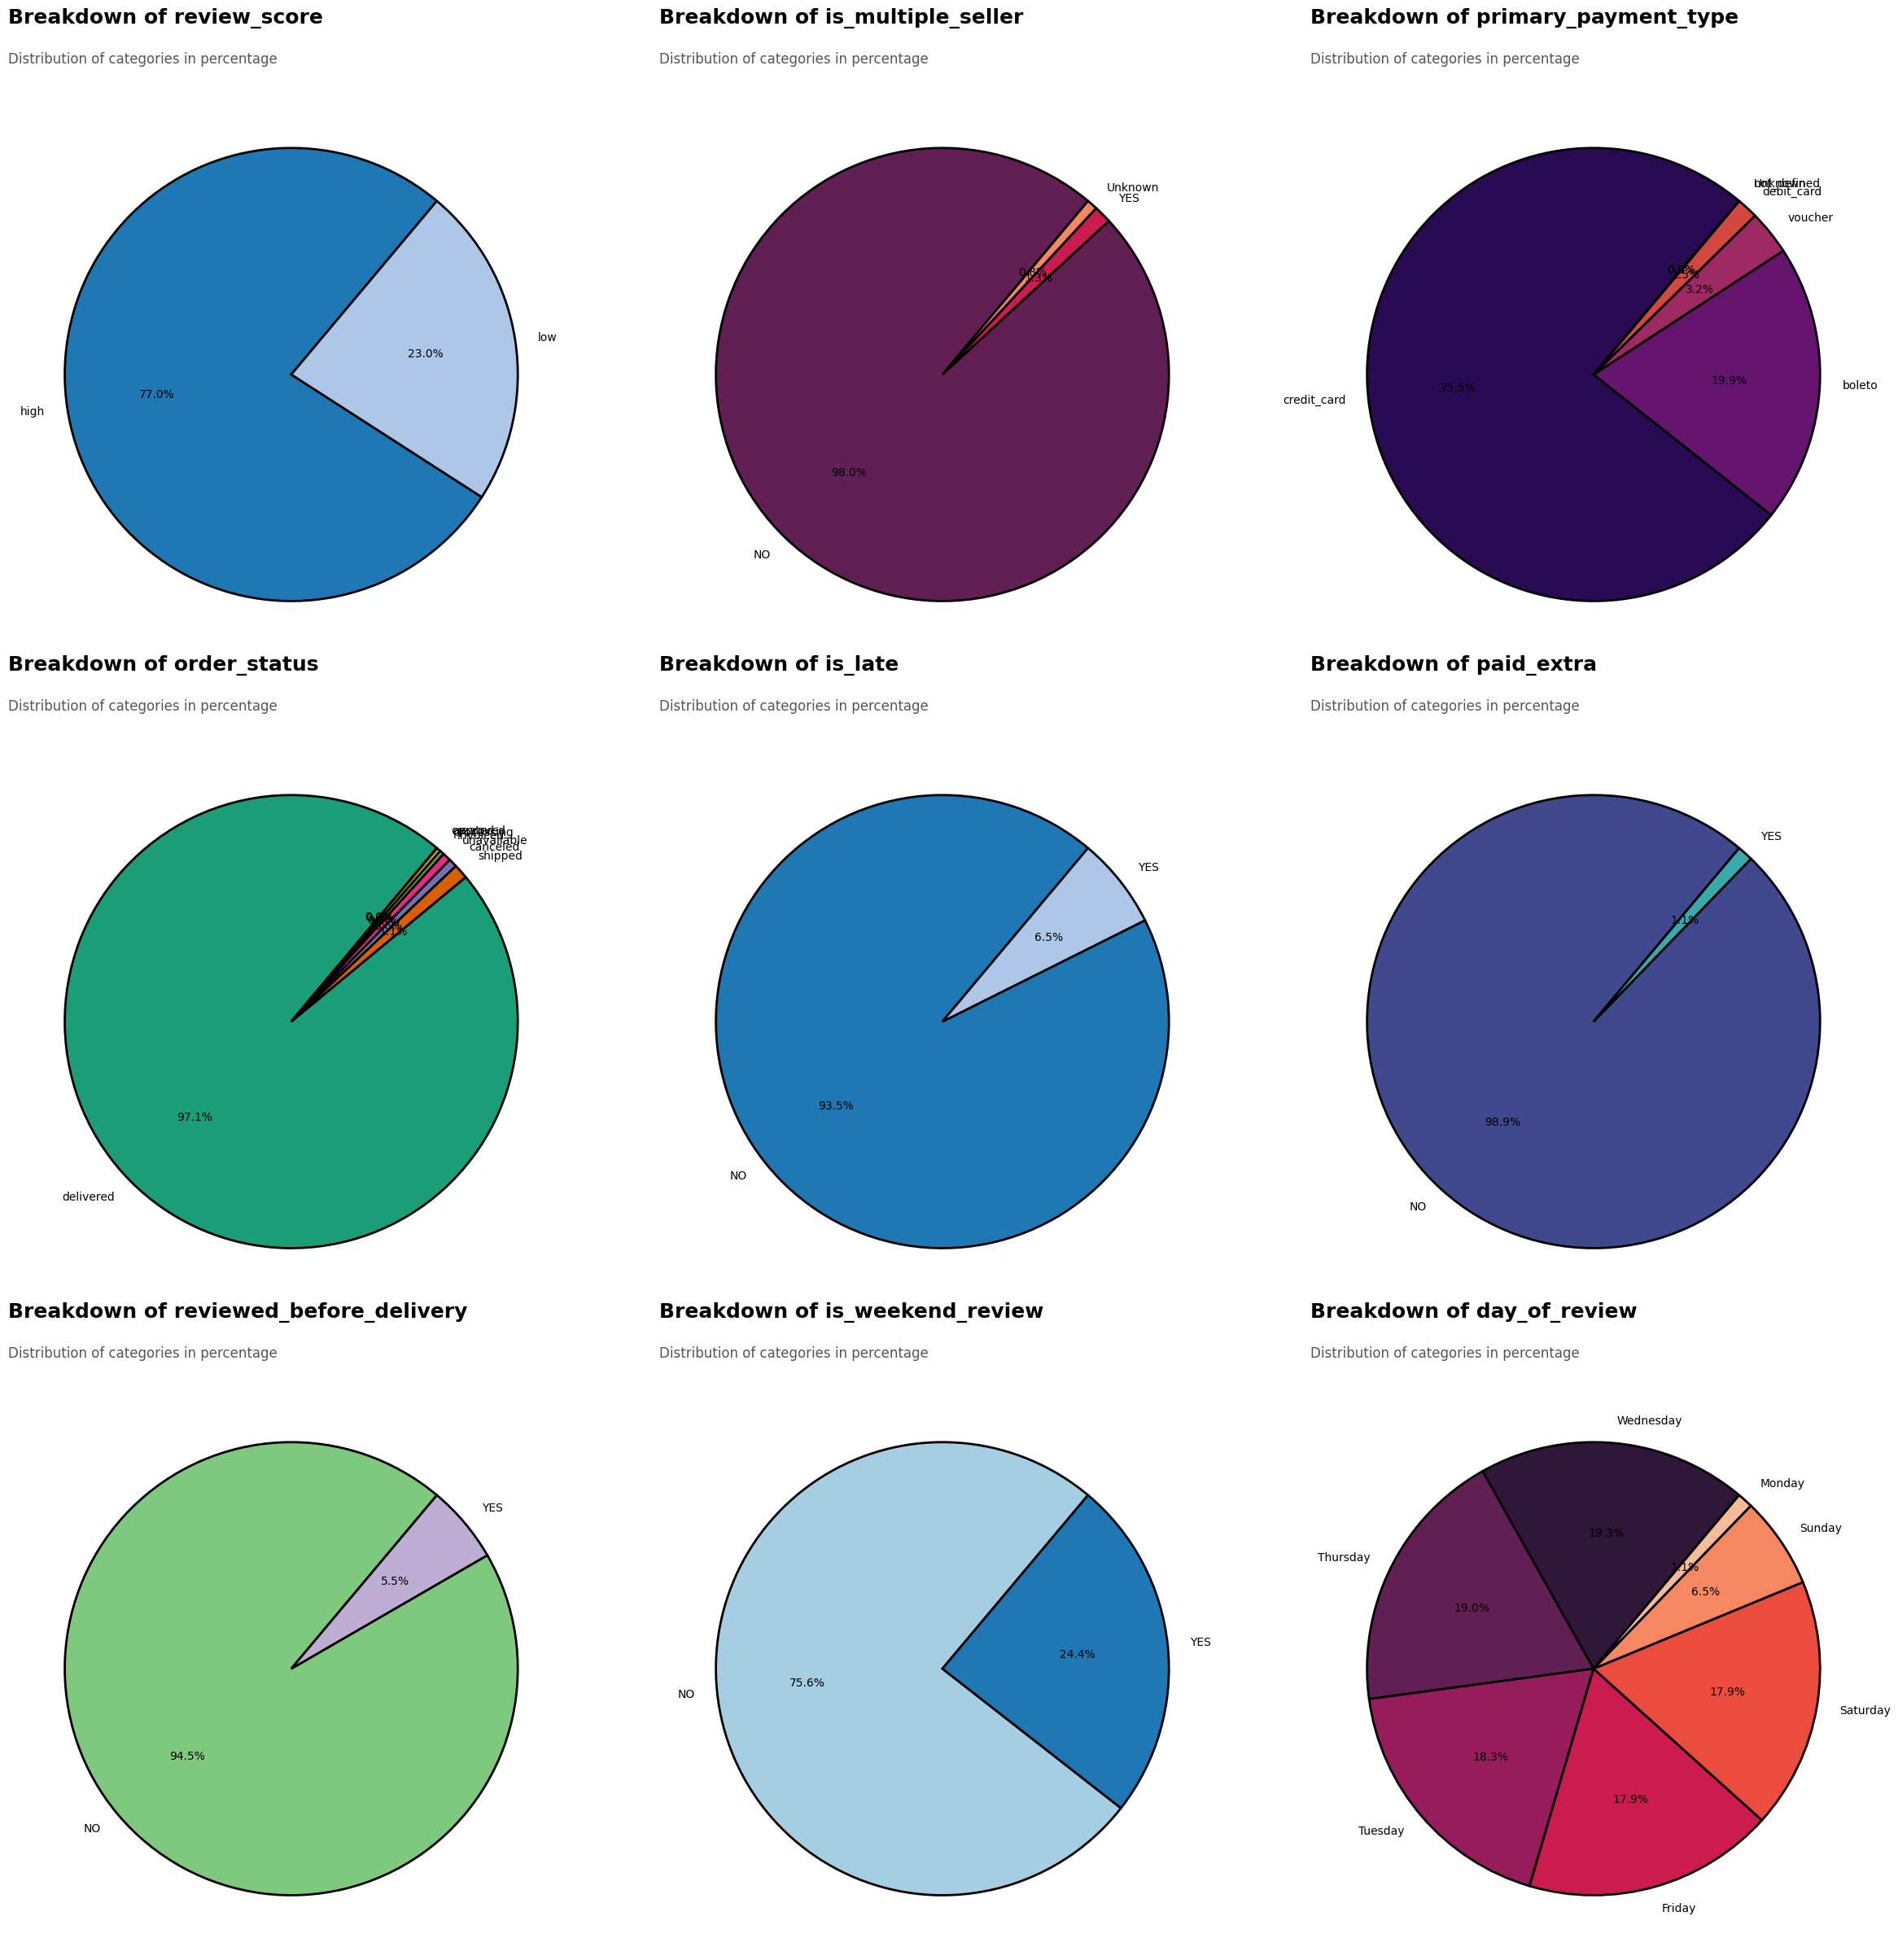

In [32]:
plt.figure(figsize=(24,24))
limit = len(cat_cols)
for i,col in enumerate(cat_cols):
    if i>limit:
        break
    plt.subplot(3,3,i+1)
    P.plot_pie(col,data)
plt.tight_layout()
plt.show()


***NEED TO FIX THE PRIMARY_PAYMENT_TYPE COLUMN***

In [33]:
data['primary_payment_type'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

primary_payment_type  percentage
0          credit_card       75.46
1               boleto       19.85
2              voucher        3.17
3           debit_card        1.52
4          not_defined        0.00
5              Unknown        0.00

In [34]:
to_keep = ['credit_card','boleto']

data['primary_payment_type']=data['primary_payment_type'].apply(lambda x: 'Others' if x not in to_keep else x)

***NEED TO FIX THE ORDER_STATUS COLUMN***

In [35]:
data['order_status'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

order_status  percentage
0    delivered       97.11
1      shipped        1.05
2     canceled        0.61
3  unavailable        0.60
4     invoiced        0.32
5   processing        0.30
6      created        0.00
7     approved        0.00

In [36]:
to_keep = ['delivered','shipped','canceled','unavailable']

data['order_status']=data['order_status'].apply(lambda x: 'Others' if x not in to_keep else x)

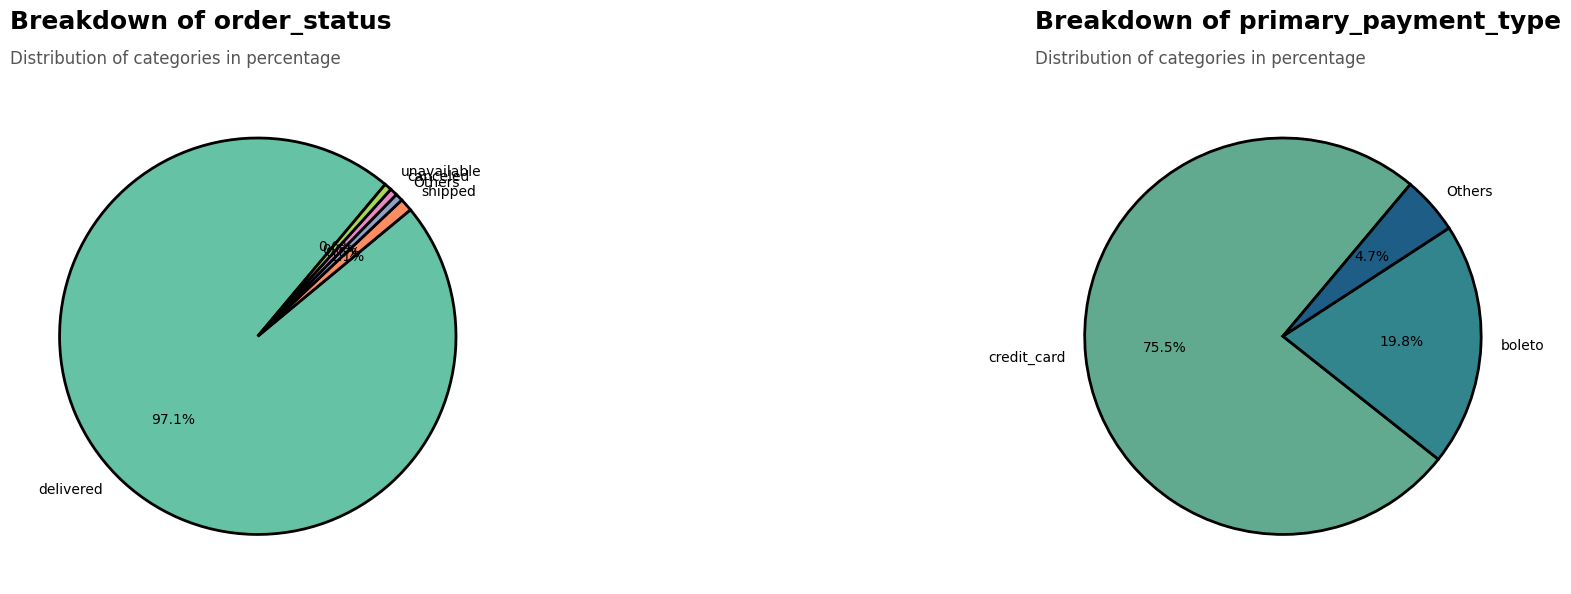

In [37]:
new_cols = ['order_status','primary_payment_type']

plt.figure(figsize=(24,6))
limit = len(new_cols)
for i,col in enumerate(new_cols):
    if i>limit:
        break
    plt.subplot(1,2,i+1)
    P.plot_pie(col,data)
plt.tight_layout()
plt.show()


**ANALYSIS OF NUMERICAL COLUMNS**

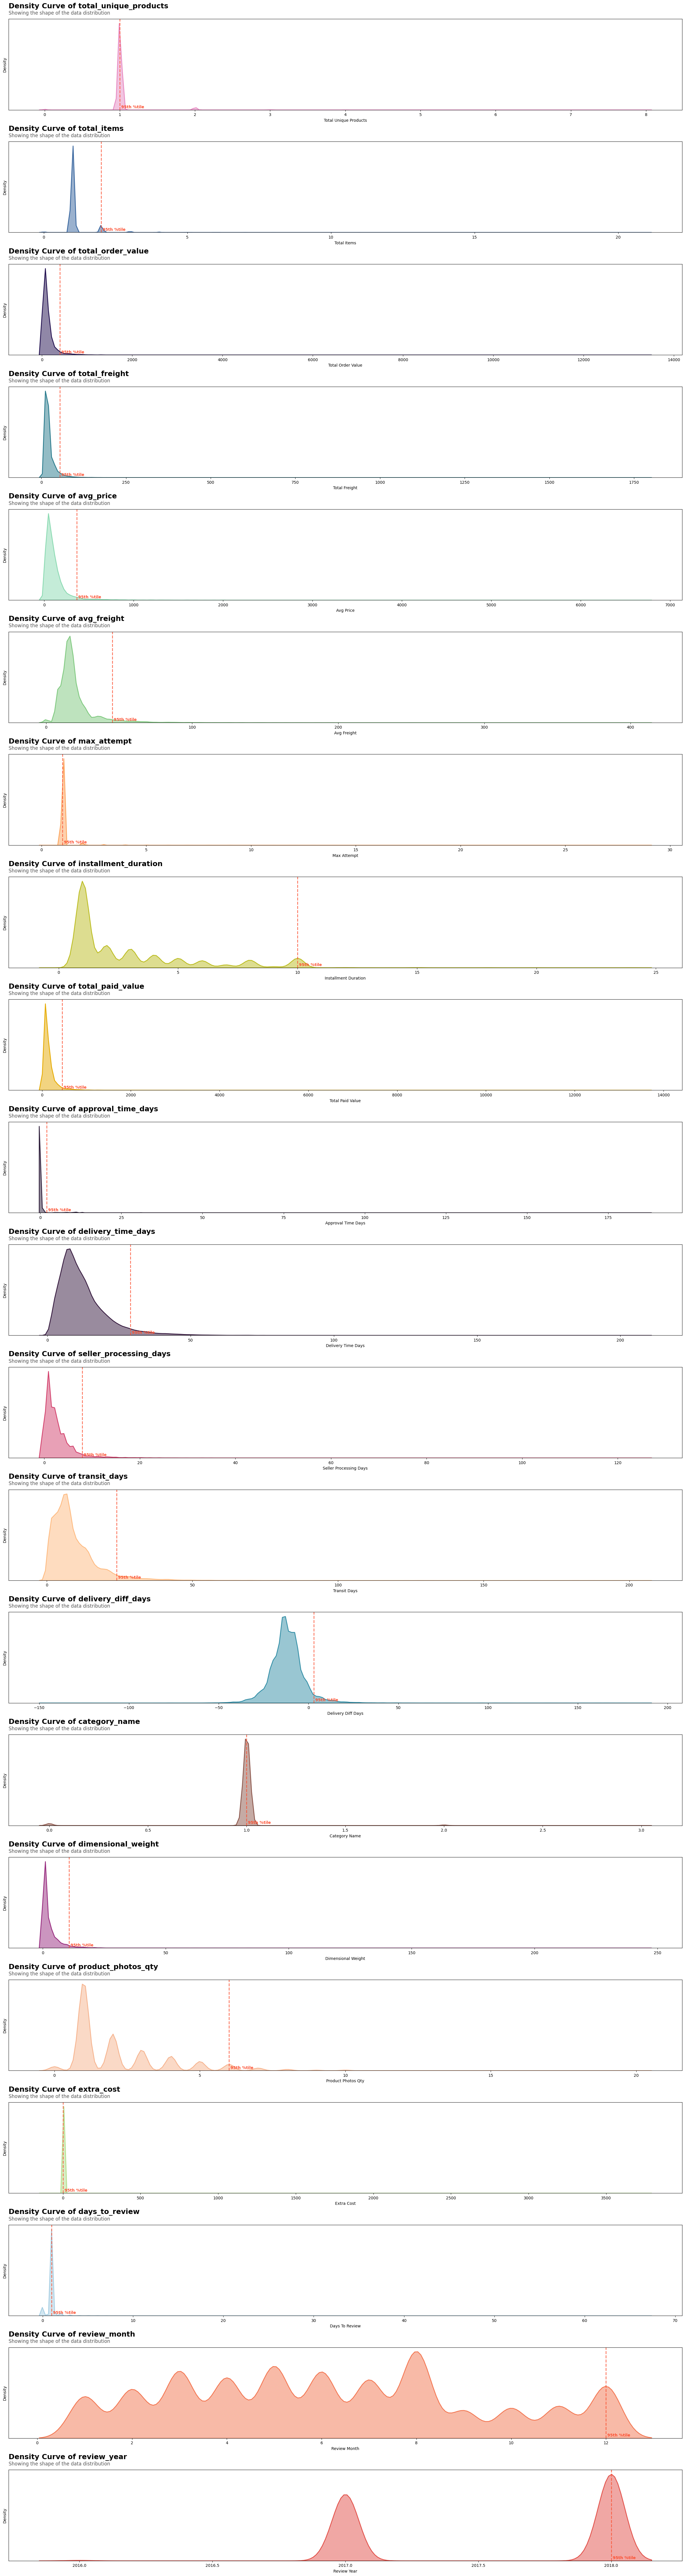

In [38]:
plt.figure(figsize=(24,90))
limit = len(num_cols)
for i,col in enumerate(num_cols):
    if i>limit:
        break
    plt.subplot(21,1,i+1)
    P.plot_kde(col,data)
plt.tight_layout()
plt.show()

**NEED TO FIX SOME COLUMNS**

In [39]:
def val_cts(column):
    val_cts = data[column].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'overall_percentage')
    sample_cts = data[column].value_counts().reset_index()
    df = val_cts.merge(sample_cts,on=column,how='left')
    df.rename(columns={"count":'sample_size'})
    return df

In [40]:
val_cts('total_unique_products').sort_values(by= 'total_unique_products')

total_unique_products  overall_percentage  count
2                      0                0.76    744
0                      1               96.01  94324
1                      2                2.84   2793
3                      3                0.30    296
4                      4                0.07     69
6                      5                0.01      8
5                      6                0.01     11
7                      7                0.00      3
8                      8                0.00      1

In [41]:
bins = [-1, 0, 1,2, 100]
labels = ['NONE', 'SINGLE', 'DOUBLE','MULTIPLE']
data['total_unique_products'] = pd.cut(data['total_unique_products'], bins=bins, labels=labels)

In [42]:
val_cts('total_unique_products').sort_values(by= 'total_unique_products')

total_unique_products  overall_percentage  count
2                  NONE                0.76    744
0                SINGLE               96.01  94324
1                DOUBLE                2.84   2793
3              MULTIPLE                0.39    388

In [43]:
val_cts('total_items').sort_values(by= 'total_items')

total_items  overall_percentage  count
3             0                0.76    744
0             1               89.41  87849
1             2                7.54   7408
2             3                1.33   1303
4             4                0.51    497
5             5                0.20    201
6             6                0.19    190
7             7                0.02     21
9             8                0.01      8
12            9                0.00      3
8            10                0.01      8
10           11                0.01      5
11           12                0.01      5
17           13                0.00      1
13           14                0.00      2
14           15                0.00      2
16           20                0.00      1
15           21                0.00      1

In [44]:
data['total_items']=data['total_items'].clip(upper=7)

In [45]:
val_cts('total_items').sort_values(by= 'total_items')

total_items  overall_percentage  count
3            0                0.76    744
0            1               89.41  87849
1            2                7.54   7408
2            3                1.33   1303
4            4                0.51    497
5            5                0.20    201
6            6                0.19    190
7            7                0.06     57

In [47]:
val_cts('max_attempt').sort_values(by= 'max_attempt')

max_attempt  overall_percentage  count
16            0                0.00      1
0             1               96.94  95247
1             2                2.47   2423
2             3                0.31    300
3             4                0.11    107
4             5                0.05     52
5             6                0.04     36
6             7                0.03     28
7             8                0.01     12
9             9                0.01      9
11           10                0.01      5
10           11                0.01      7
8            12                0.01      9
12           13                0.00      3
14           14                0.00      2
15           15                0.00      2
13           19                0.00      2
20           21                0.00      1
19           22                0.00      1
18           26                0.00      1
17           29                0.00      1

In [48]:
data['max_attempt'].quantile(.99)

np.float64(2.0)

In [49]:
data['max_attempt']=data['max_attempt'].apply(lambda x: 'SMOOTH' if x == 1 else 'FRICTION')

In [50]:
val_cts('max_attempt').sort_values(by= 'max_attempt')

max_attempt  overall_percentage  count
1    FRICTION                3.06   3002
0      SMOOTH               96.94  95247

In [51]:
val_cts('max_attempt').sort_values(by= 'max_attempt')

max_attempt  overall_percentage  count
1    FRICTION                3.06   3002
0      SMOOTH               96.94  95247

In [52]:
val_cts('installment_duration').sort_values(by= 'installment_duration')

installment_duration  overall_percentage  count
21                     0                0.00      3
0                      1               48.46  47616
1                      2               12.44  12218
2                      3               10.49  10304
3                      4                7.13   7002
5                      5                5.26   5172
7                      6                3.95   3881
8                      7                1.63   1604
6                      8                4.28   4207
9                      9                0.64    631
4                     10                5.37   5272
13                    11                0.02     22
10                    12                0.13    132
15                    13                0.02     17
17                    14                0.02     15
11                    15                0.07     73
19                    16                0.01      5
18                    17                0.01      8
12                    18                0.03     27
16                    20                0.02     16
20                    21                0.00      4
22                    22                0.00      1
23                    23                0.00      1
14                    24                0.02     18

In [53]:
data['installment_duration'].quantile(.99)

np.float64(10.0)

In [54]:
val_cts('approval_time_days').sort_values(by= 'approval_time_days')

approval_time_days  overall_percentage  count
0                  0.0               69.59  68368
1                  1.0               17.35  17044
2                  2.0                9.07   8908
3                  3.0                2.17   2135
4                  4.0                1.27   1252
5                  5.0                0.28    272
6                  6.0                0.05     50
7                  7.0                0.02     24
8                  8.0                0.02     16
12                 9.0                0.00      4
10                10.0                0.01      5
9                 11.0                0.01      7
18                12.0                0.00      1
11                13.0                0.01      5
16                17.0                0.00      1
13                23.0                0.00      2
21                24.0                0.00      1
17                29.0                0.00      1
14                31.0                0.00      2
19                32.0                0.00      1
22                33.0                0.00      1
15                60.0                0.00      1
20               188.0                0.00      1

In [55]:
data['approval_time_days'].quantile(.99)

np.float64(4.0)

In [56]:
data['approval_time_days']=data['approval_time_days'].clip(upper=4)

In [57]:
val_cts('approval_time_days').sort_values(by= 'approval_time_days')

approval_time_days  overall_percentage  count
0                 0.0               69.59  68368
1                 1.0               17.35  17044
2                 2.0                9.07   8908
3                 3.0                2.17   2135
4                 4.0                1.68   1647

In [58]:
val_cts('approval_time_days').sort_values(by= 'approval_time_days')

approval_time_days  overall_percentage  count
0                 0.0               69.59  68368
1                 1.0               17.35  17044
2                 2.0                9.07   8908
3                 3.0                2.17   2135
4                 4.0                1.68   1647

In [59]:
val_cts('category_name').sort_values(by= 'category_name')

category_name  overall_percentage  count
1              0                2.16   2124
0              1               97.11  95414
2              2                0.71    696
3              3                0.02     15

In [60]:
bins = [-1, 0, 1, 10]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['category_name'] = pd.cut(data['category_name'], bins=bins, labels=labels)

In [61]:
val_cts('category_name').sort_values(by= 'category_name')

category_name  overall_percentage  count
1          NONE                2.16   2124
0        SINGLE               97.11  95414
2      MULTIPLE                0.72    711

In [62]:
val_cts('review_year').sort_values(by= 'review_year')

review_year  overall_percentage  count
2         2016                0.33    321
1         2017               43.29  42532
0         2018               56.38  55396

In [63]:
cat_cols = data.select_dtypes(include=['object','category']).columns.values.tolist()
num_cols = data.select_dtypes(include='number').columns.values.tolist()

### ***Bivariate Analysis***

***CATEGORICAL COLUMNS WITH `REVIEW_SCORE` COLUMN***

**is_multiple_seller**

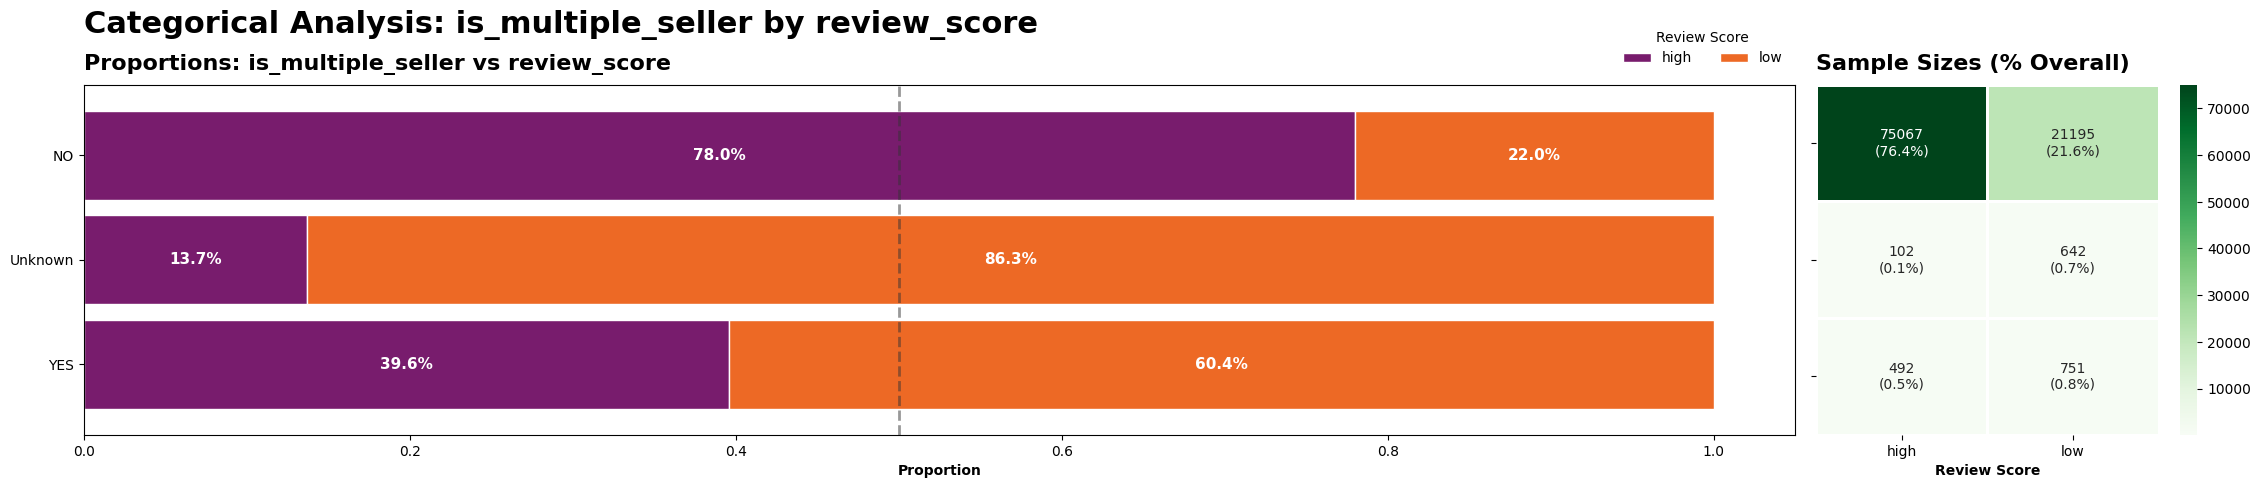

In [64]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'is_multiple_seller','review_score')

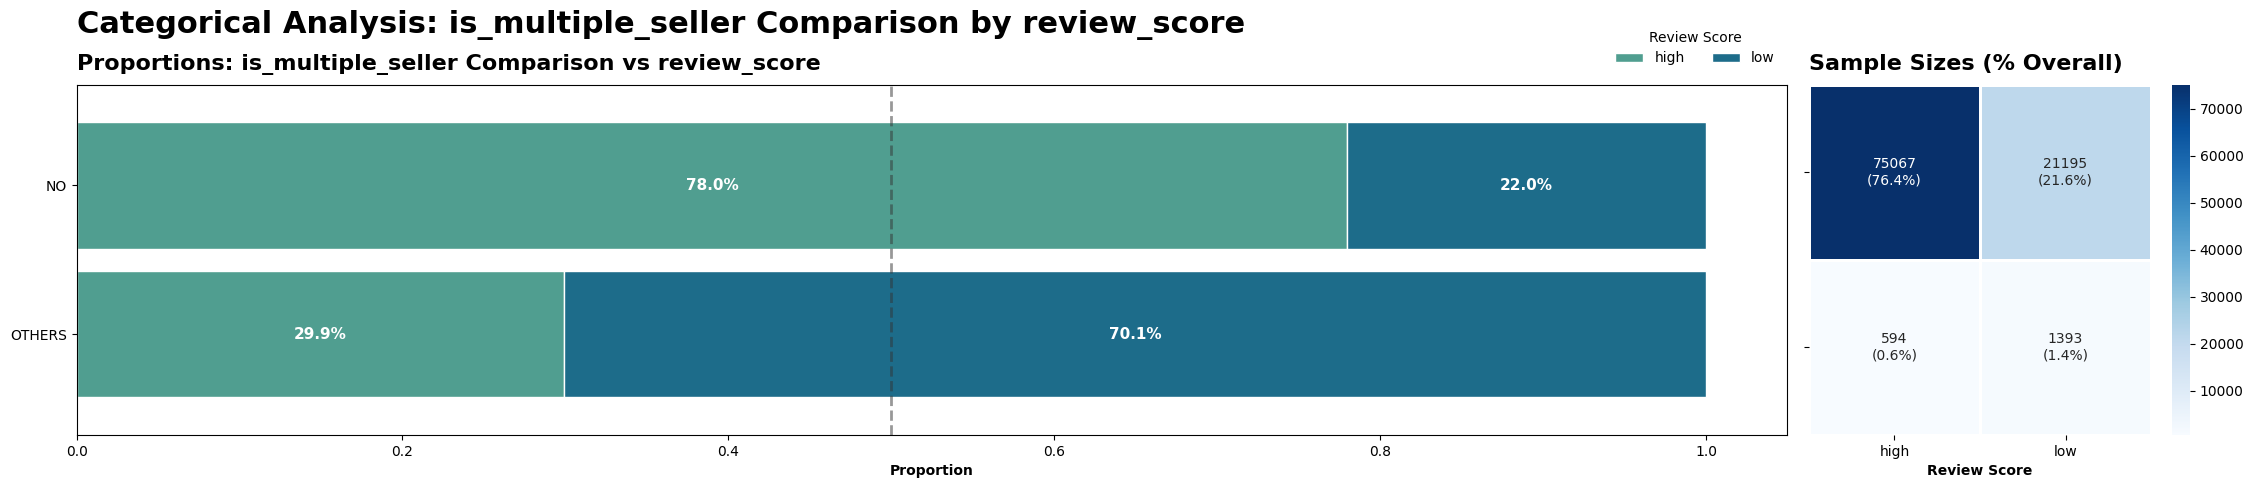

In [66]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(data,'is_multiple_seller','NO','review_score')

In [79]:
is_multiple_seller_mask = data['is_multiple_seller'] == 'NO'
ct = pd.crosstab(is_multiple_seller_mask,data['review_score'])
S.test_association(ct)


--- Association Test: is_multiple_seller vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.161)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when is_multiple_seller is NO, then there are more high review_score, and that too with more than 75% of overall data` - by statistical test we can support this observation with moderate strength, and the large sample size make this a reliable finding***
---
---

**primary_payment_type**

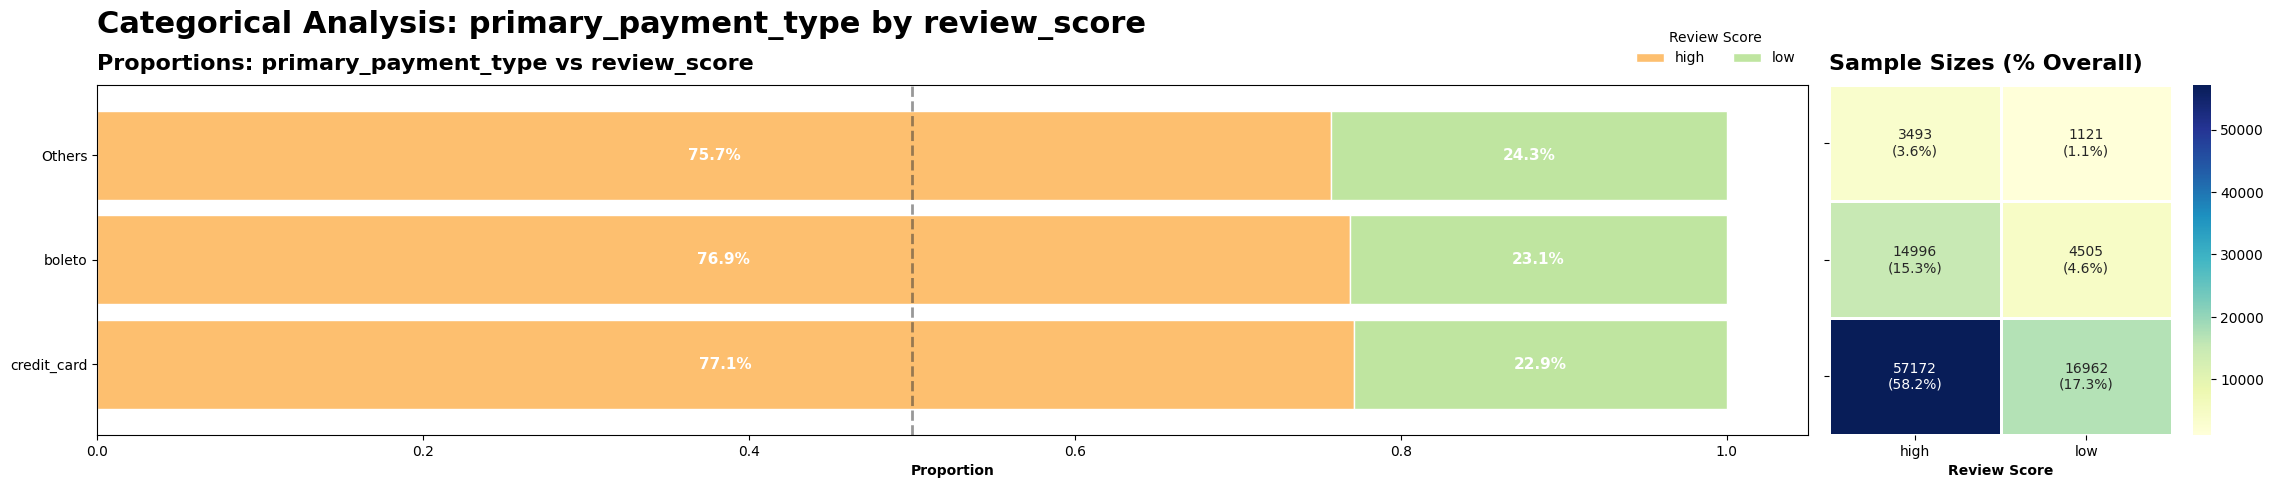

In [68]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'primary_payment_type','review_score')

- ***We dont see anything specific from the visuals***

**order_status**

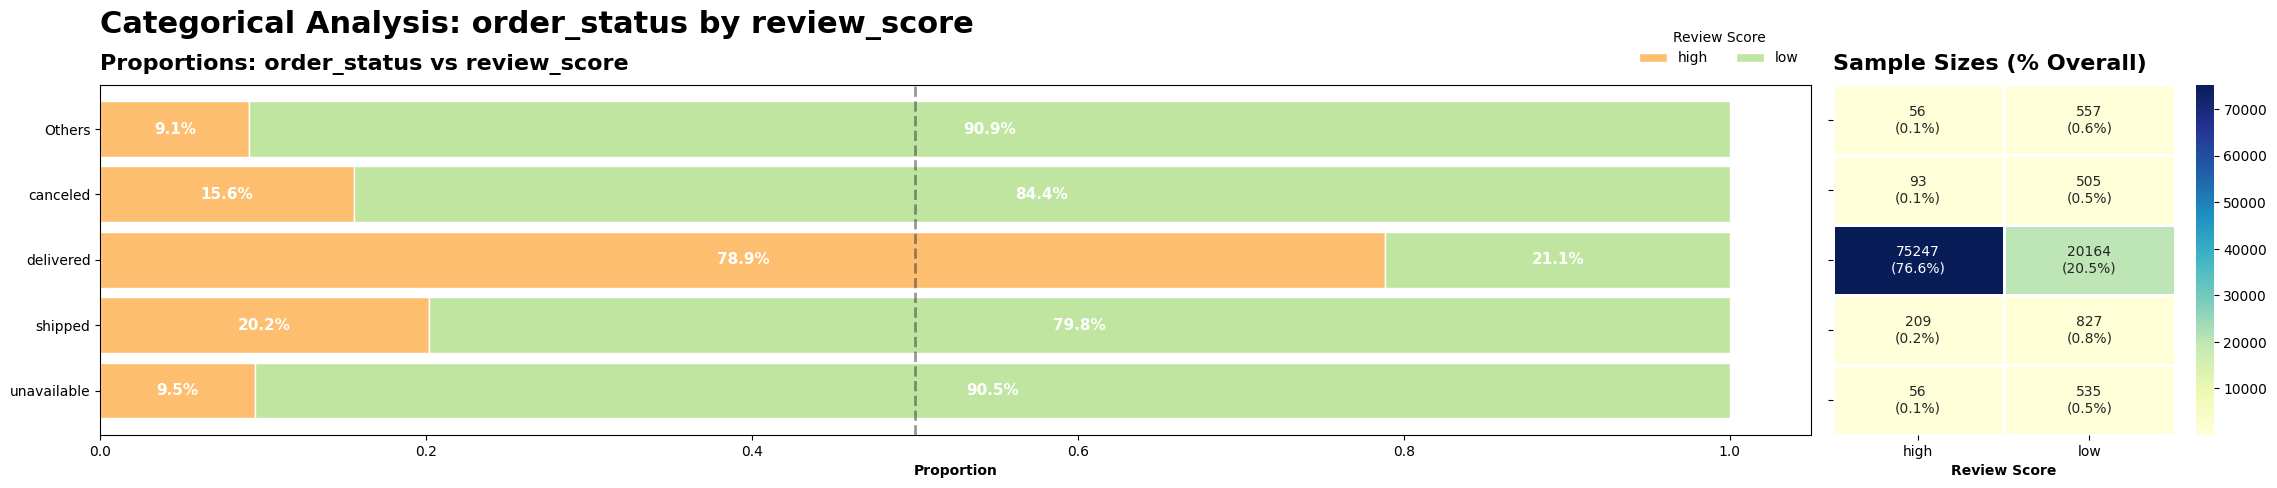

In [69]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'order_status','review_score')

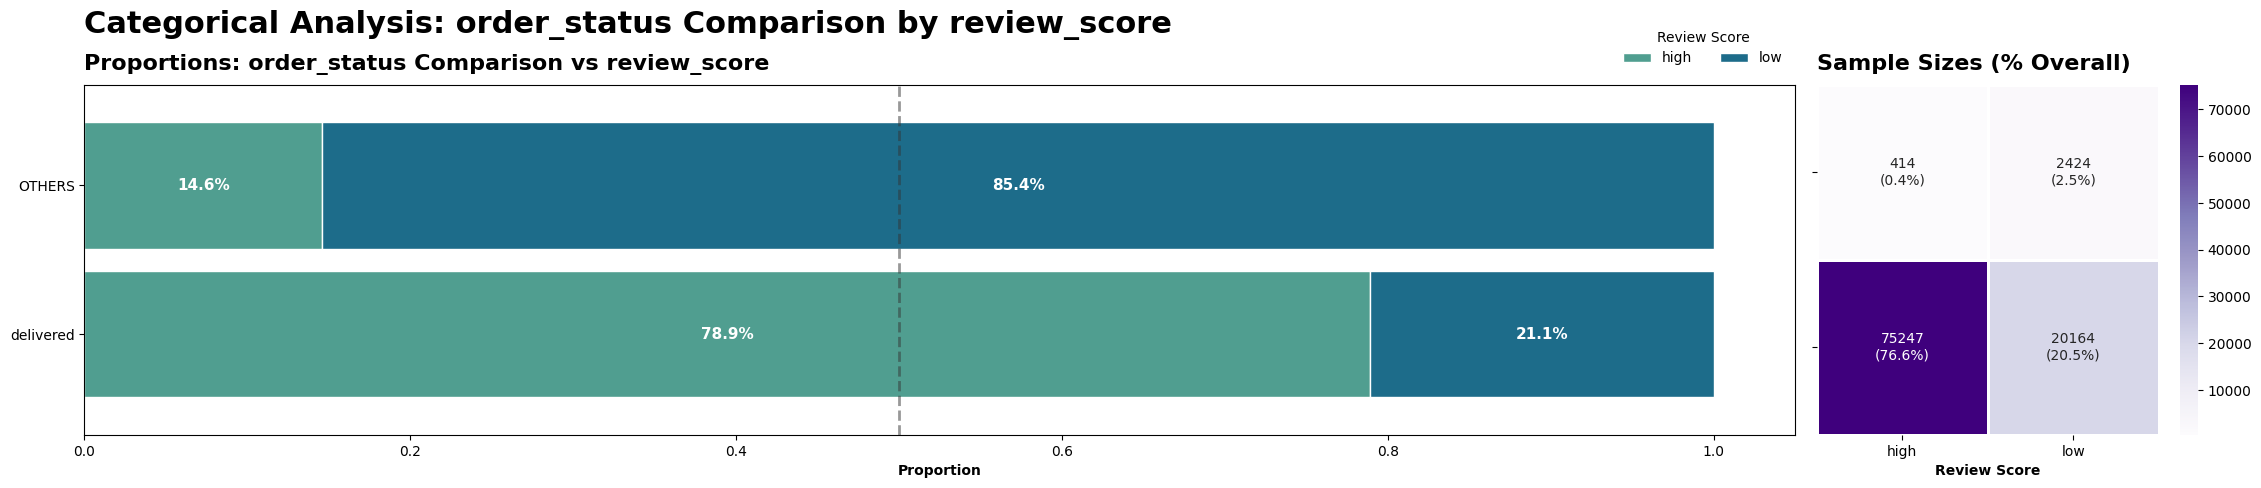

In [70]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(data,'order_status','delivered','review_score')

In [77]:
order_status_mask = data['order_status'] != 'delivered'
ct = pd.crosstab(order_status_mask,data['review_score'])
S.test_association(ct)


--- Association Test: order_status vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.256)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `order status other than delivered have got more lower review scores` - by statistical test we can support this observation with moderate strength, and the large sample size make this a reliable finding***
---
---

**is_late**

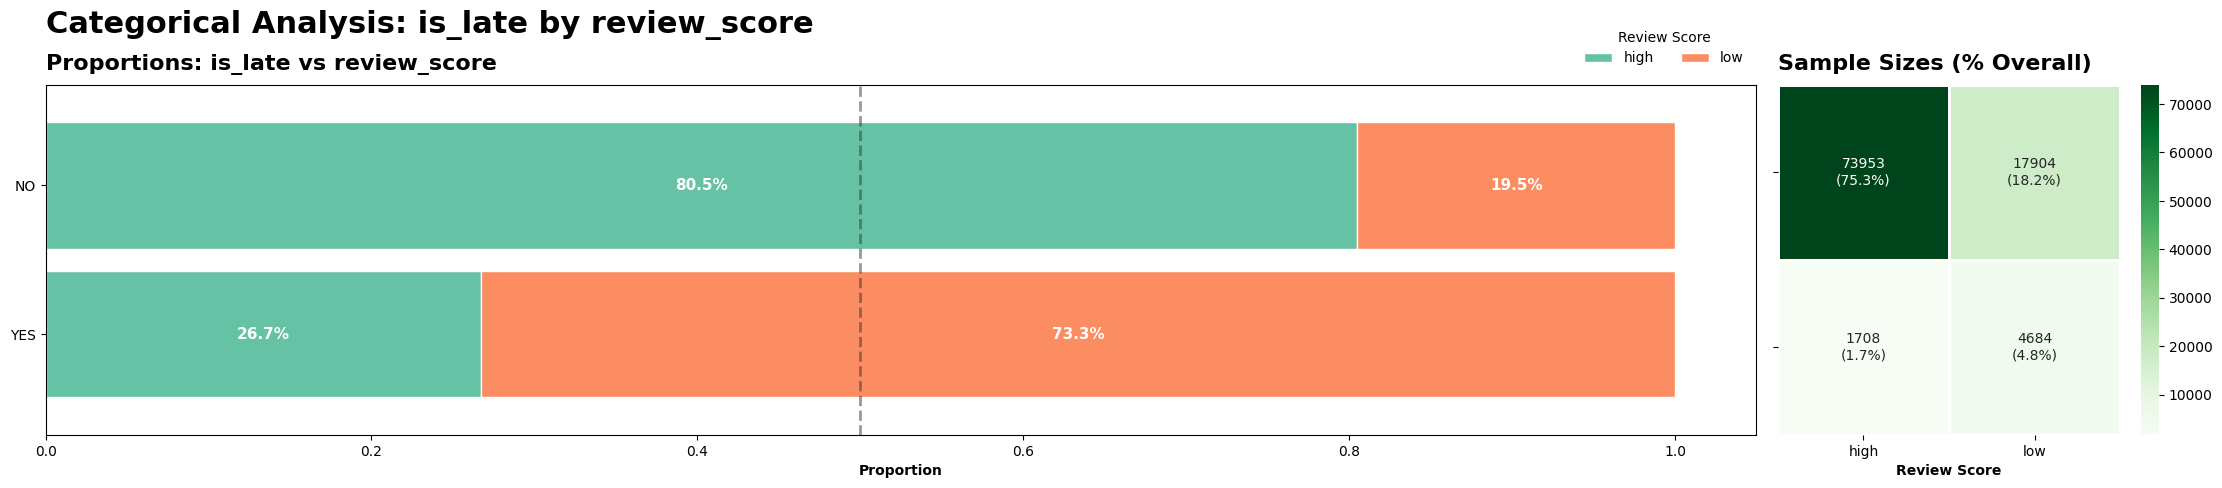

In [72]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'is_late','review_score')

In [80]:
ct = pd.crosstab(data['is_late'],data['review_score'])
S.test_association(ct)


--- Association Test: is_late vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.315)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when the delivery is late, then the review score is more likely to be lower review` - by statistical test we can support this observation with strong strength, and the large sample size make this a reliable finding***
---
---

**paid_extra**

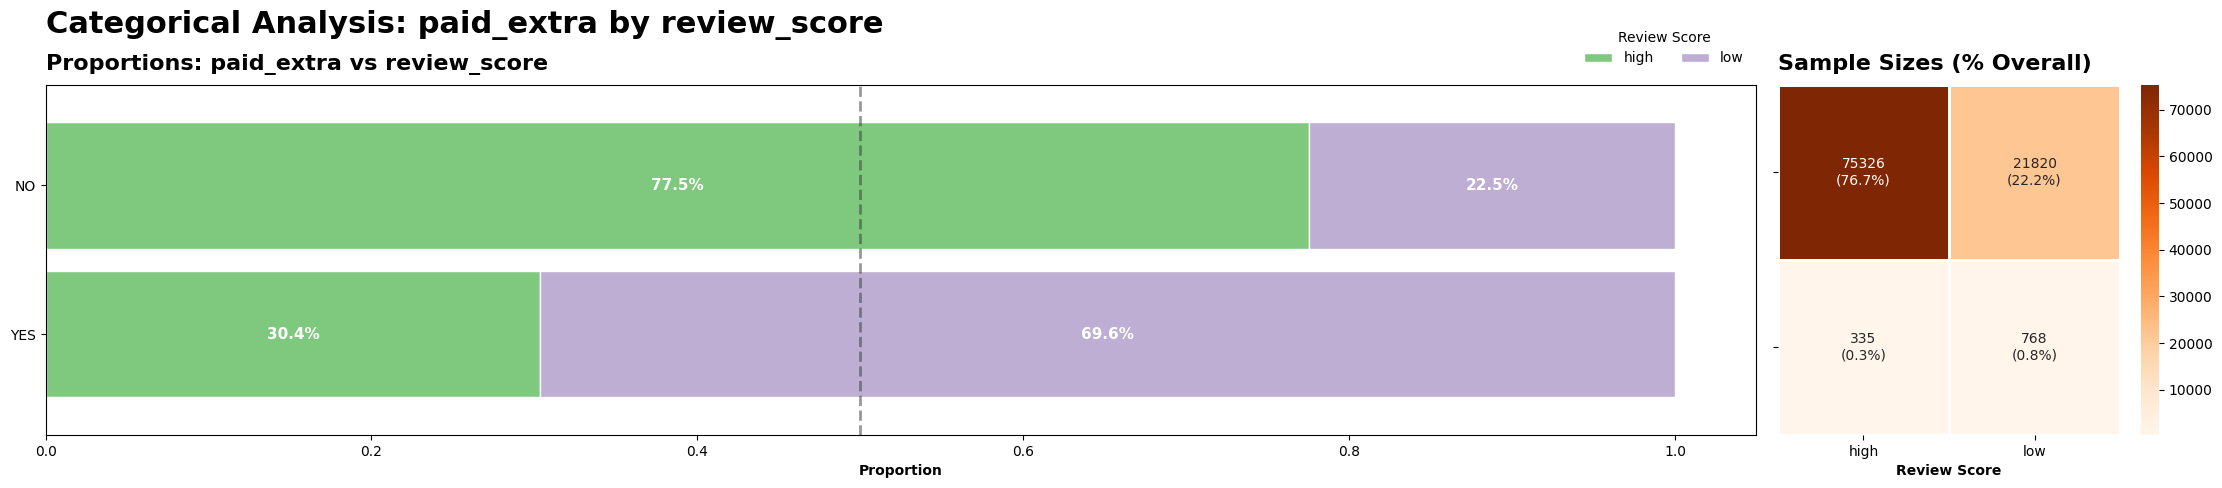

In [81]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'paid_extra','review_score')

In [82]:
ct = pd.crosstab(data['paid_extra'],data['review_score'])
S.test_association(ct)


--- Association Test: paid_extra vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.118)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when the customer have to pay extra money, then they have given more lower rating` - by statistical test we can support this observation with moderate strength, and the large sample size makes it a reliable finding***
---
---

**reviewed_before_delivery**

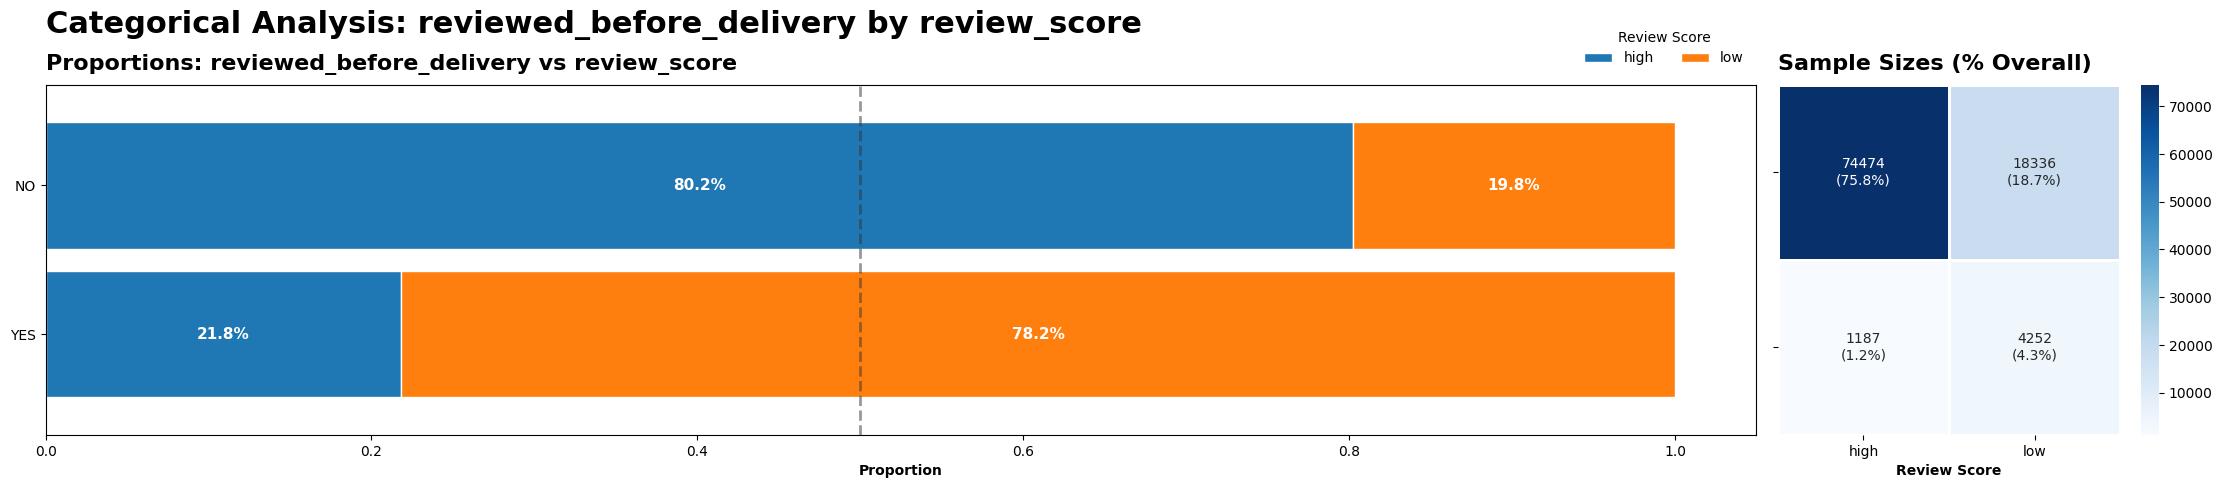

In [83]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'reviewed_before_delivery','review_score')

In [84]:
ct = pd.crosstab(data['reviewed_before_delivery'],data['review_score'])
S.test_association(ct)


--- Association Test: reviewed_before_delivery vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.317)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when the customer have given before the delivery then there is more lower review score` - by statistical test we can support this observation with strong strength, and the large sample size makes it a reliable finding***
---
---

**is_weekend_review**

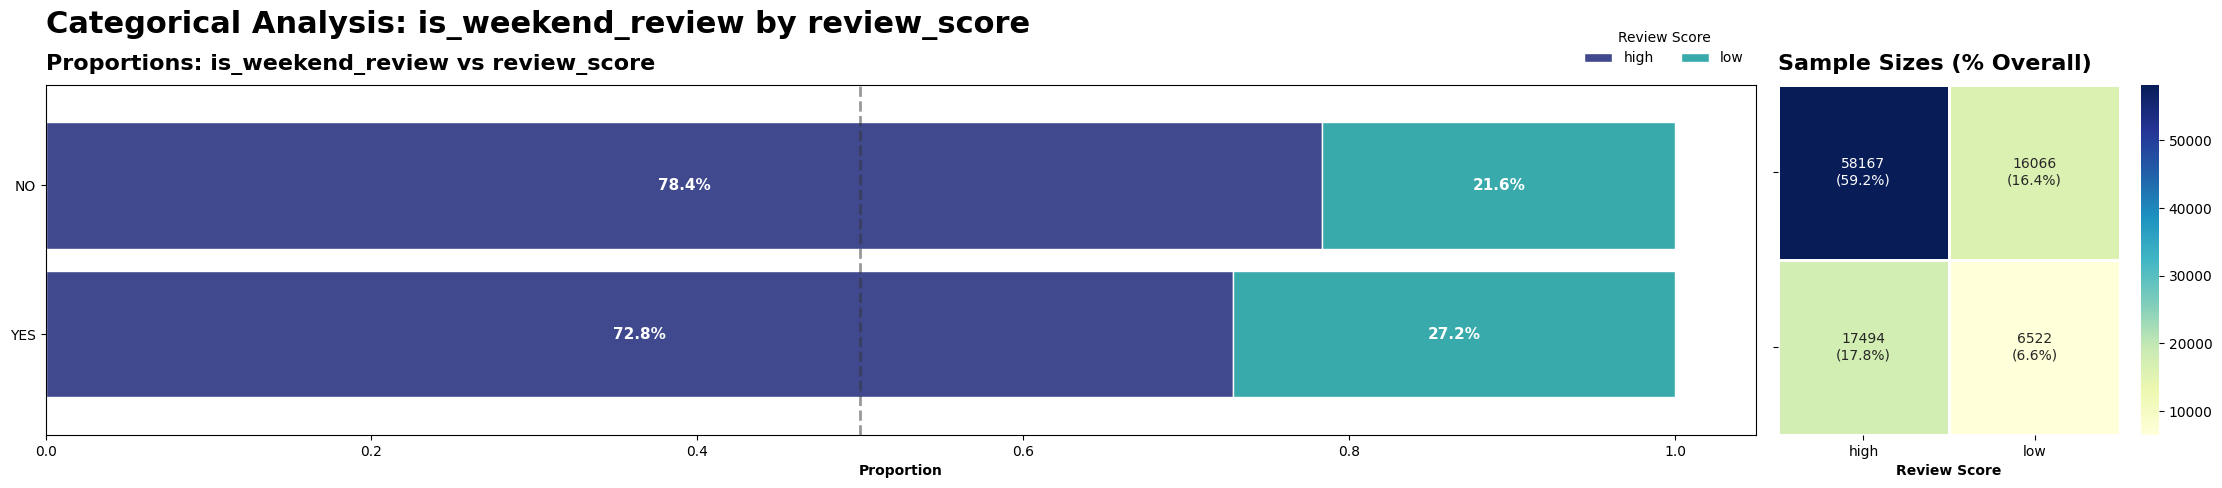

In [85]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'is_weekend_review','review_score')

- ***we do not see anything specific from weekend reviews***

**day_of_review**

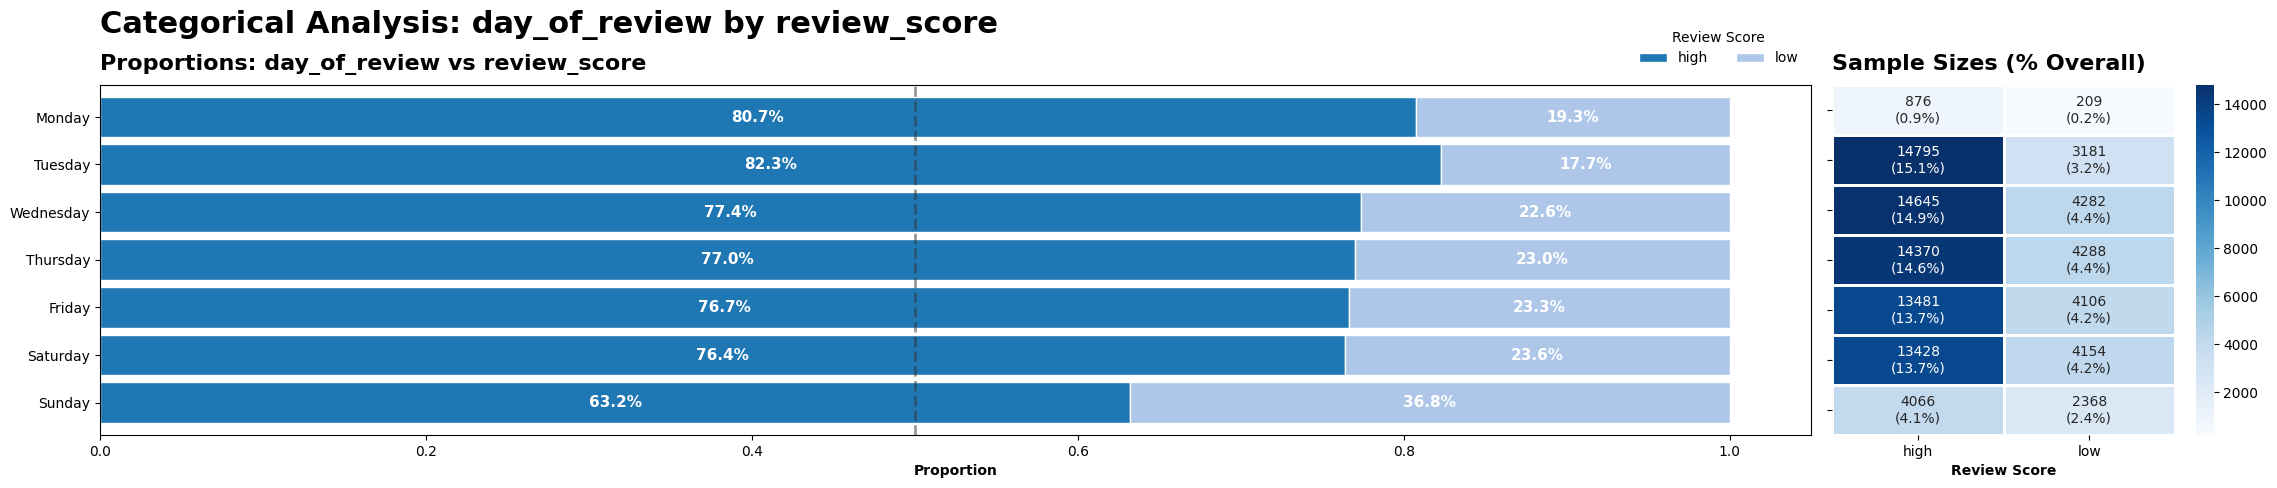

In [86]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday', ]
plt.figure(figsize=(24,5))
P.plot_categorical(data,'day_of_review','review_score',order=day_order)

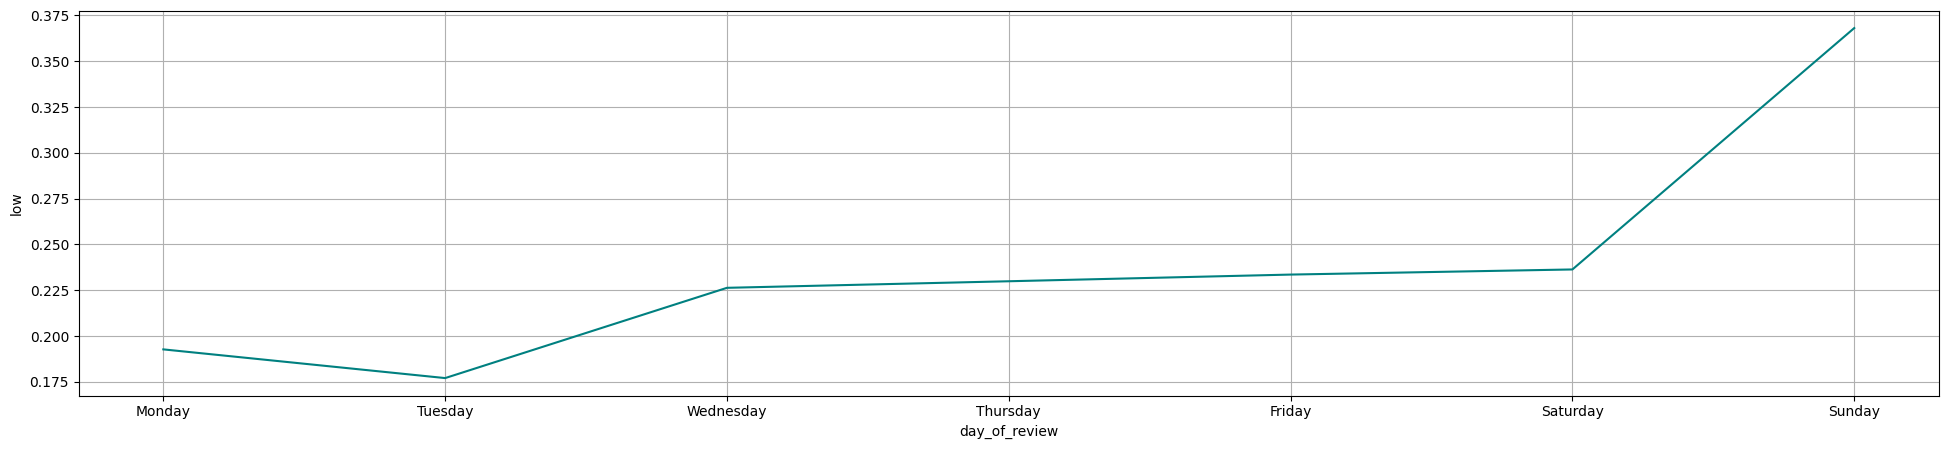

In [87]:
ct = pd.crosstab(data['day_of_review'],data['review_score'],normalize='index')
ct = ct.reindex(day_order)
temp = ct.reset_index()[['day_of_review','low']]
plt.figure(figsize=(24,5))
sns.lineplot(x = 'day_of_review',y = 'low',data = temp,color = 'teal')
plt.grid()
plt.show()

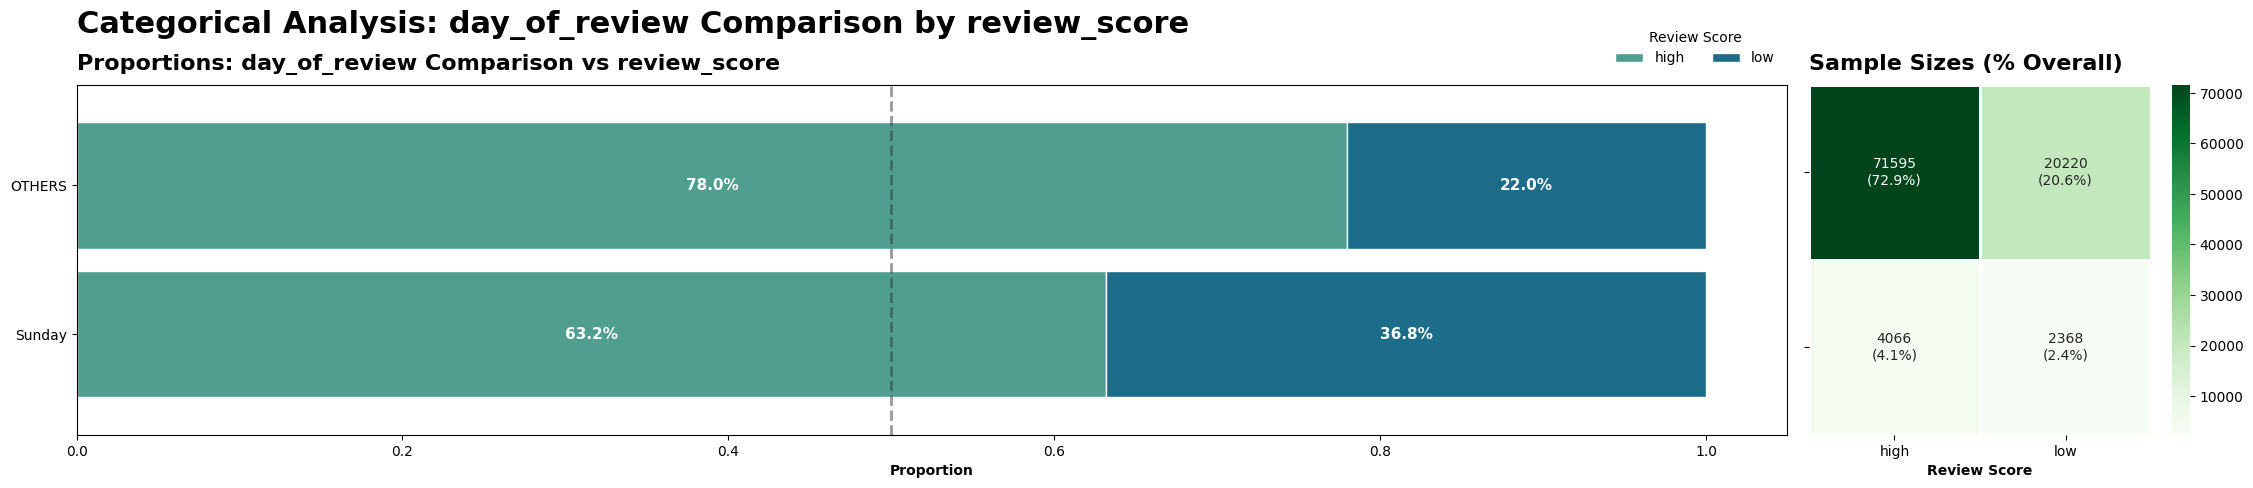

In [88]:
day_review_mask = data['day_of_review'] == 'Sunday'
ct = pd.crosstab(day_review_mask,data['review_score'],normalize='index')
plt.figure(figsize=(24,5))
P.plot_masked_categorical(data,'day_of_review','Sunday','review_score')

In [89]:
day_review_mask = data['day_of_review'] == 'Sunday'
ct = pd.crosstab(day_review_mask,data['review_score'])
S.test_association(ct)


--- Association Test: day_of_review vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.087)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [90]:
ct = pd.crosstab(data['day_of_review'],data['review_score'])
S.test_association(ct)


--- Association Test: day_of_review vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.101)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `if we consider monday as start of the week then lower reviews are more in number the following days maxing at sunday` - by statistical test we can support this observation with moderate strength, and the large sample size makes it a reliable finding***
---
---

**total_unique_products**

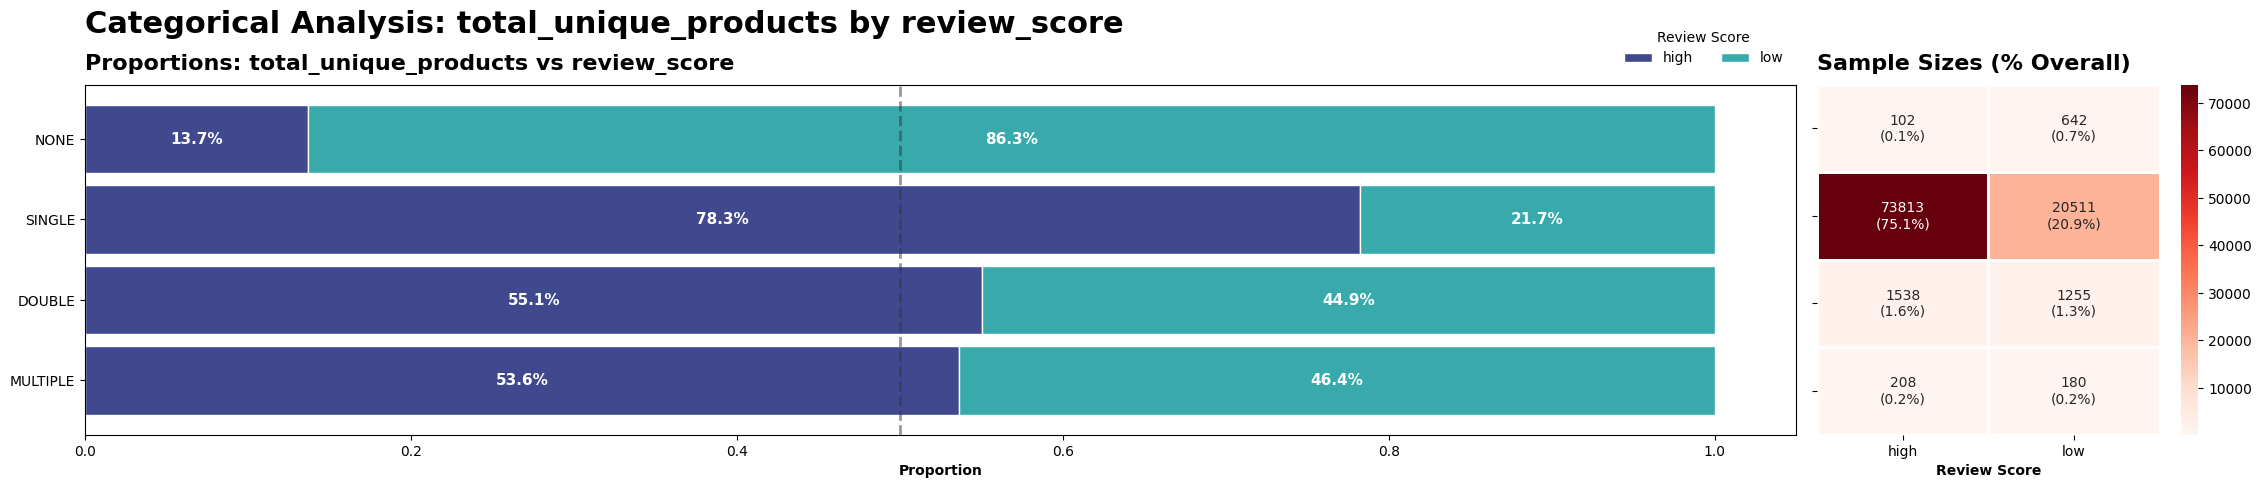

In [92]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'total_unique_products','review_score')

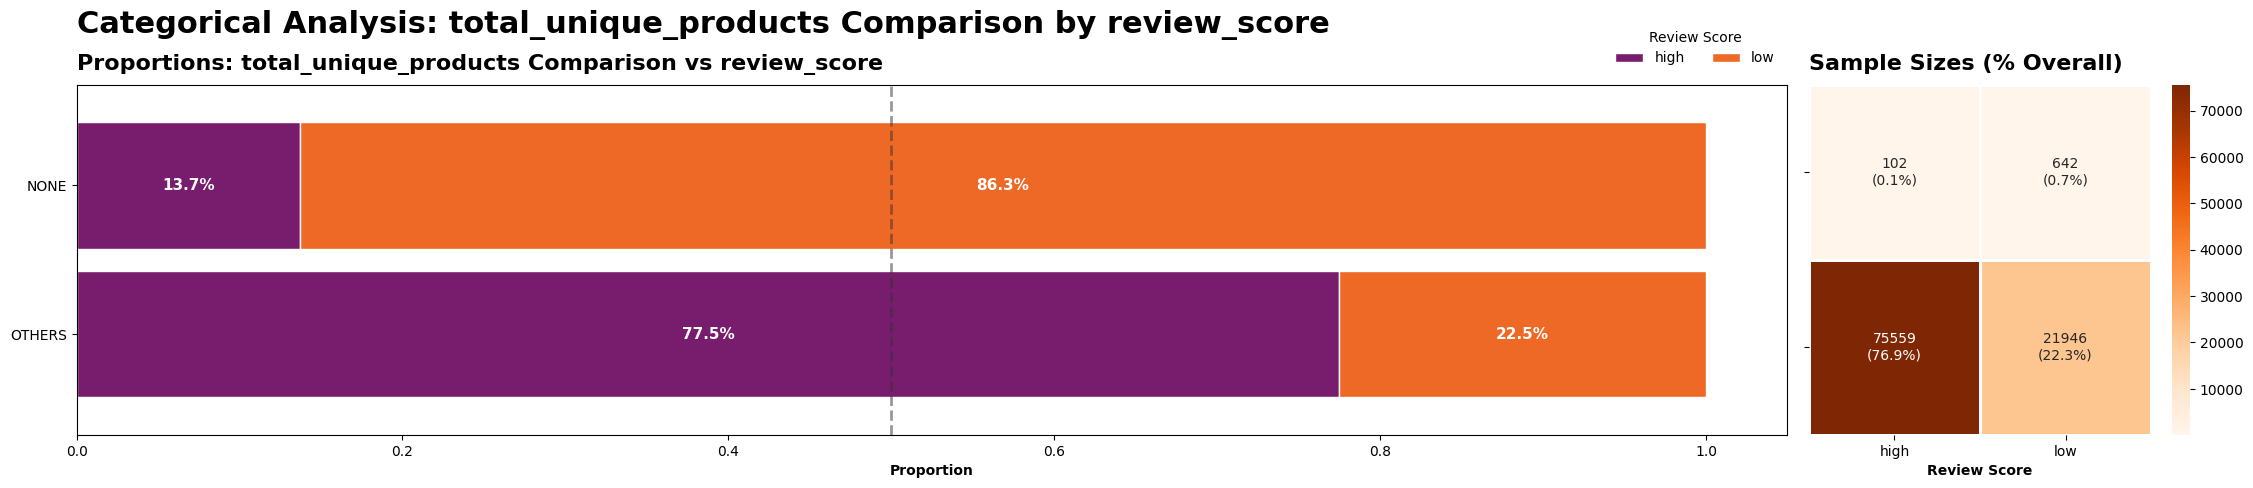

In [94]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(data,'total_unique_products','NONE','review_score')

In [95]:
unique_p_mask = data['total_unique_products'] == 'NONE'
ct = pd.crosstab(unique_p_mask,data['review_score'])
S.test_association(ct)


--- Association Test: total_unique_products vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.131)
3. Balance:    High Imbalance (Caution)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when customer did not/could not bought any product, then the deilvery is more into lower side` - by statistical test we can support this observation with moderate strength, but for the highly imbalanced sample size, we have to be cautious about this finding***
---
---

***category_name***

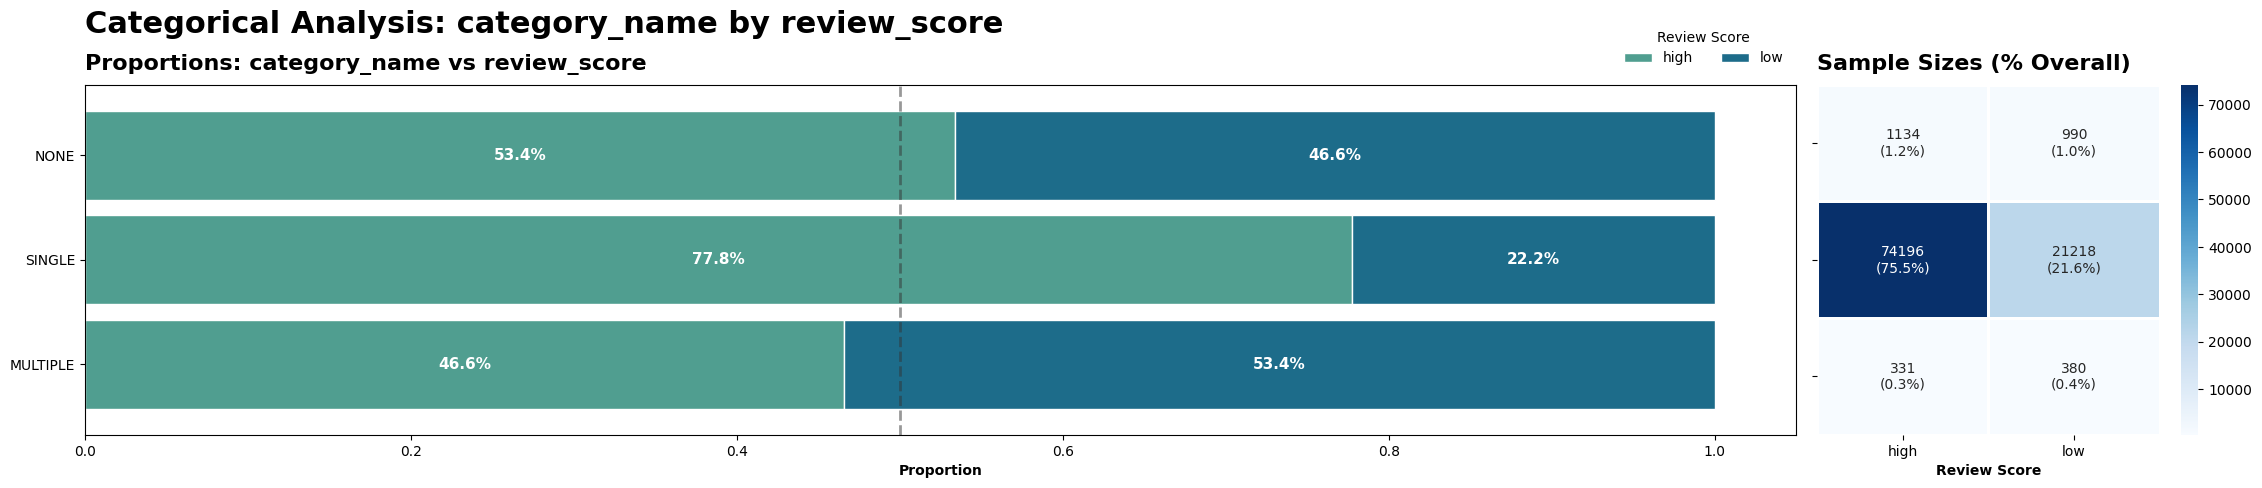

In [96]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'category_name','review_score')

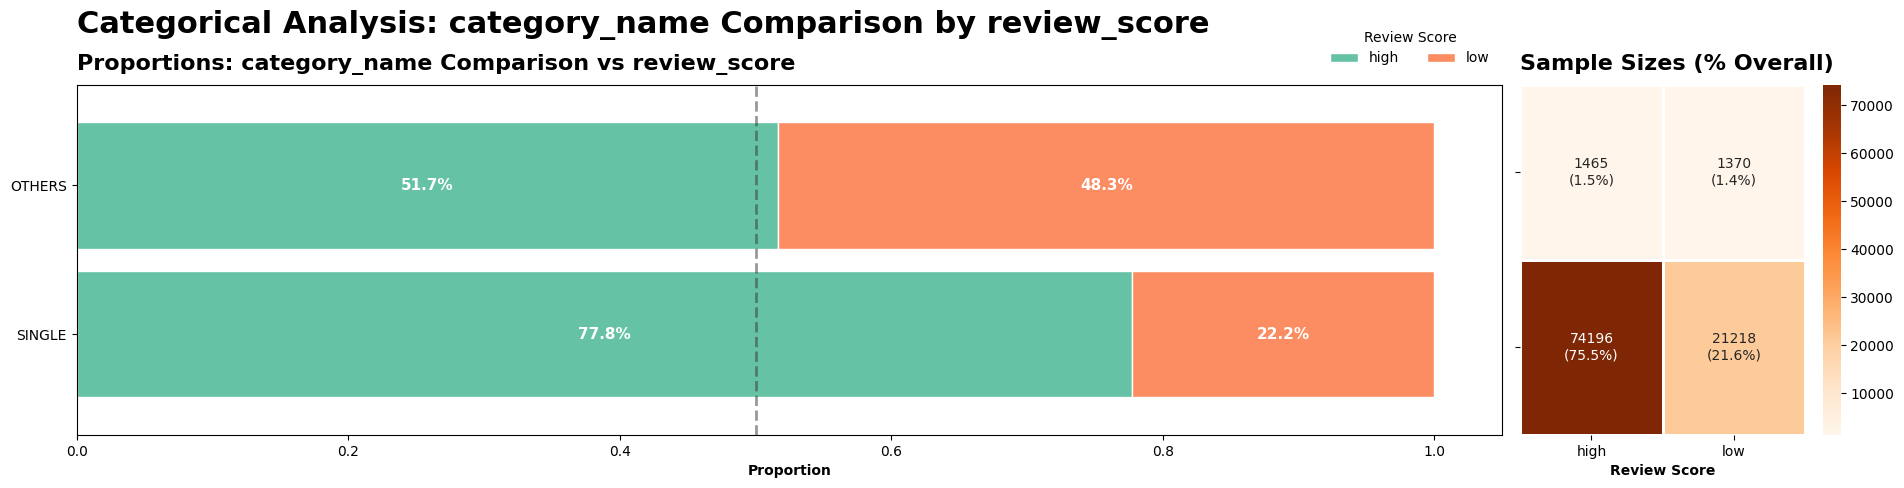

In [97]:
plt.figure(figsize=(20, 5))
P.plot_masked_categorical(data,'category_name','SINGLE','review_score')

In [98]:
ct = pd.crosstab(data['category_name'],data['review_score'])
S.test_association(ct)


--- Association Test: category_name vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.104)
3. Balance:    High Imbalance (Caution)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when the customer bouth more than 1 kind of category then they gave more lower ratings` - by statistical test we can support this observation with moderate strength, but for the high imbalance in class, it makes this finding a cautious one***
---
---

**max_attempt**

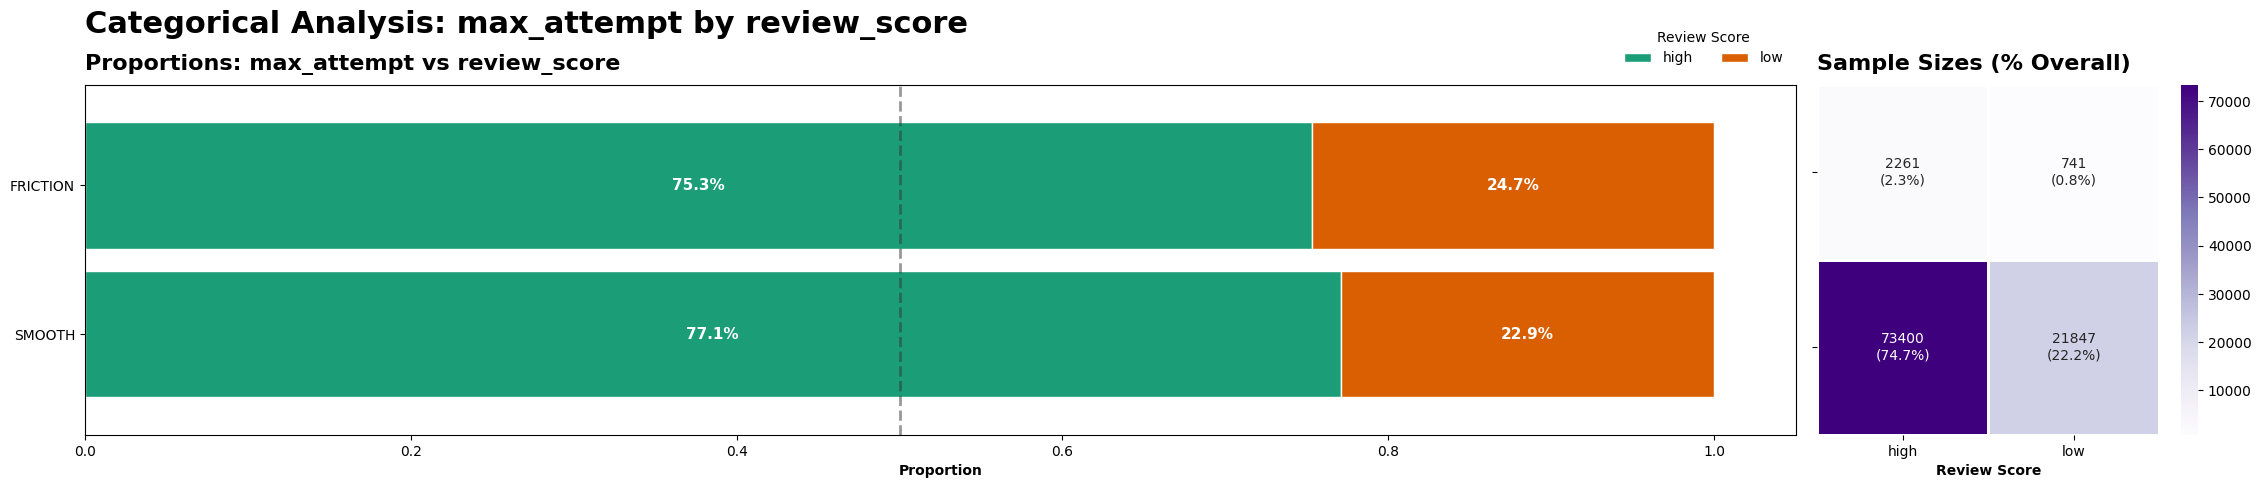

In [99]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'max_attempt','review_score')

- ***we do not find anything specific***

***NUMERICAL COLUMNS WITH `review_score` COLUMN***

**total_items**

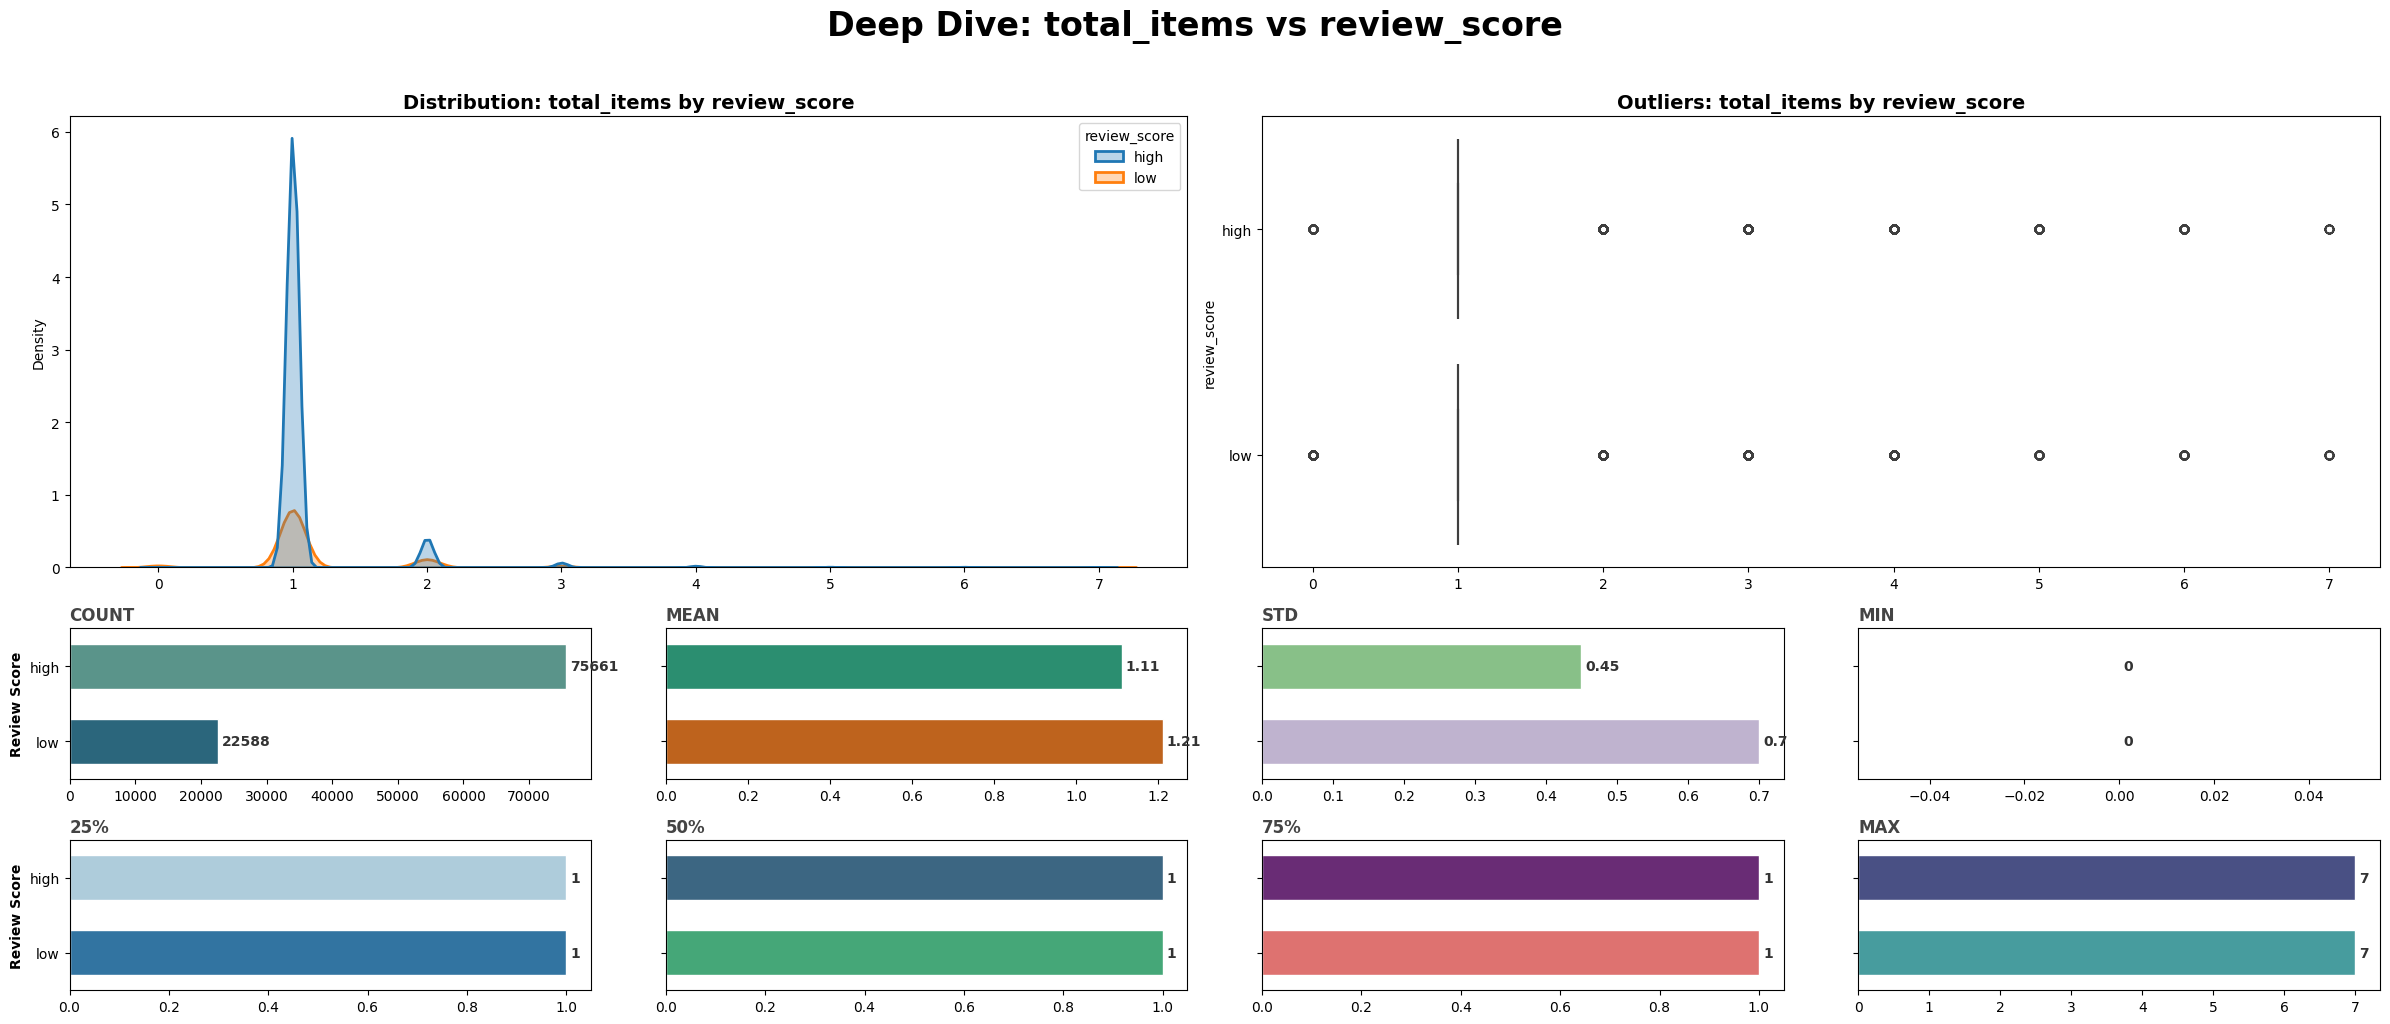

In [100]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'total_items','review_score')

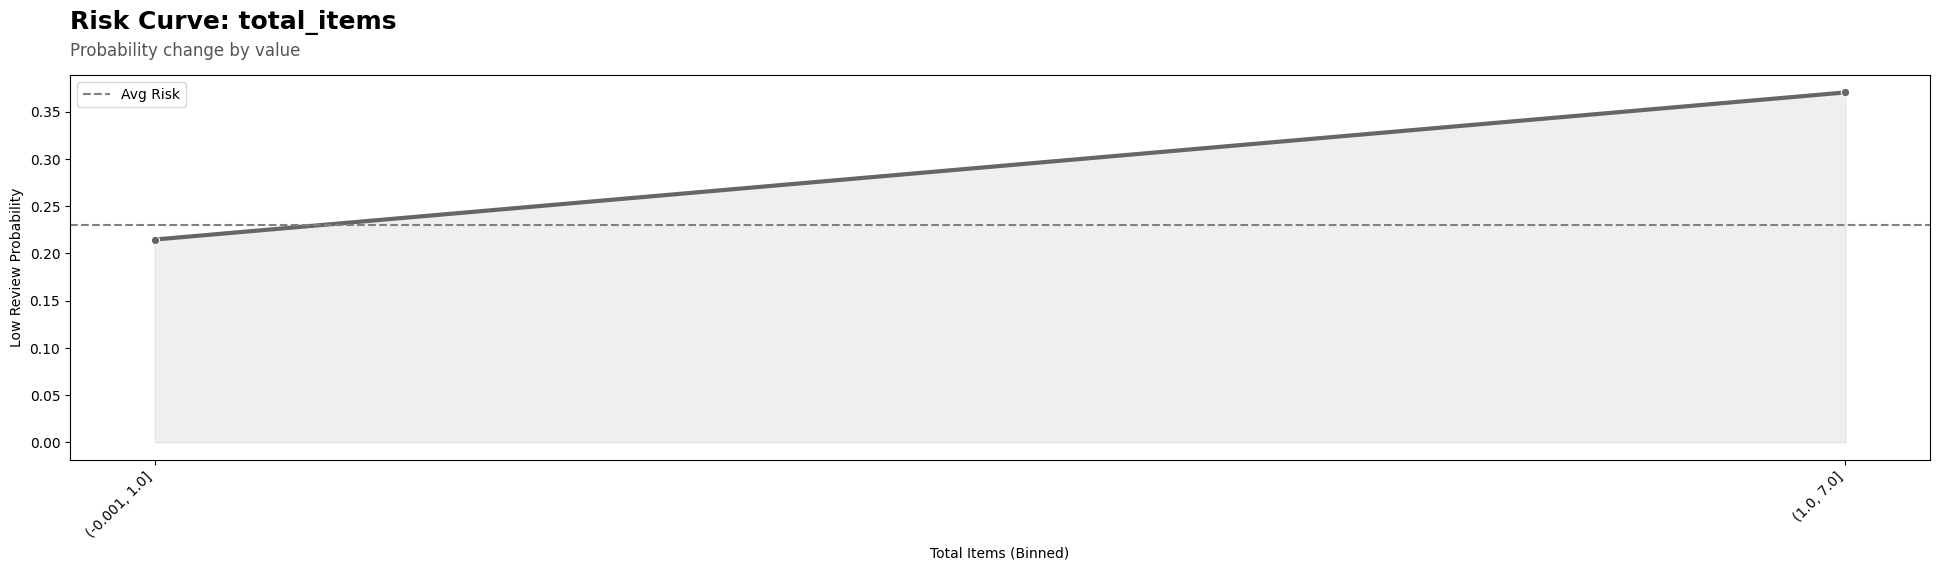

In [101]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'total_items','review_score',bins = 10)

In [102]:
S.compare_means(data,'review_score','total_items','low')


--- Comparing 'total_items' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.188)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


---
---
- ***By visuals we saw that `more the total items,more the low rating` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**total_order_value**

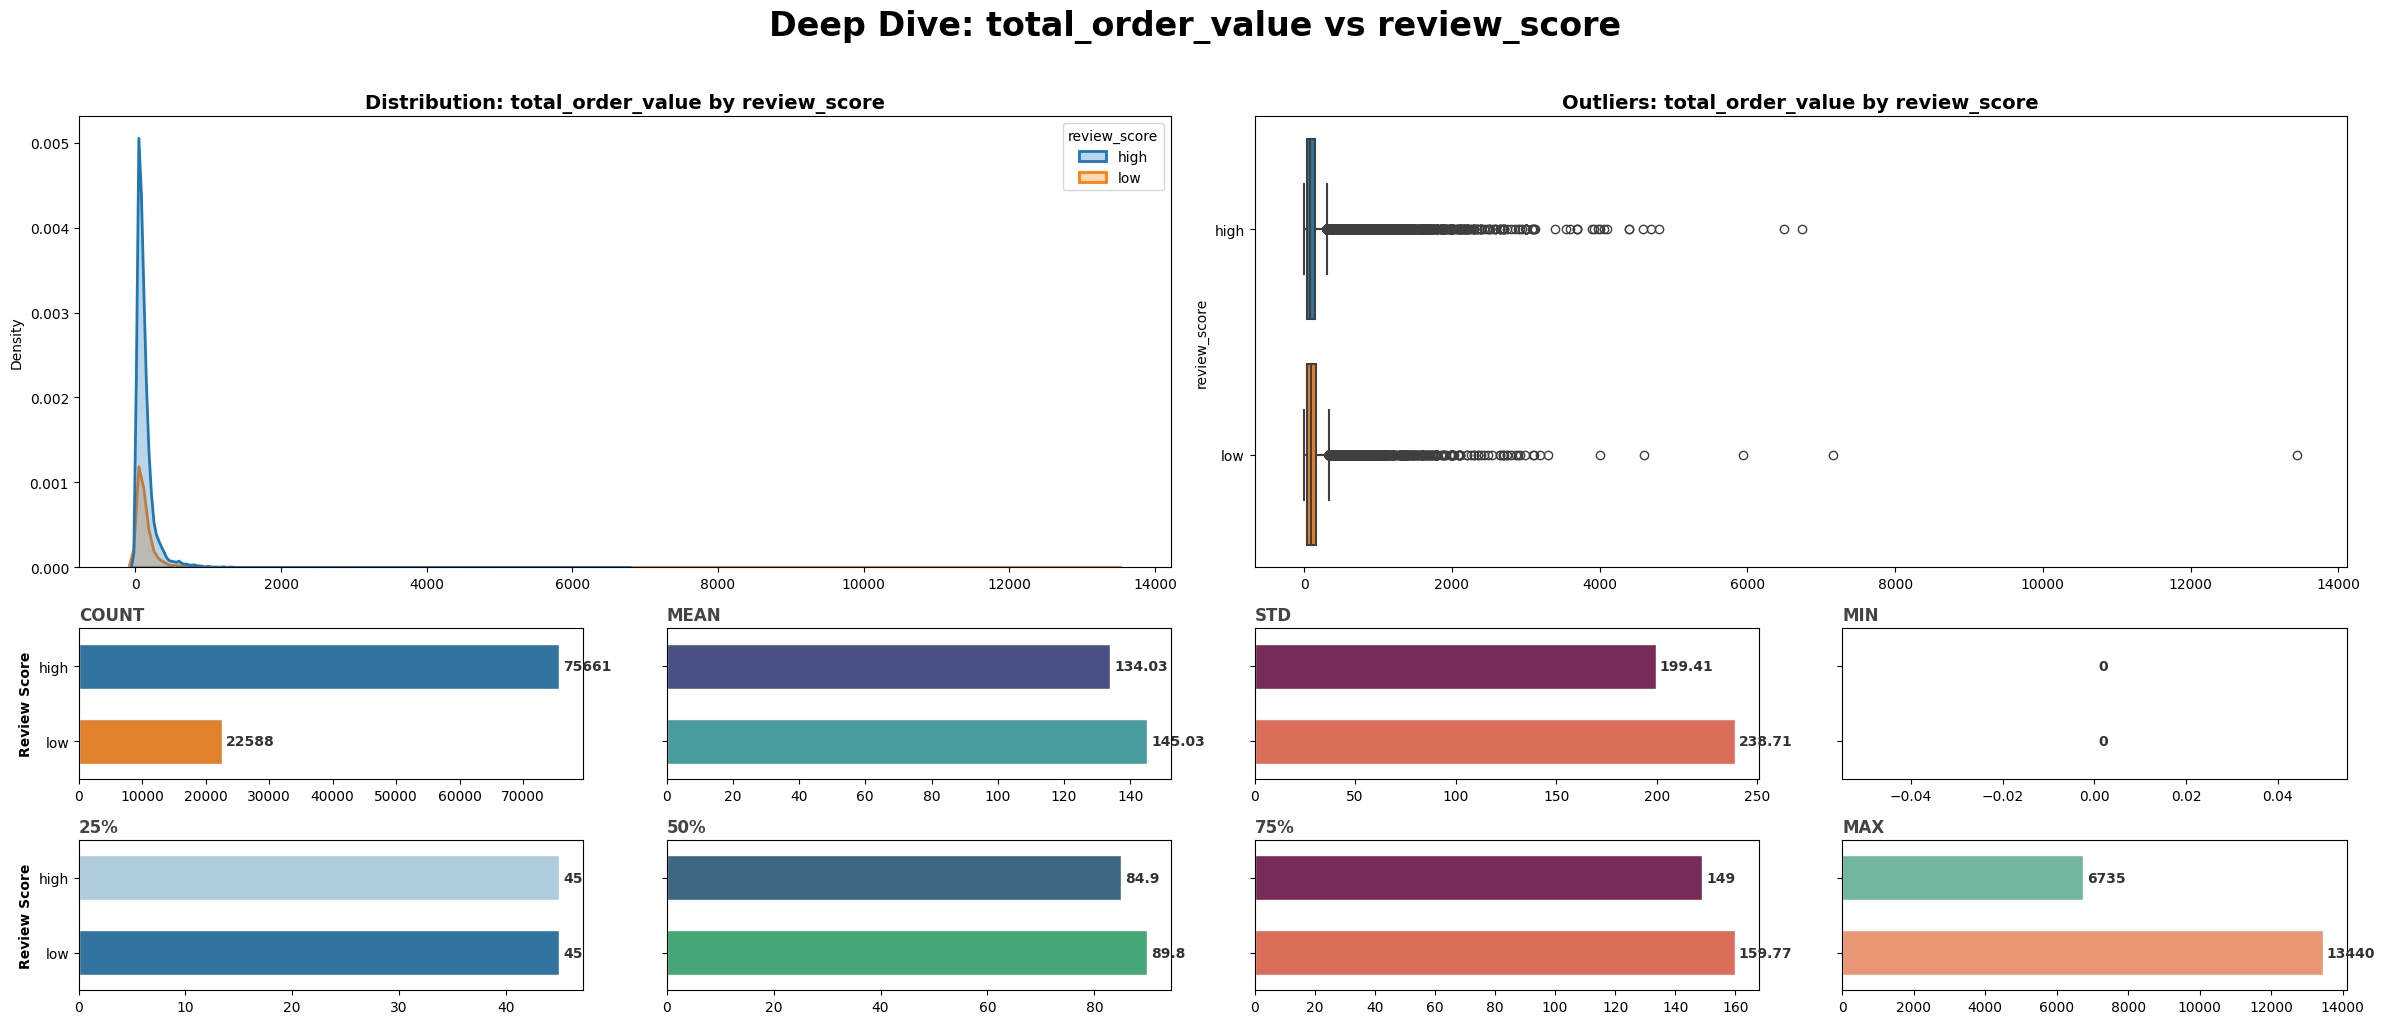

In [103]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'total_order_value','review_score')

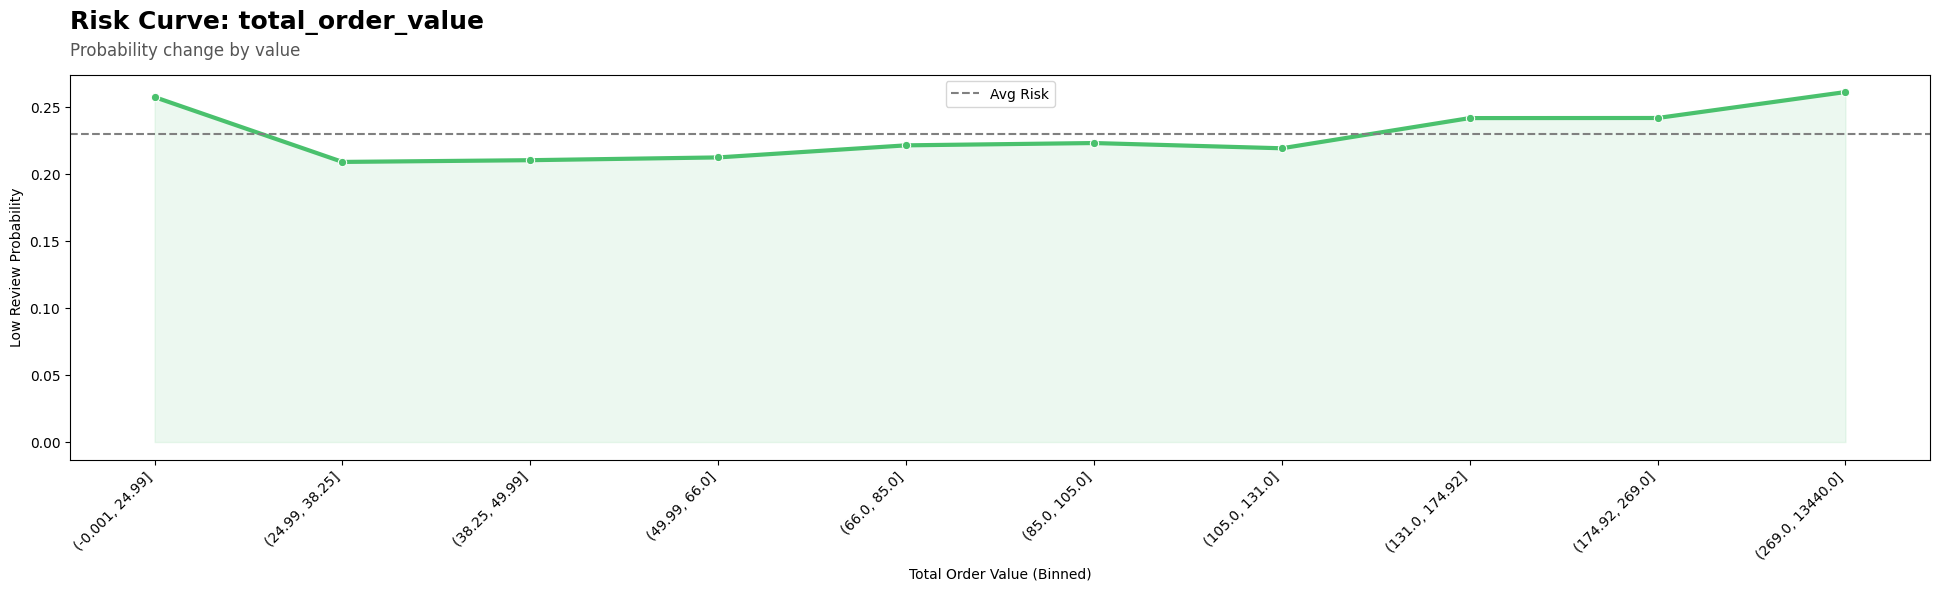

In [104]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'total_order_value','review_score',bins = 10)

In [109]:
total_order_value_groups = pd.cut(data['total_order_value'], 
                         bins=[-1, 40, 130,float('inf')], 
                         labels=['Crit Range','Medium','High'])

In [110]:
total_order_value_groups=total_order_value_groups.replace('High','Crit Range')

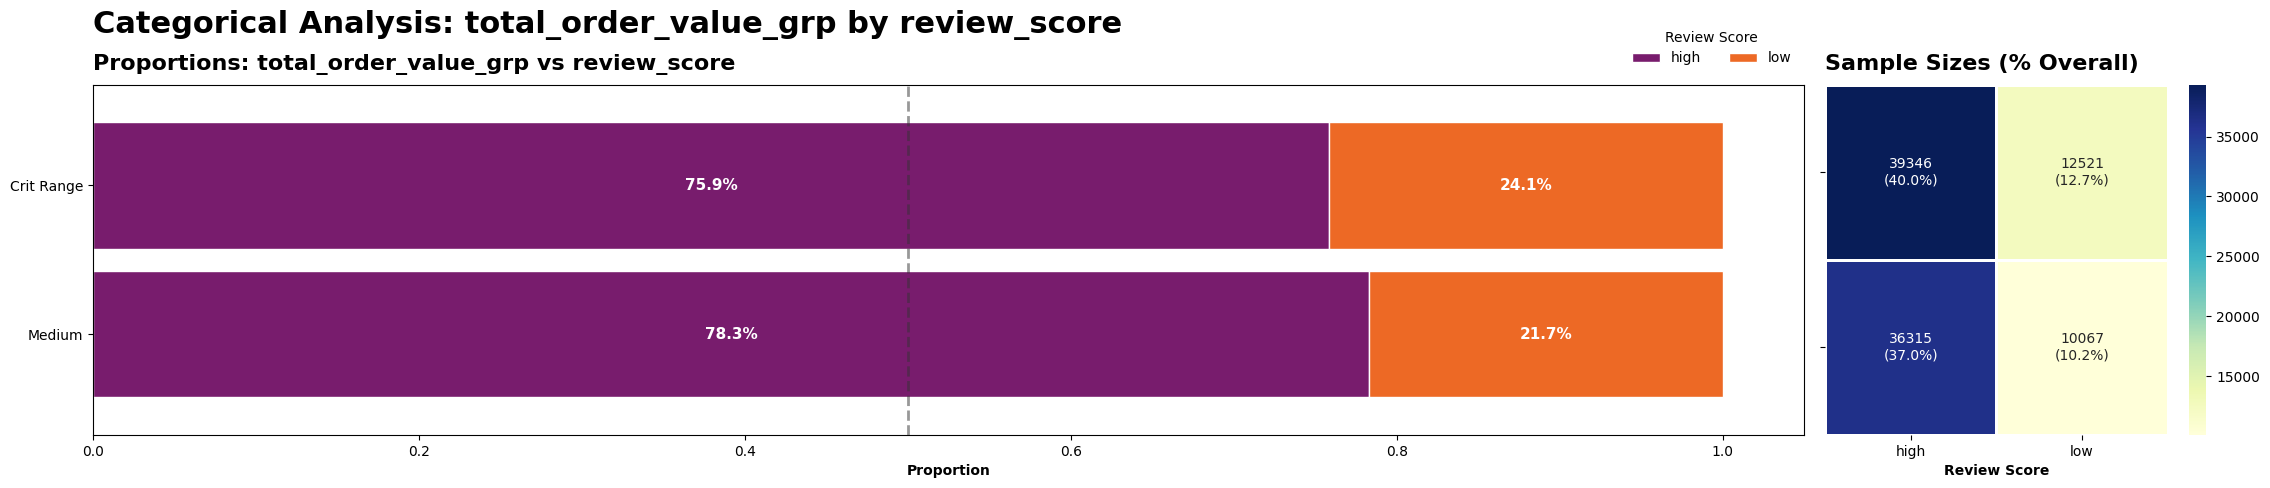

In [111]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(total_order_value_grp = total_order_value_groups),'total_order_value_grp','review_score')

In [112]:
ct = pd.crosstab(total_order_value_groups,data['review_score'])
S.test_association(ct)


--- Association Test: total_order_value vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.029)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [113]:
S.compare_means(data,'review_score','total_order_value','low')


--- Comparing 'total_order_value' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Negligible (Cohen's d = 0.053)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


---
---
- ***By visuals we saw that `there is no linear relationship with total_order_value and review score, but order value less than 40(lower values) and more than 130(higher values) have a little more lower ratings` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**total_freight**

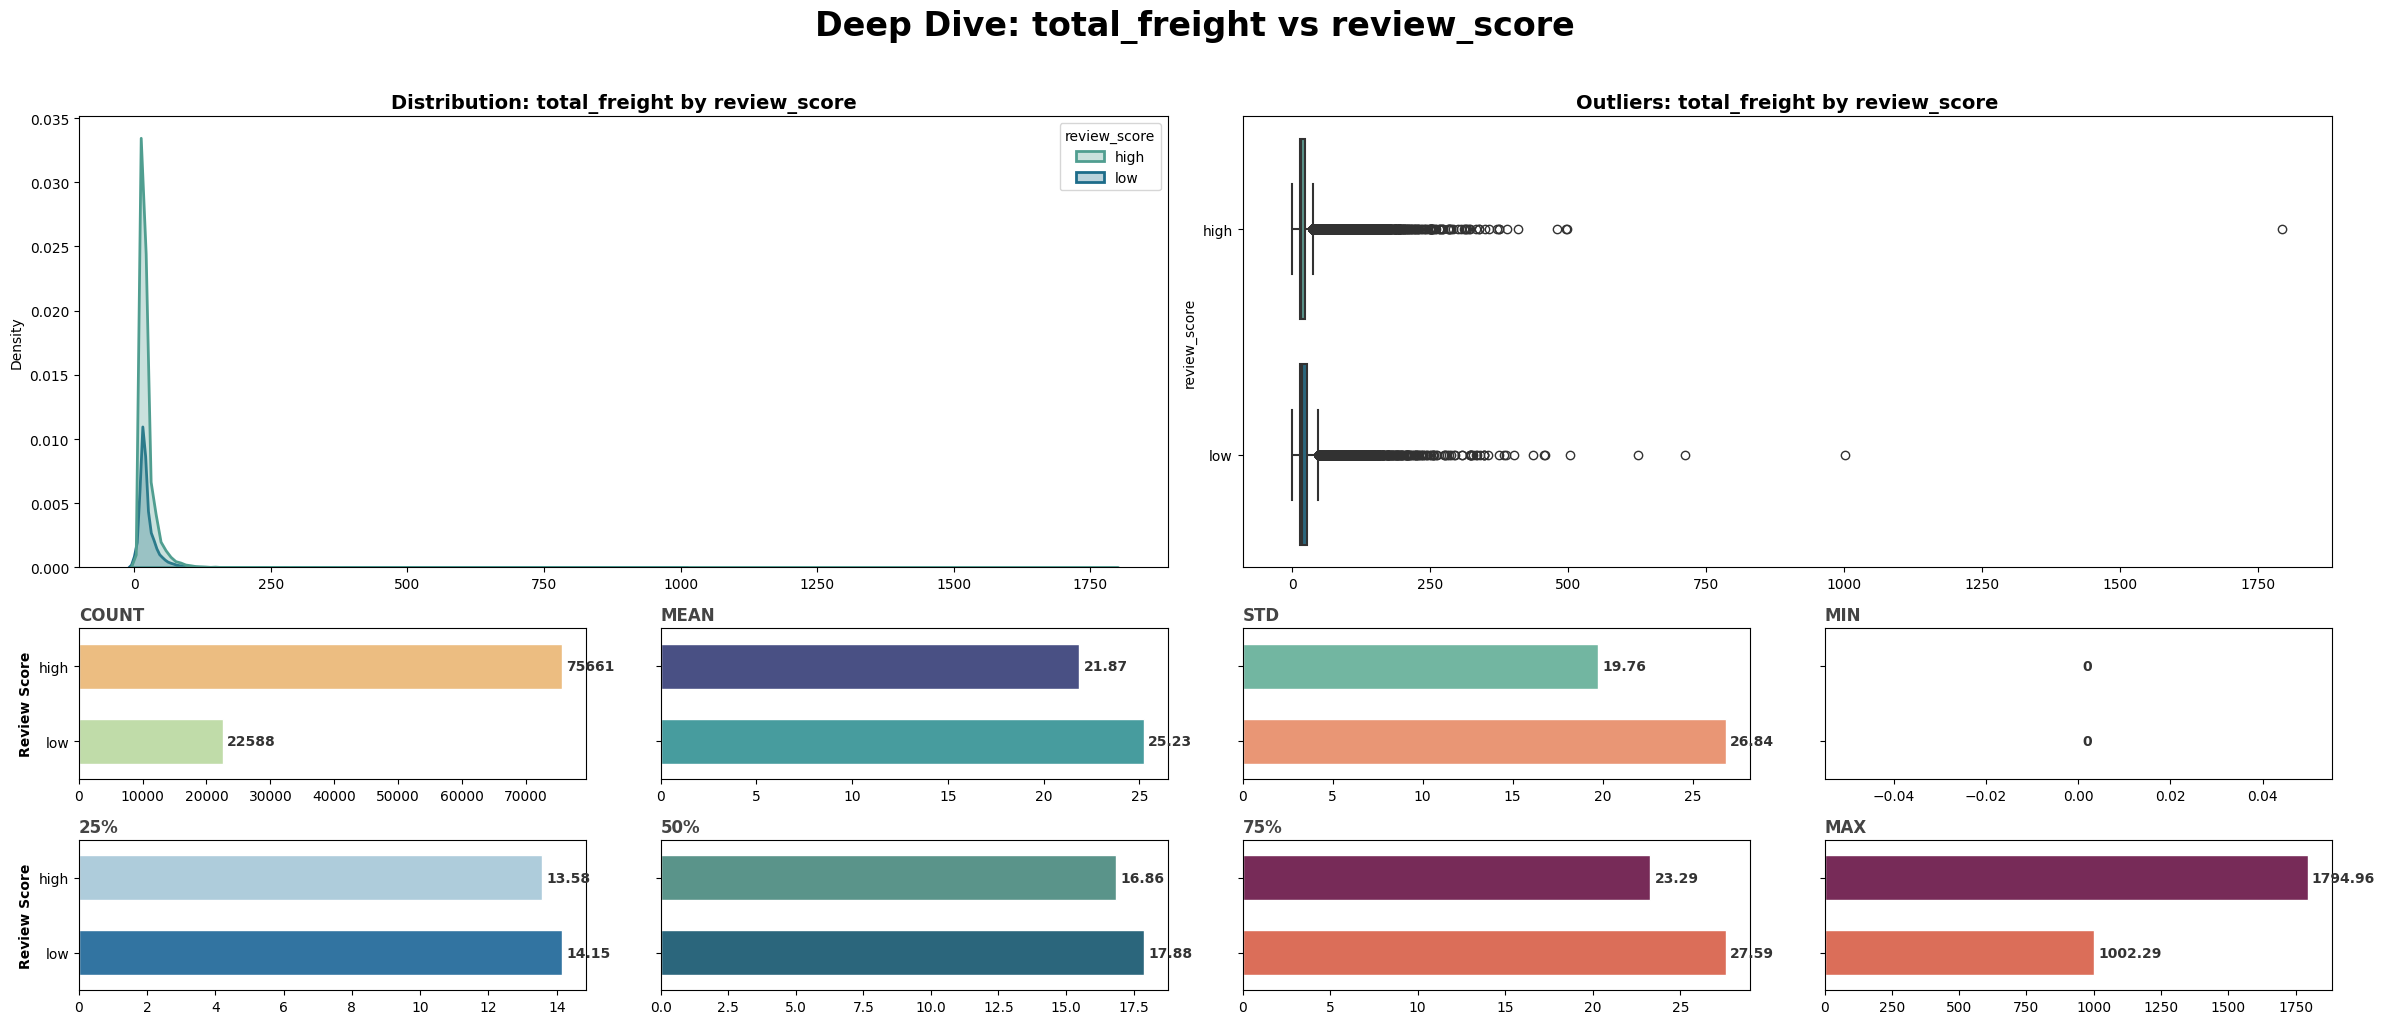

In [114]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'total_freight','review_score')

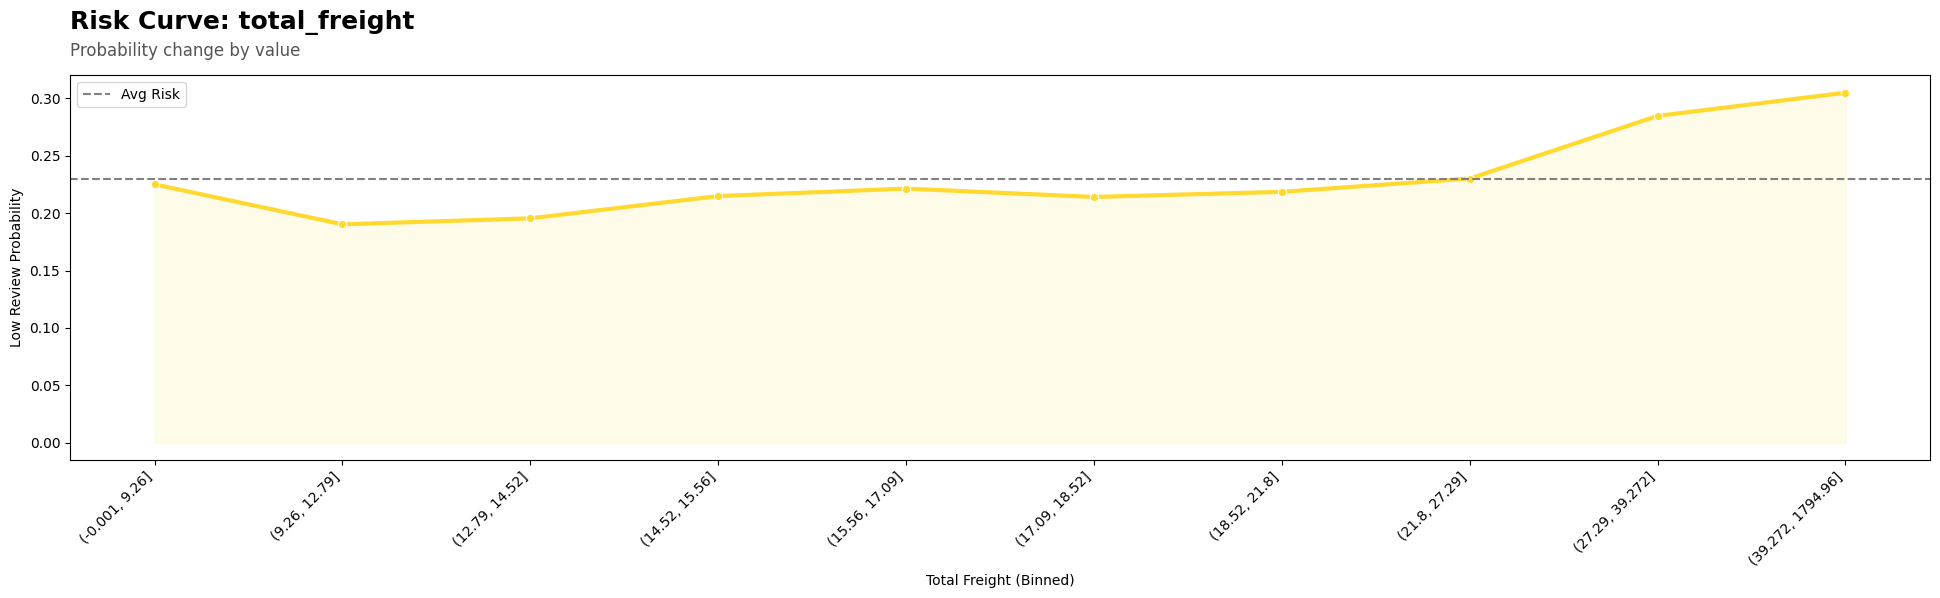

In [117]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'total_freight','review_score',bins = 10)

In [122]:
total_freight_group = pd.cut(data['total_freight'], 
                    bins=[-1, 27,float('inf')], 
                    labels=['Low','High'])

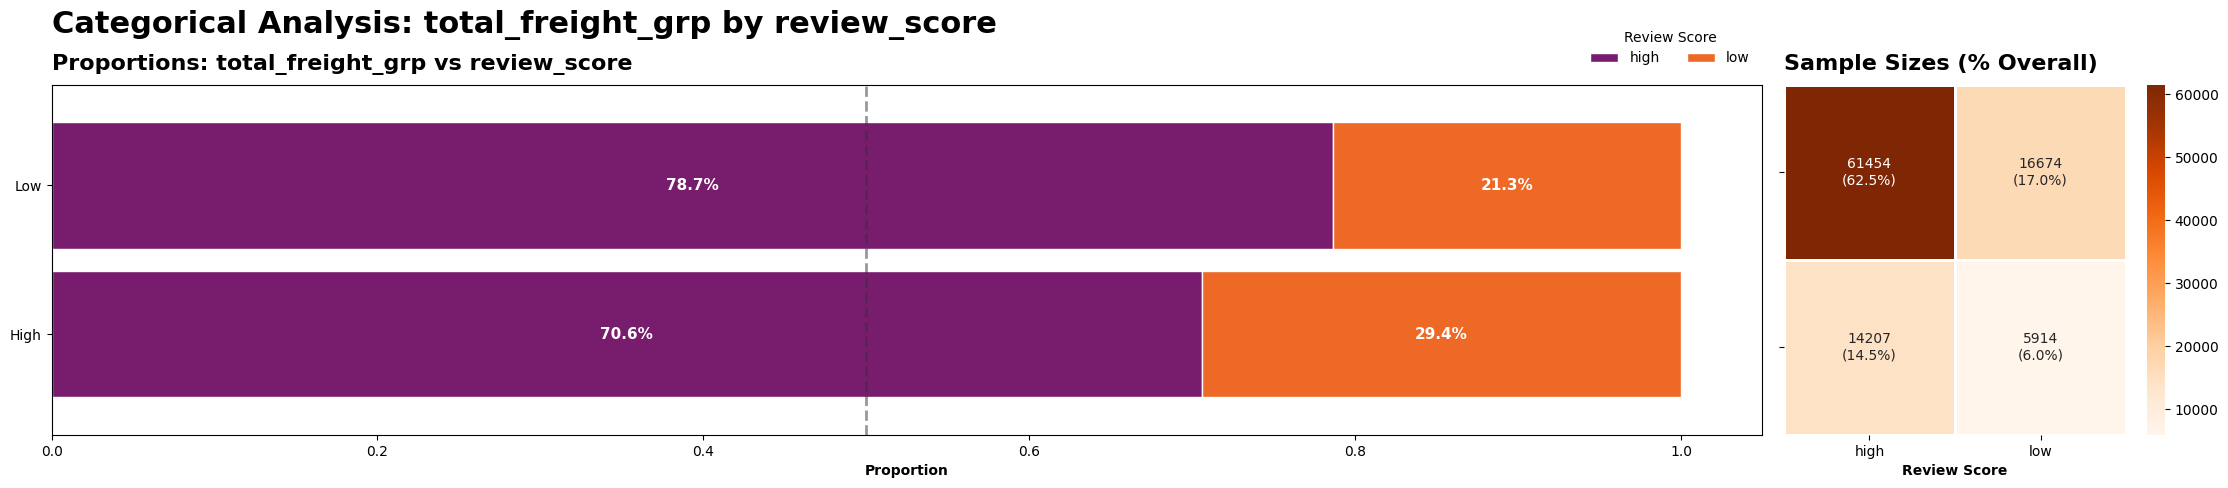

In [123]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(total_freight_grp = total_freight_group),'total_freight_grp','review_score')

In [124]:
ct = pd.crosstab(total_freight_group,data['review_score'])
S.test_association(ct)


--- Association Test: total_freight vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.077)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [125]:
S.compare_means(data,'review_score','total_freight','low')


--- Comparing 'total_freight' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.156)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


---
---
- ***By visuals we saw that `there is linear reationship between total_freight and review_score, and also freight value after 27 is getting comparatively more low ratings` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**avg_price**

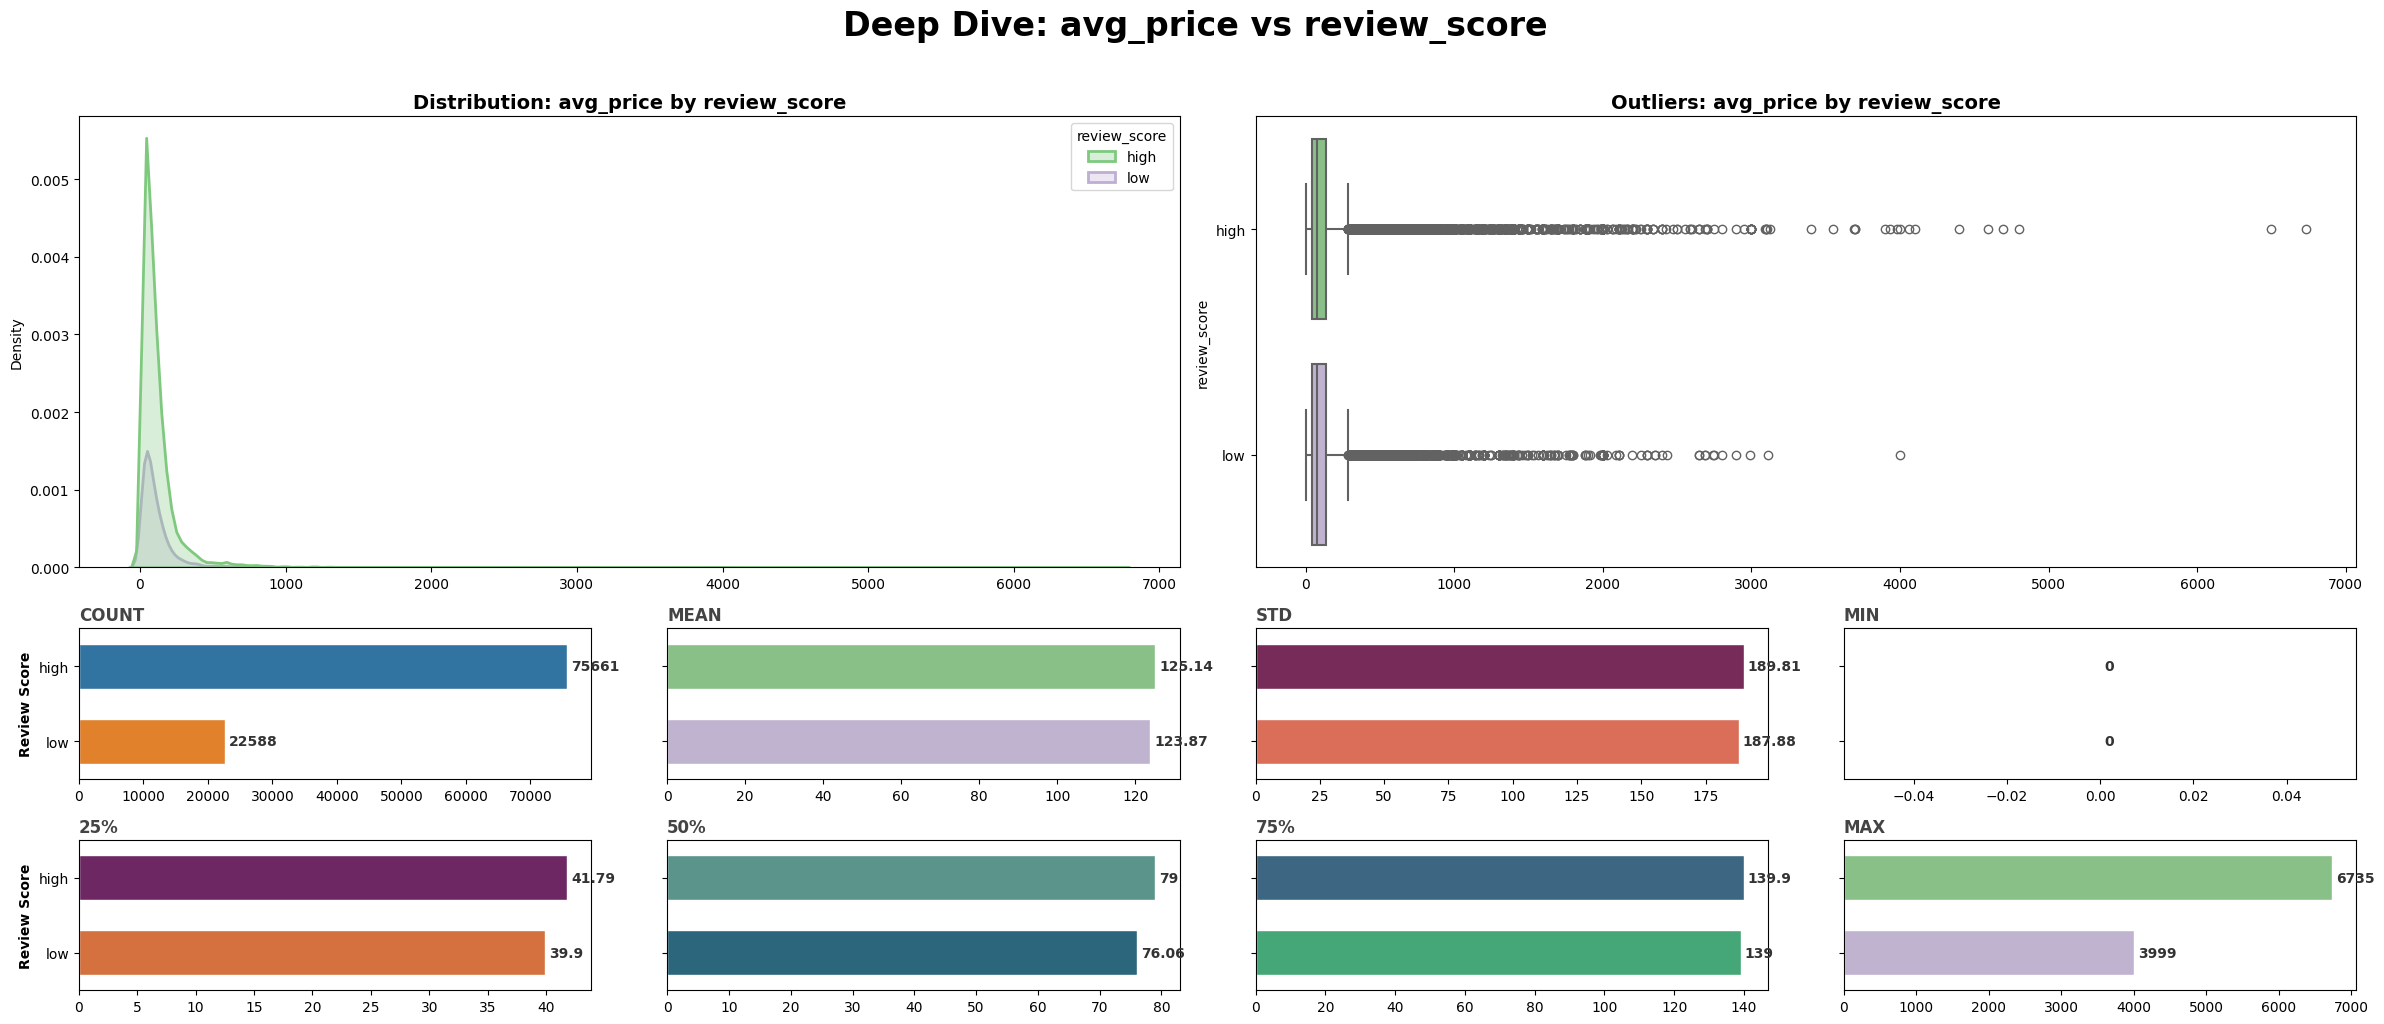

In [126]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'avg_price','review_score')

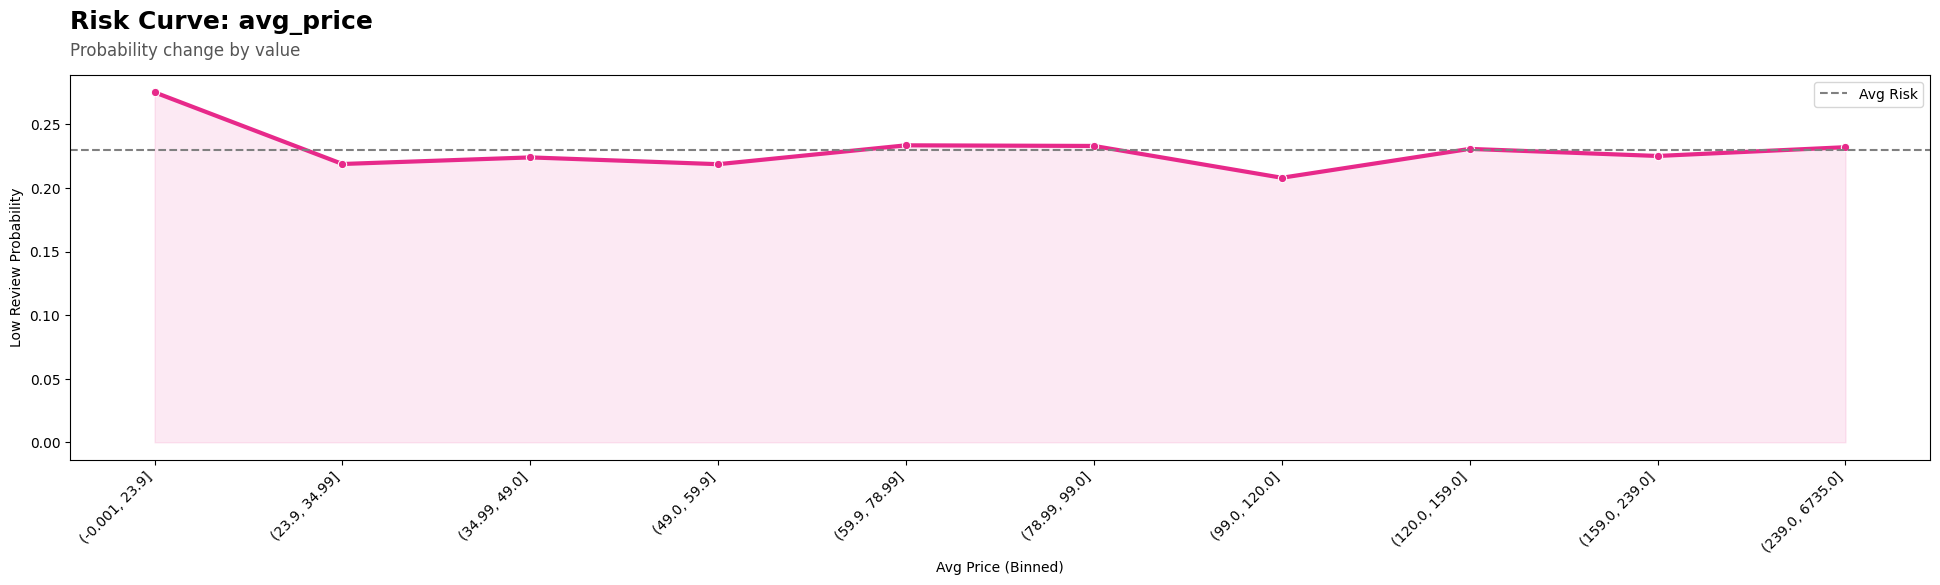

In [127]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'avg_price','review_score',bins = 10)

In [128]:
avg_price_groups = pd.cut(data['avg_price'], 
                         bins=[-1, 35, float('inf')], 
                         labels=['Low','High'])

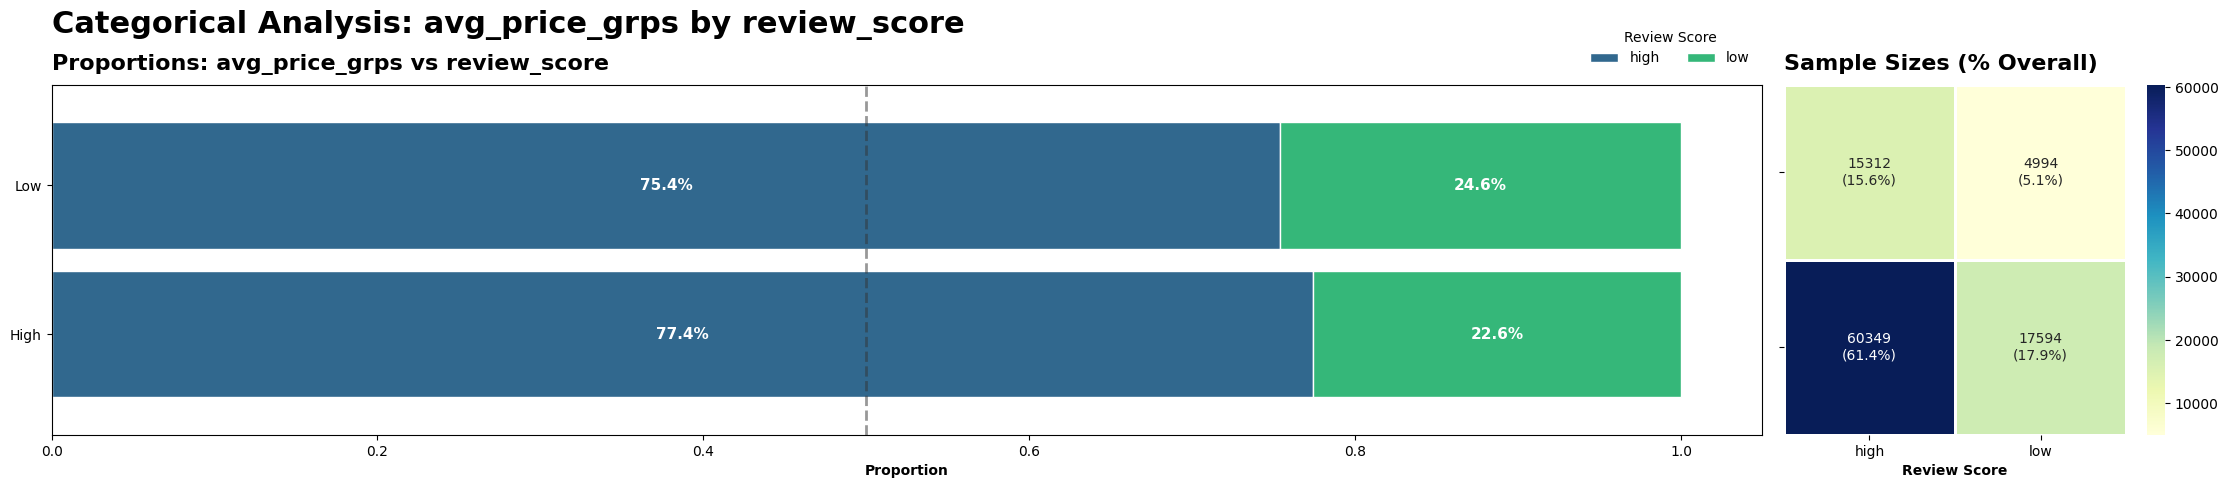

In [129]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(avg_price_grps = avg_price_groups),'avg_price_grps','review_score')

In [134]:
S.compare_means(data,'review_score','avg_price','low')


--- Comparing 'avg_price' by 'review_score' (low vs Others) ---
1. Verdict:    ❌ NOT Significant (p=0.37662)
2. Strength:   Negligible (Cohen's d = -0.007)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


In [131]:
ct = pd.crosstab(avg_price_groups,data['review_score'])
S.test_association(ct)


--- Association Test: avg_price vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.019)
3. Balance:    Robust (High N)
------------------------------------------------------------


- ***we do not find anything specific***

**avg_freight**

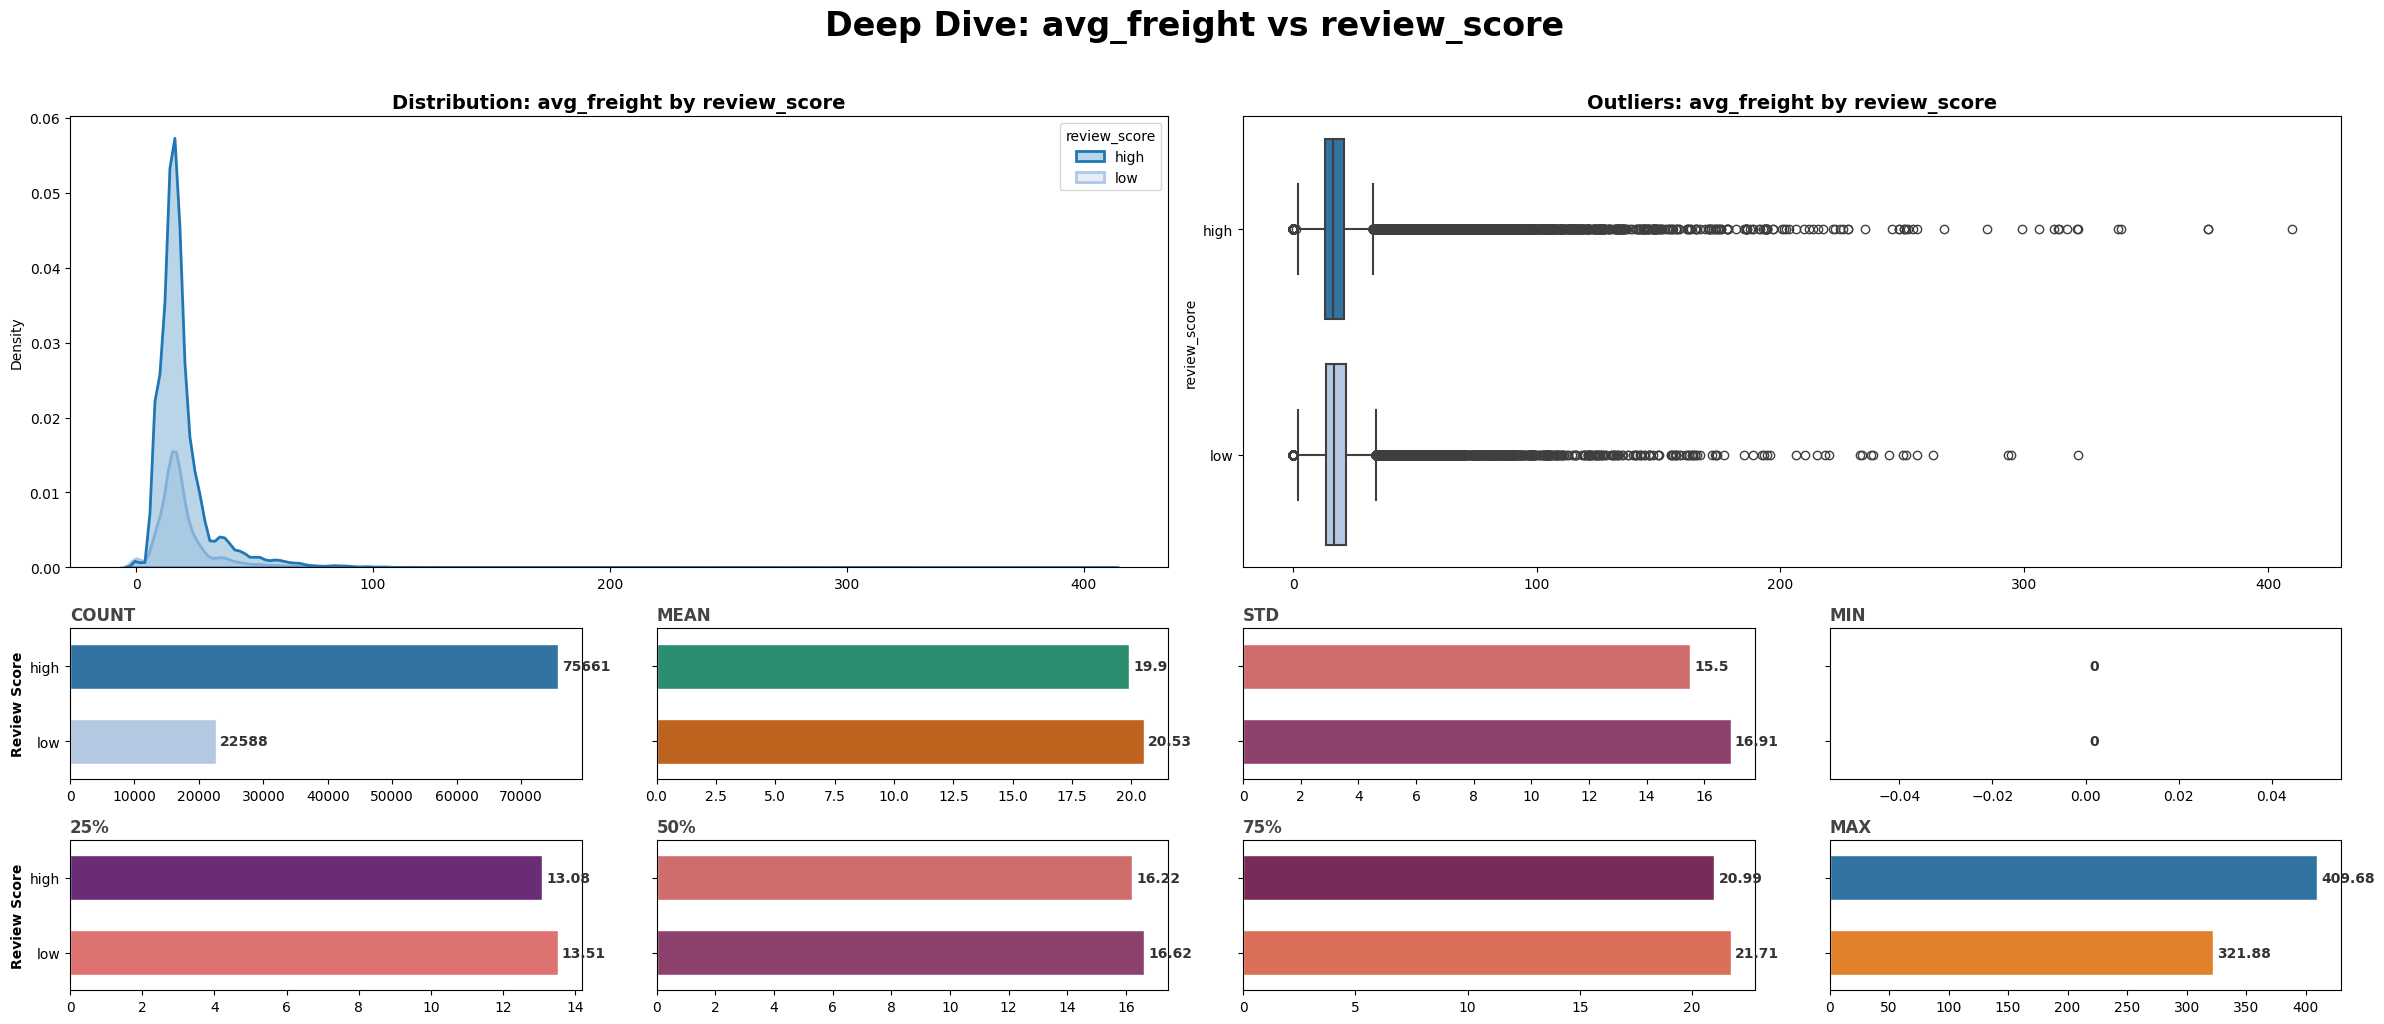

In [132]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'avg_freight','review_score')

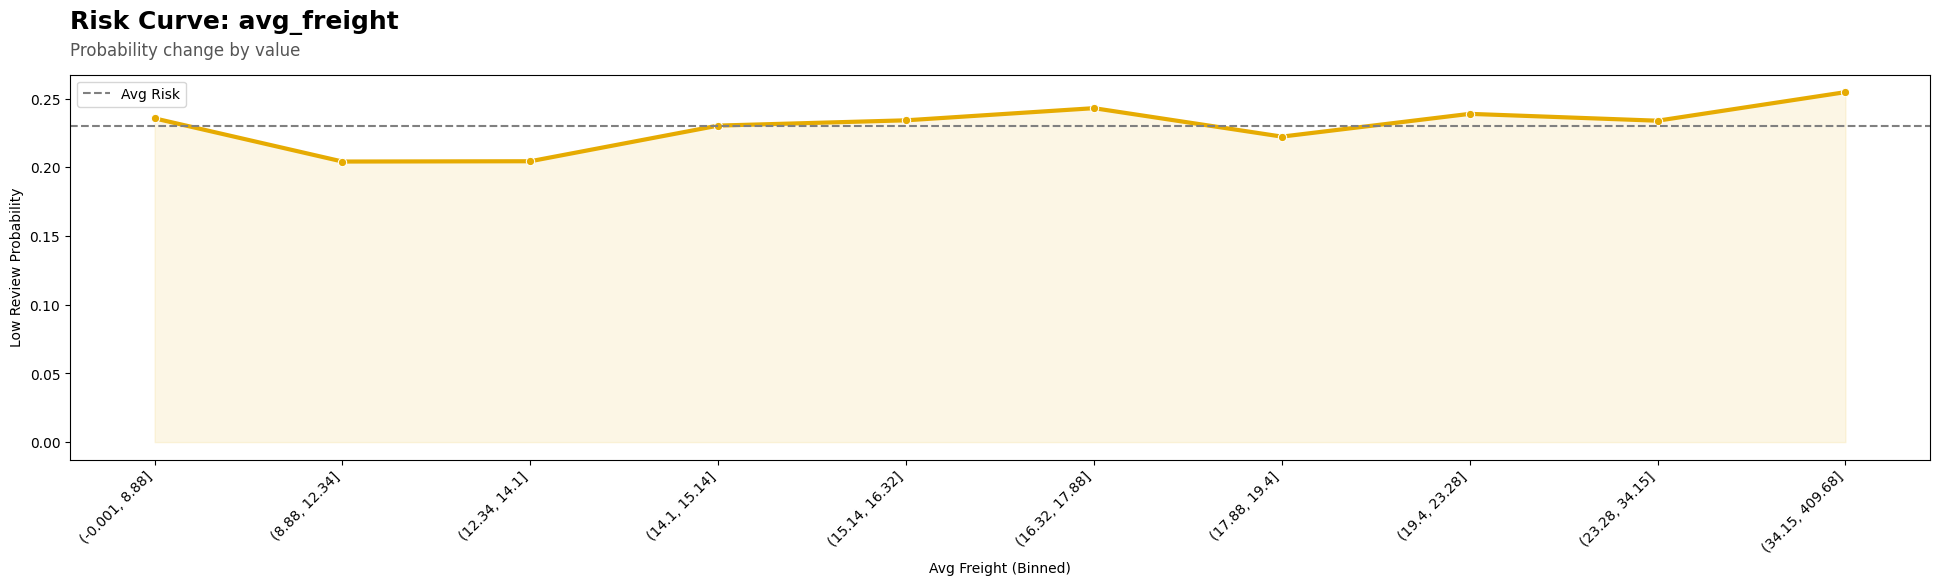

In [133]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'avg_freight','review_score')

In [136]:
avg_freight_groups = pd.cut(data['avg_freight'], 
                         bins=[-1,12,16, float('inf')], 
                         labels=['Normal','Crit Zone','High'])

In [138]:
avg_freight_groups=avg_freight_groups.replace('High','Normal')

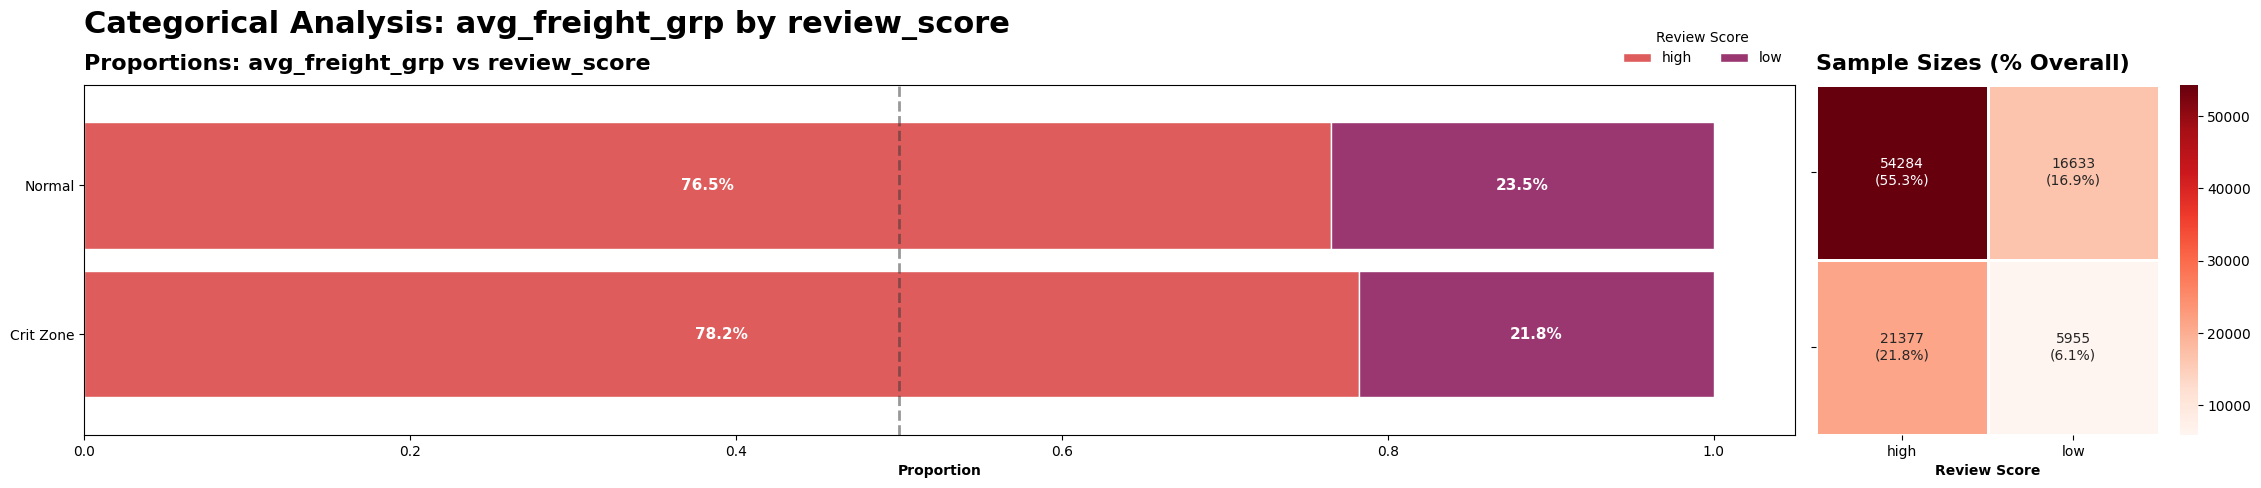

In [141]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(avg_freight_grp = avg_freight_groups),'avg_freight_grp','review_score')

In [140]:
ct = pd.crosstab(avg_freight_groups,data['review_score'])
S.test_association(ct)


--- Association Test: avg_freight vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.018)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [135]:
S.compare_means(data,'review_score','avg_freight','low')


--- Comparing 'avg_freight' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Negligible (Cohen's d = 0.040)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


- ***we do not find anything specific***

**installment_duration**

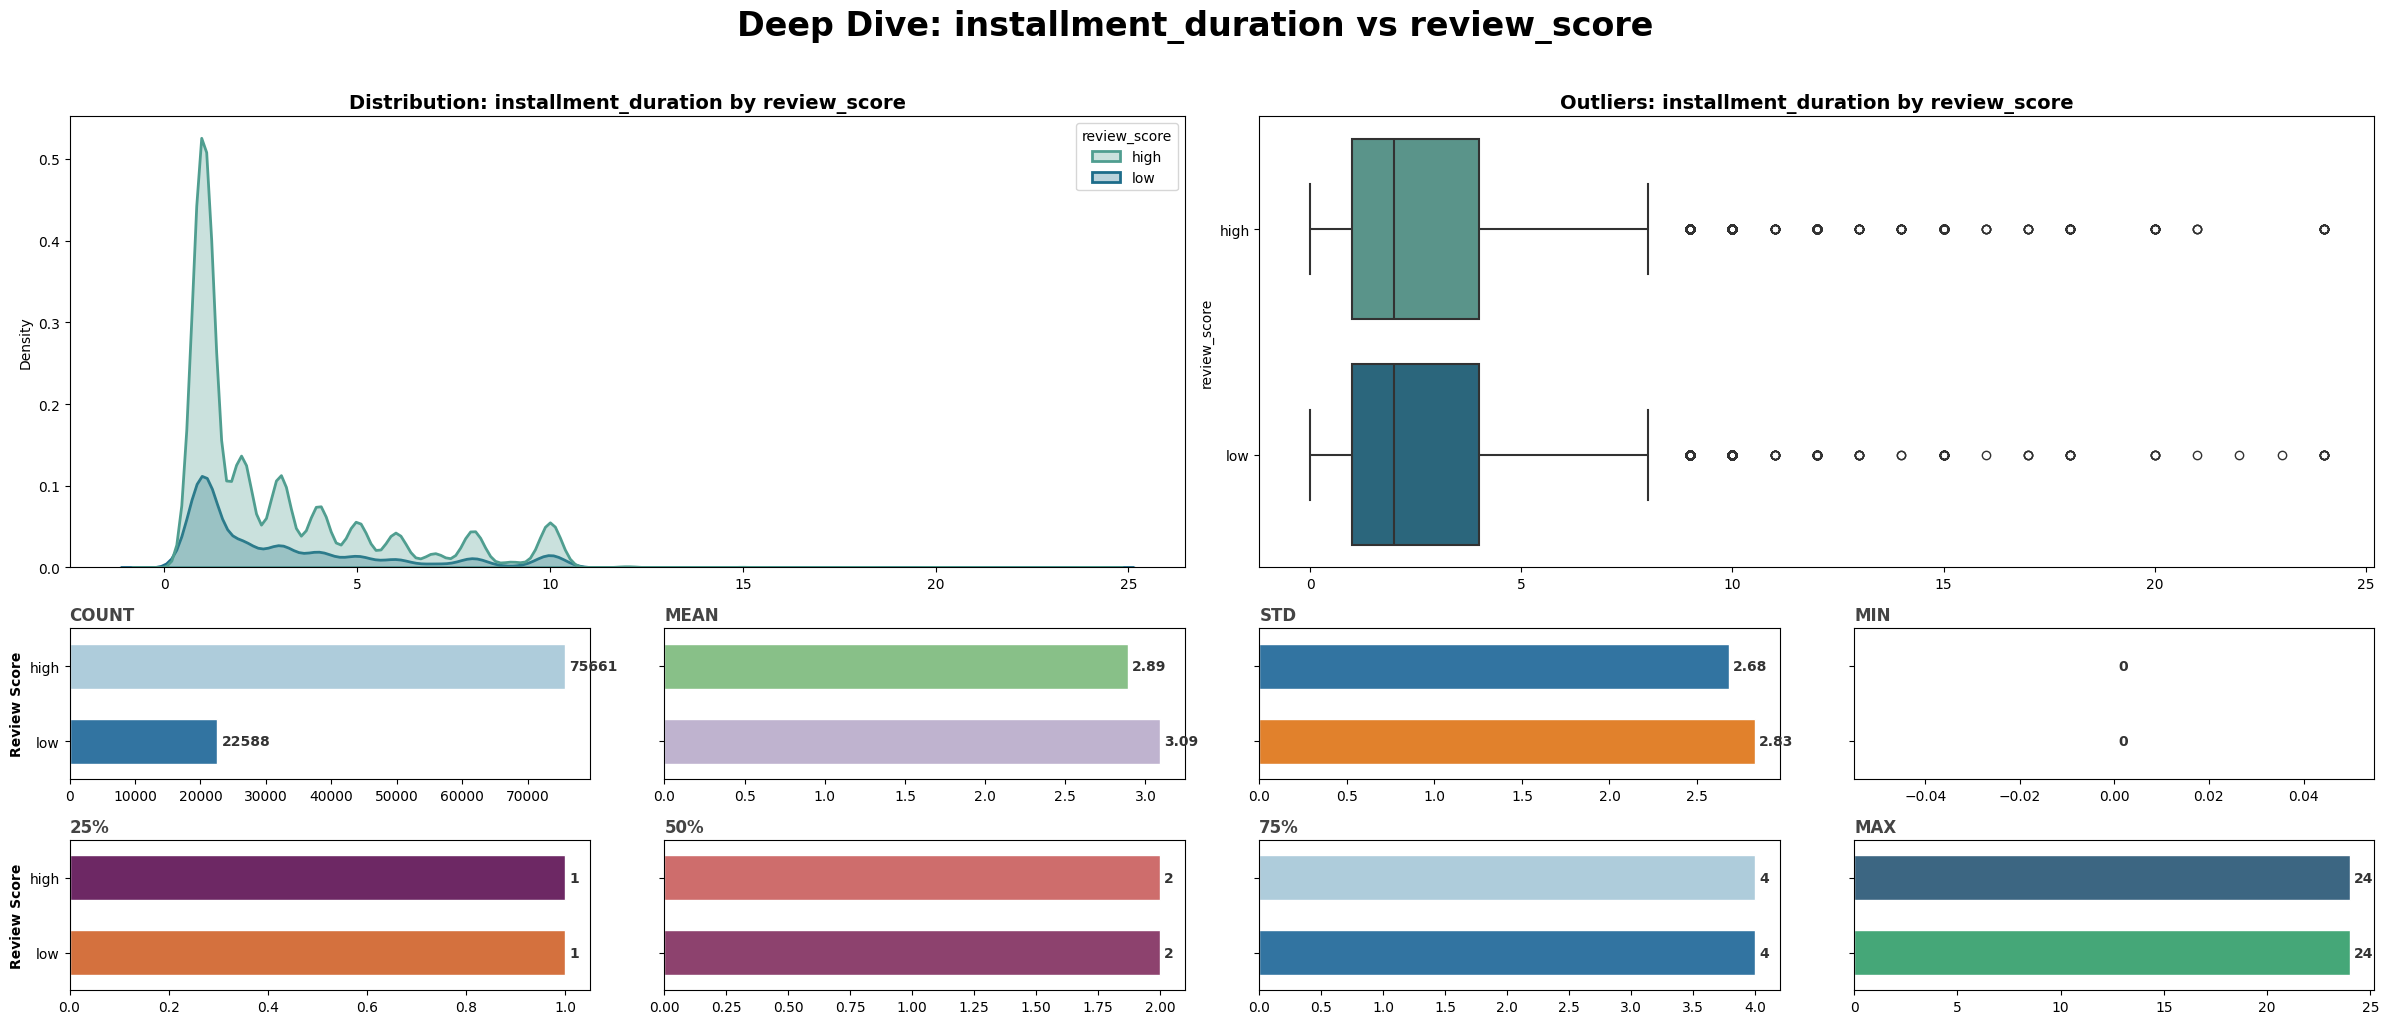

In [142]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'installment_duration','review_score')

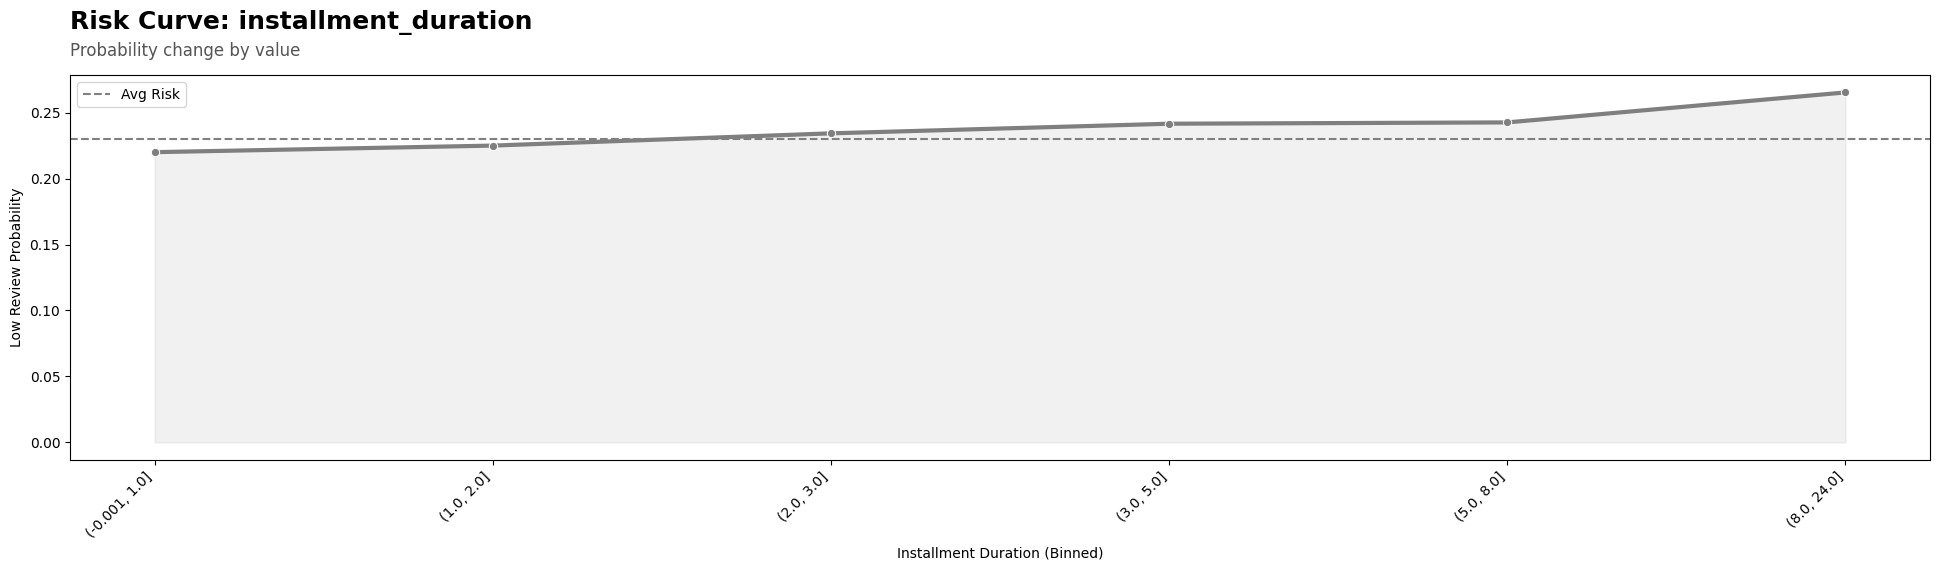

In [143]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'installment_duration','review_score')

In [144]:
installment_duration_groups = pd.cut(data['installment_duration'], 
                         bins=[-1, 1, float('inf')], 
                         labels=['Single','Multiple'])

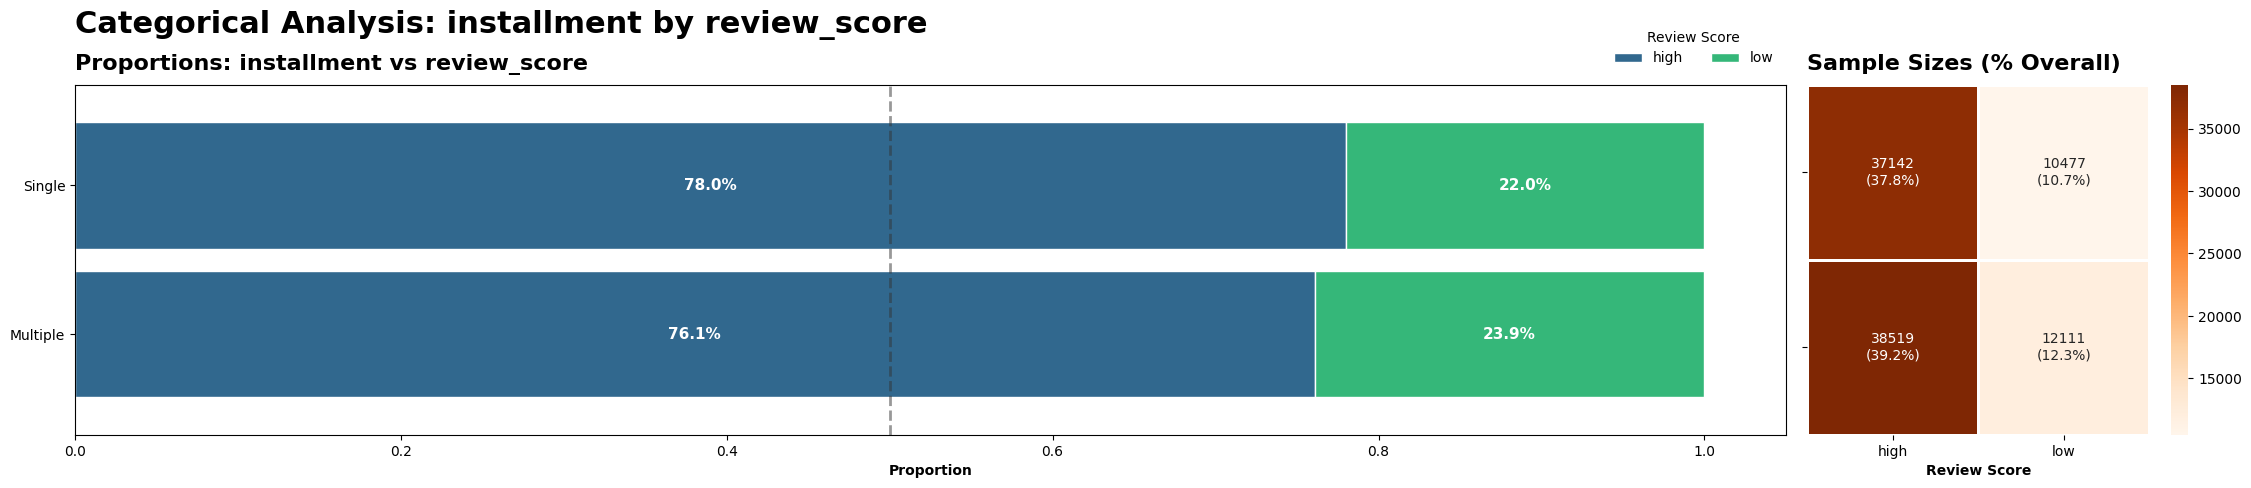

In [145]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(installment = installment_duration_groups),'installment','review_score')

In [146]:
S.compare_means(data,'review_score','installment_duration','low')


--- Comparing 'installment_duration' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Negligible (Cohen's d = 0.072)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


In [147]:
ct = pd.crosstab(installment_duration_groups,data['review_score'])
S.test_association(ct)


--- Association Test: installment_duration vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.023)
3. Balance:    Robust (High N)
------------------------------------------------------------


- ***we dont find anything specific from installment duration***

**total_paid_value**

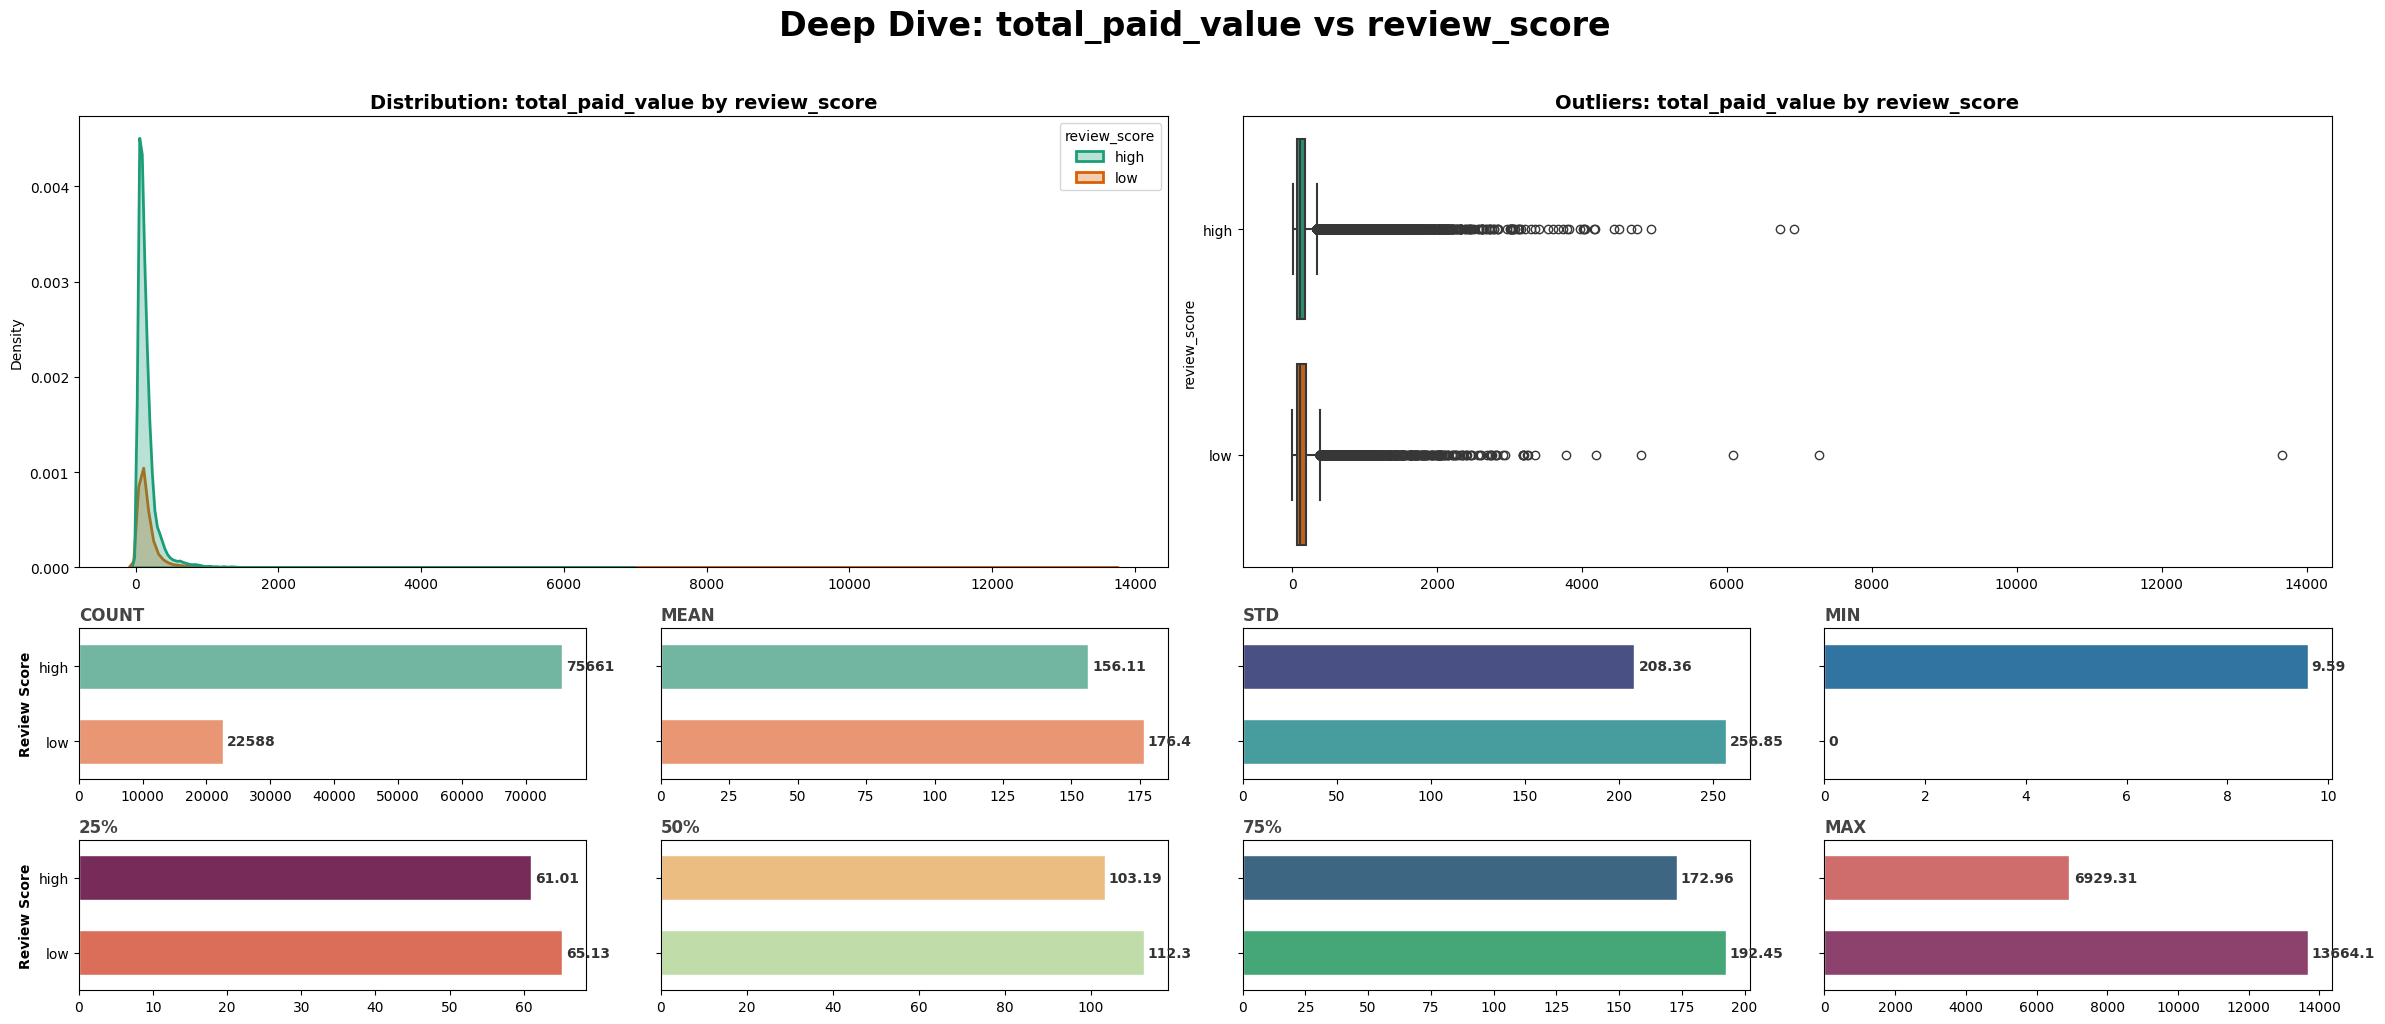

In [148]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'total_paid_value','review_score')

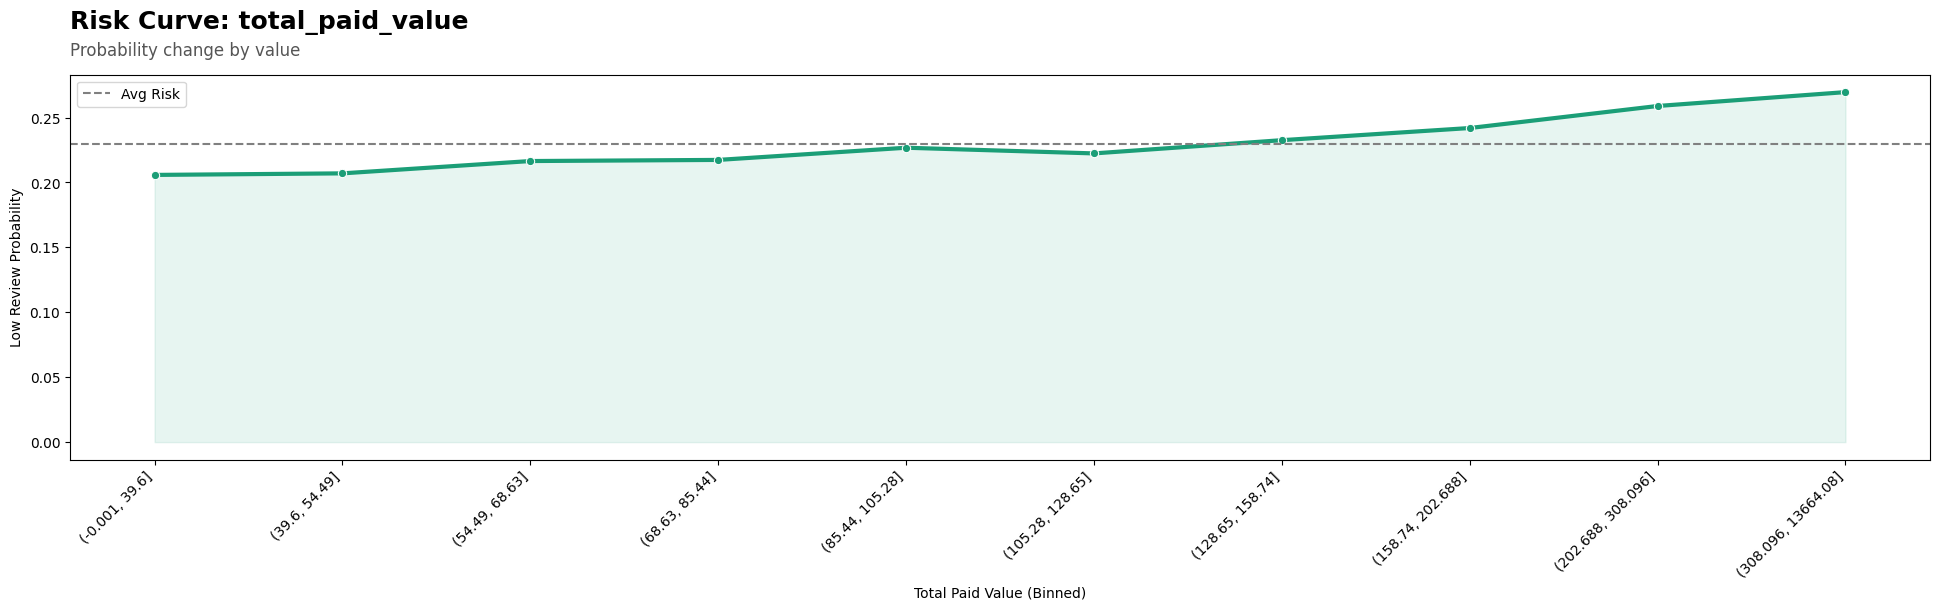

In [149]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'total_paid_value','review_score')

In [150]:
total_paid_value_groups = pd.cut(data['total_paid_value'], 
                         bins=[-1, 100, float('inf')], 
                         labels=['High','Low'])

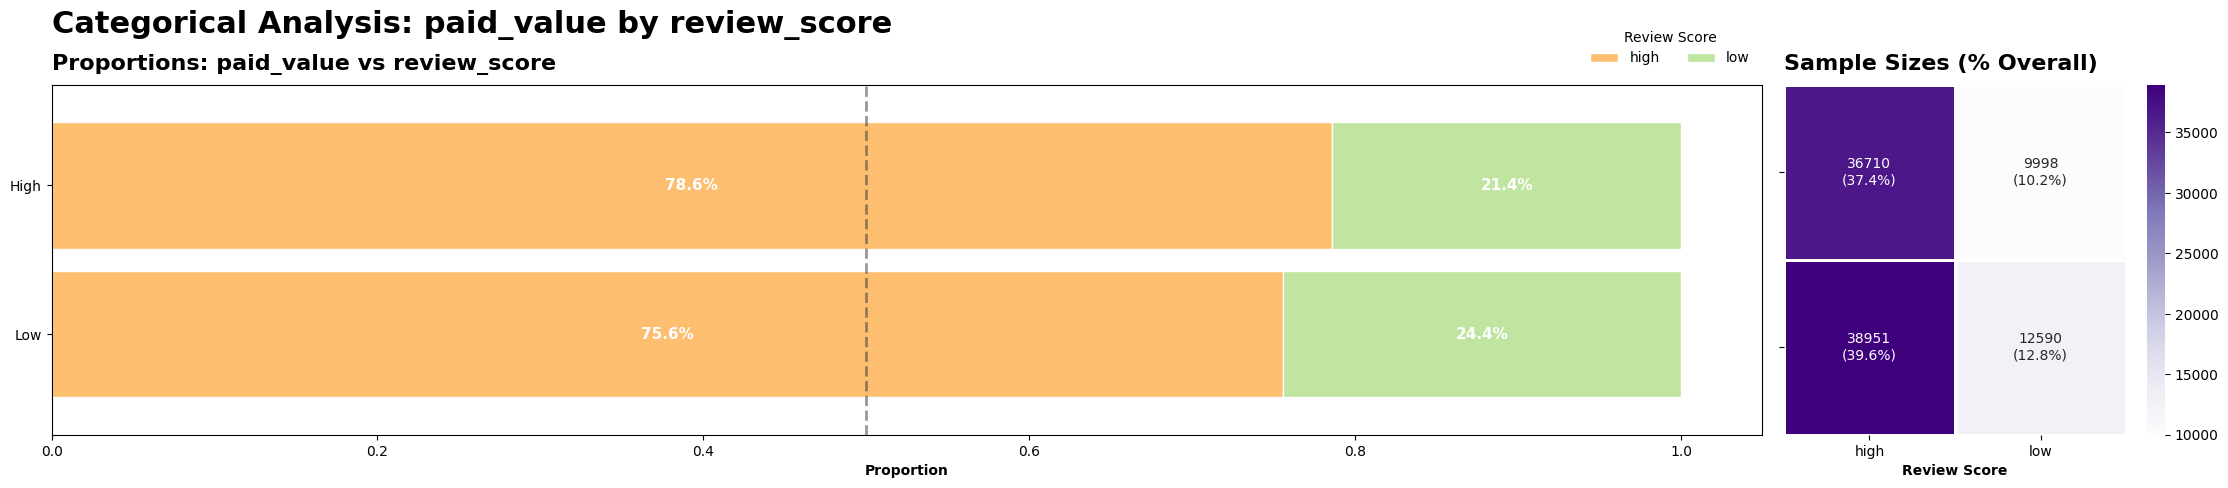

In [151]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(paid_value = total_paid_value_groups),'paid_value','review_score')

In [153]:
S.compare_means(data,'review_score','total_paid_value','low')


--- Comparing 'total_paid_value' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Negligible (Cohen's d = 0.092)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


- ***we do not find anything specific***

**approval_time_days**

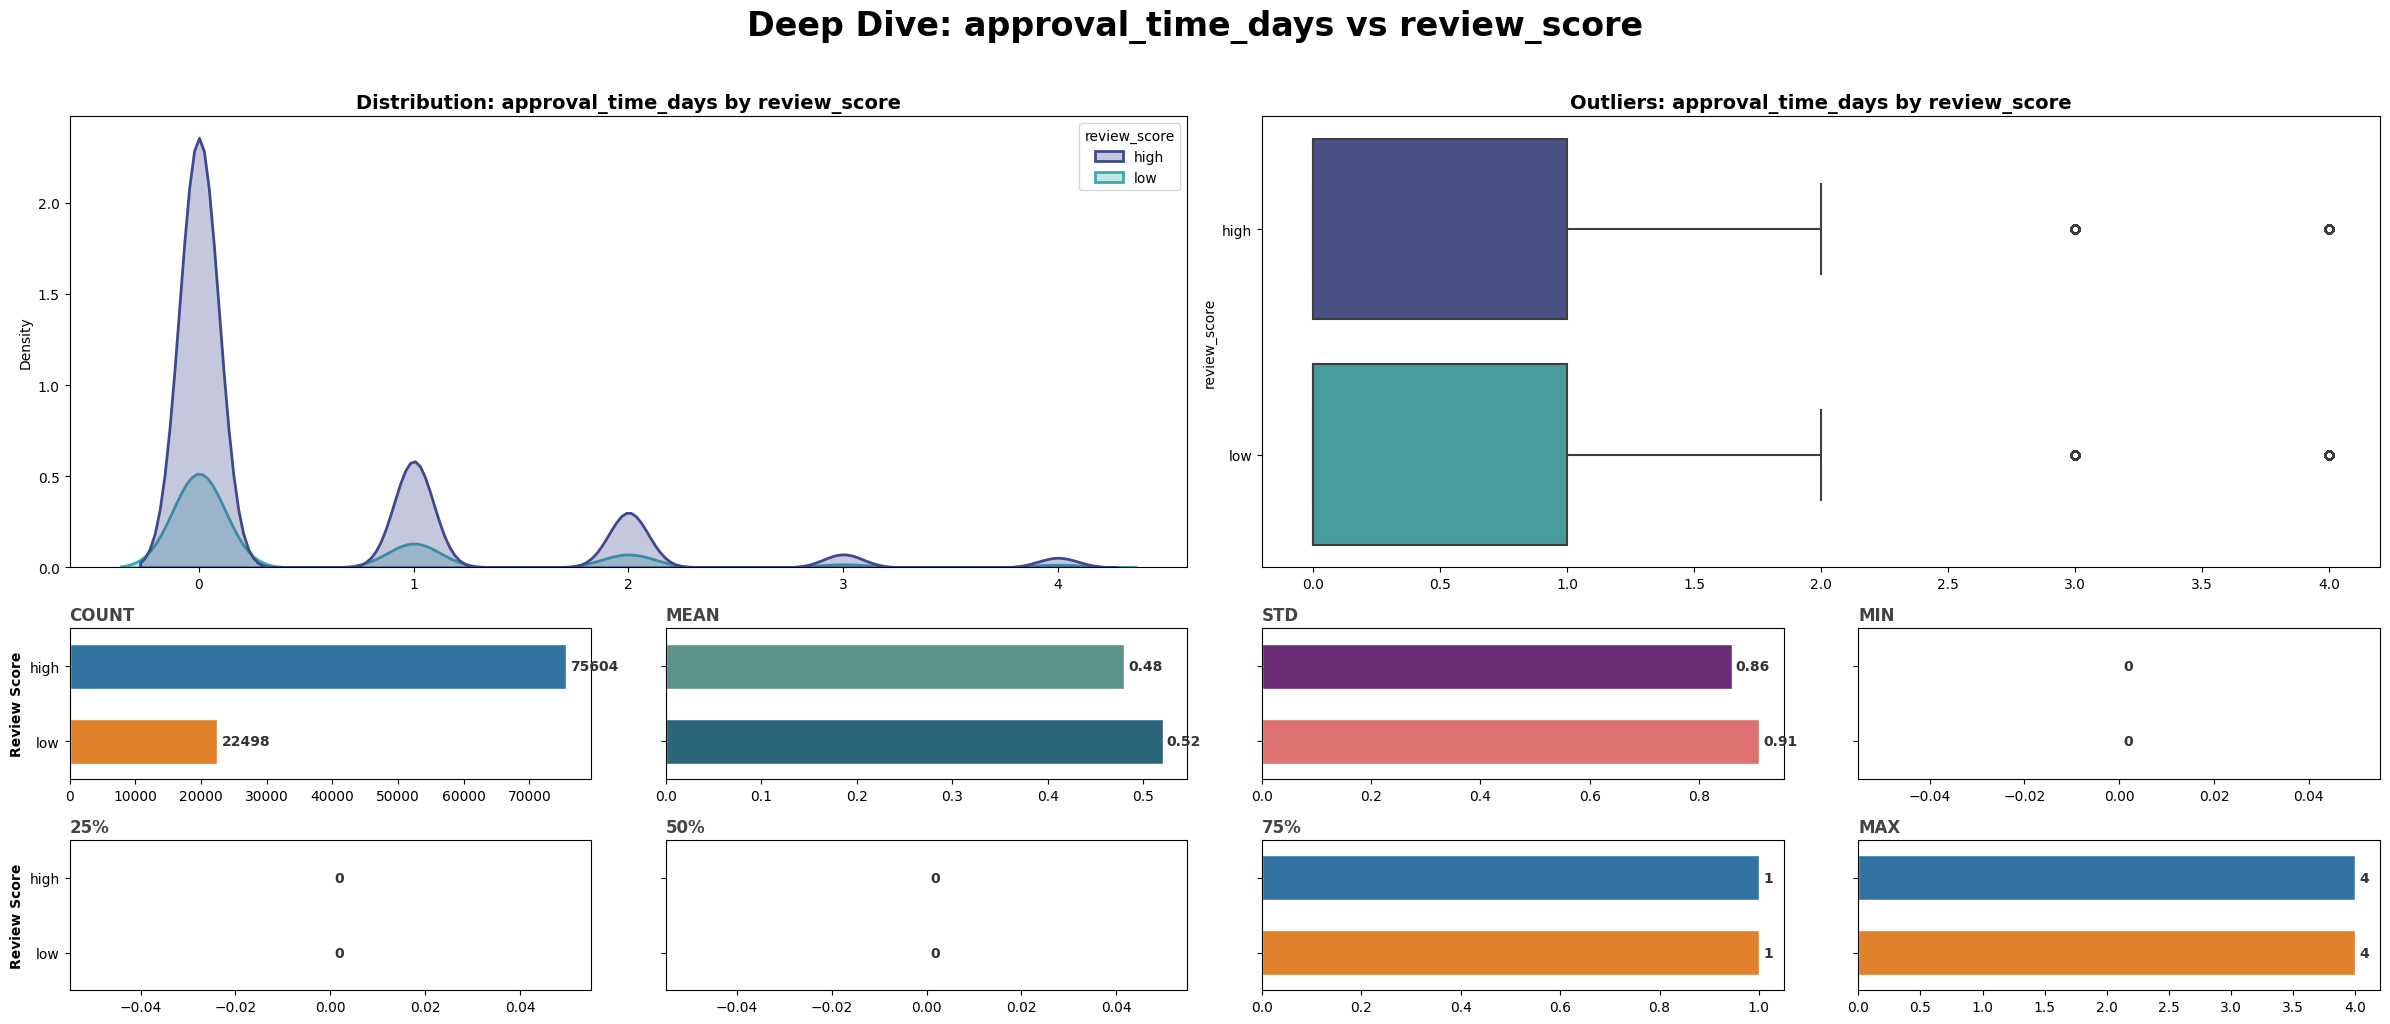

In [154]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'approval_time_days','review_score')

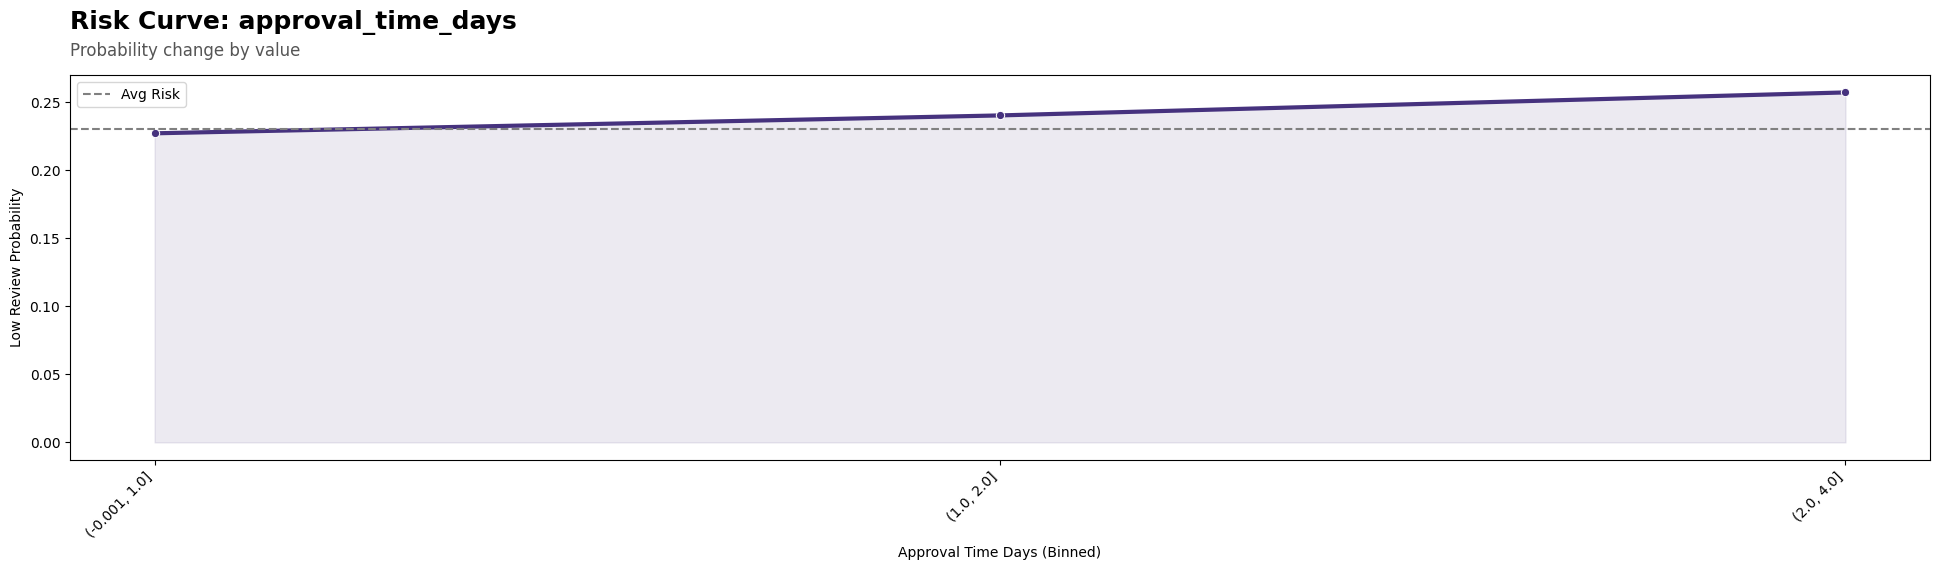

In [155]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'approval_time_days','review_score')

In [156]:
S.compare_means(data,'review_score','approval_time_days','low')


--- Comparing 'approval_time_days' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Negligible (Cohen's d = 0.041)
3. Balance:    Robust (High N) (n=22498 vs n=75604)
------------------------------------------------------------


- **we do not find anythin specific***

**delivery_time_days**

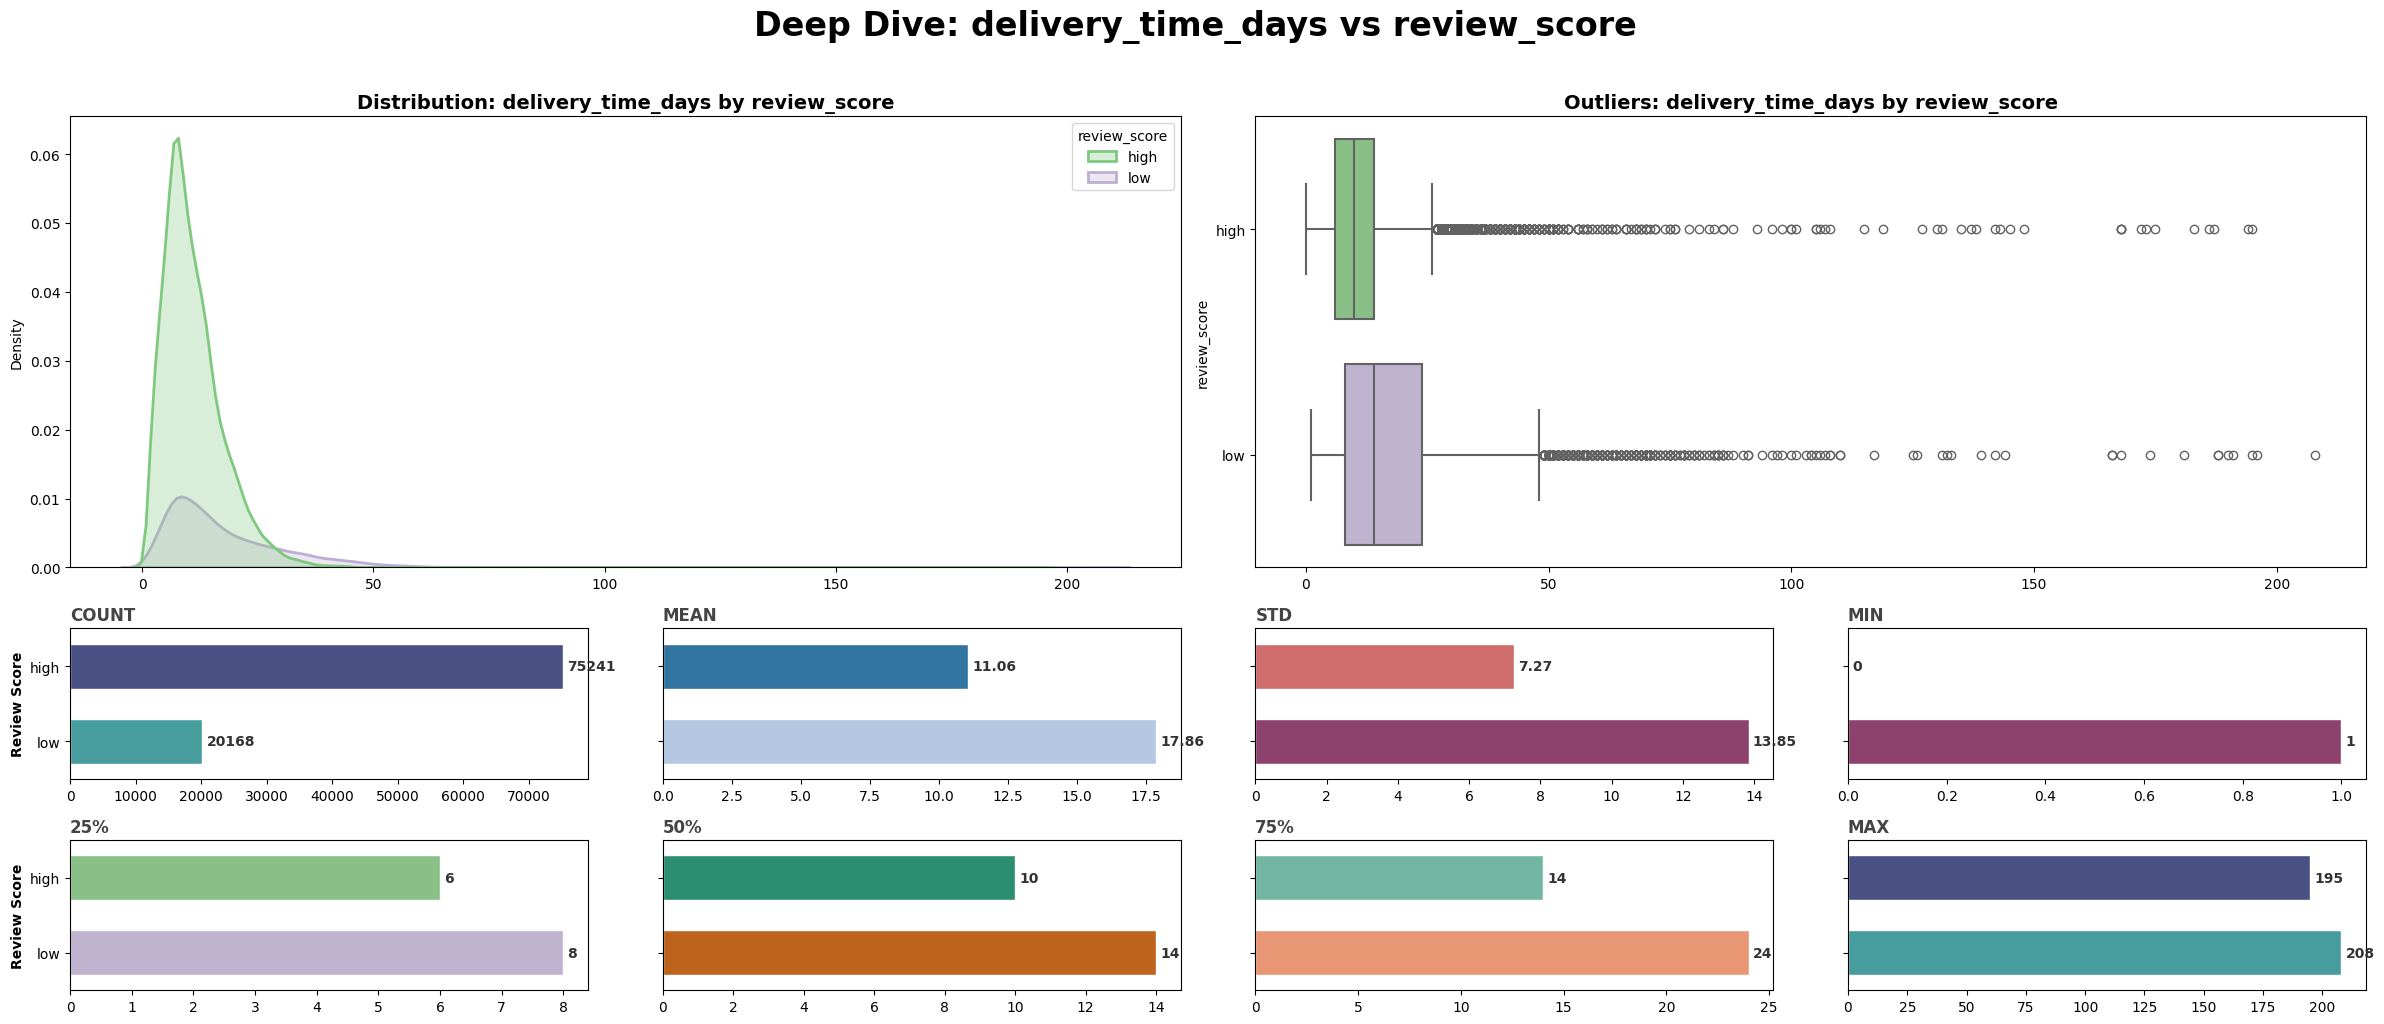

In [157]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'delivery_time_days','review_score')

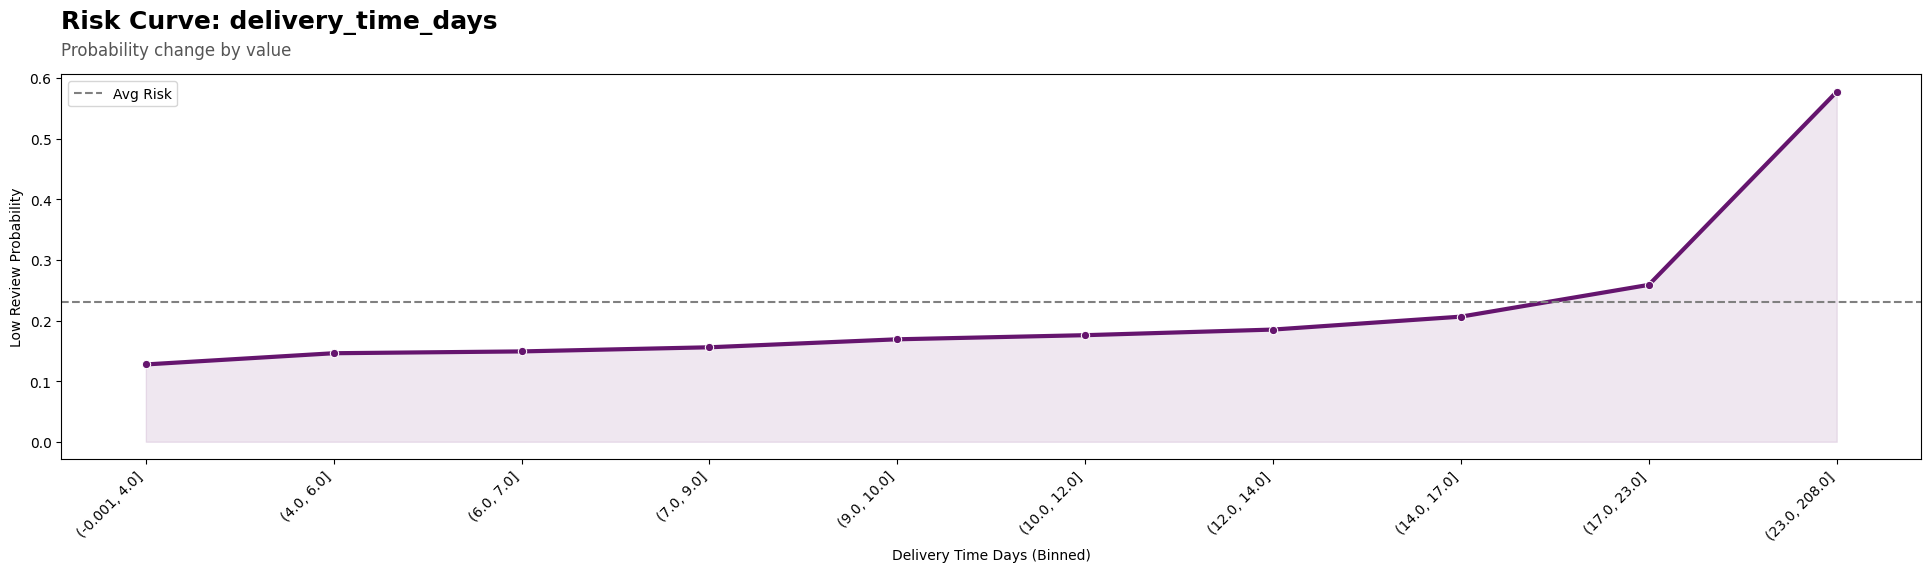

In [159]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'delivery_time_days','review_score')

In [160]:
delivery_time_days_groups = pd.cut(data['delivery_time_days'], 
                         bins=[-1, 23, float('inf')], 
                         labels=['3 Weeks','3 Weeks +'])

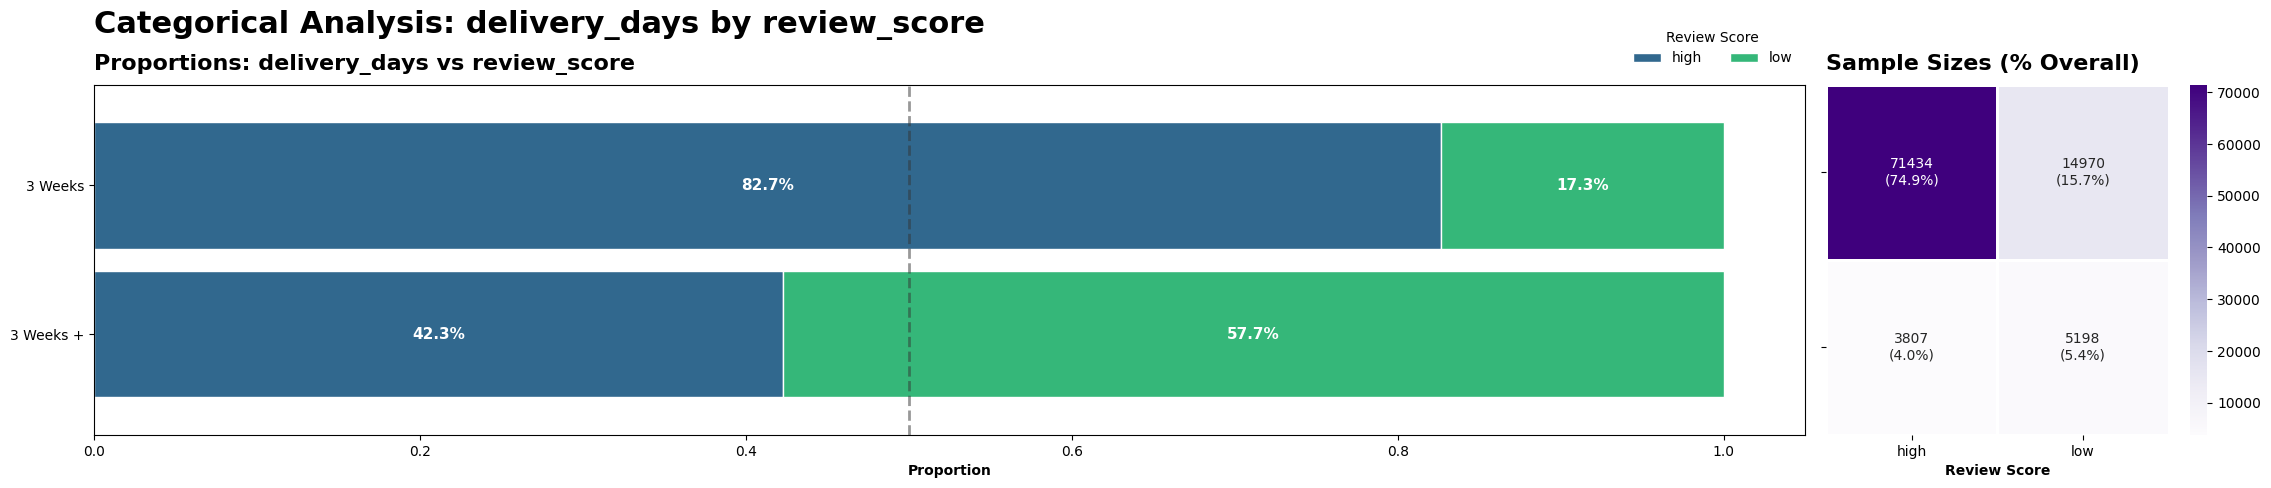

In [161]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(delivery_days = delivery_time_days_groups),'delivery_days','review_score')

In [162]:
ct = pd.crosstab(delivery_time_days_groups,data['review_score'])
S.test_association(ct)


--- Association Test: delivery_time_days vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.289)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [163]:
S.compare_means(data,'review_score','delivery_time_days','low')


--- Comparing 'delivery_time_days' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Moderate (Cohen's d = 0.749)
3. Balance:    Robust (High N) (n=20168 vs n=75241)
------------------------------------------------------------


---
---
- ***By visuals we saw that `there is linear reationship between delivery_days and review_score, and also after 23 delivery days low reviews are significantly high` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**seller_processing_days**

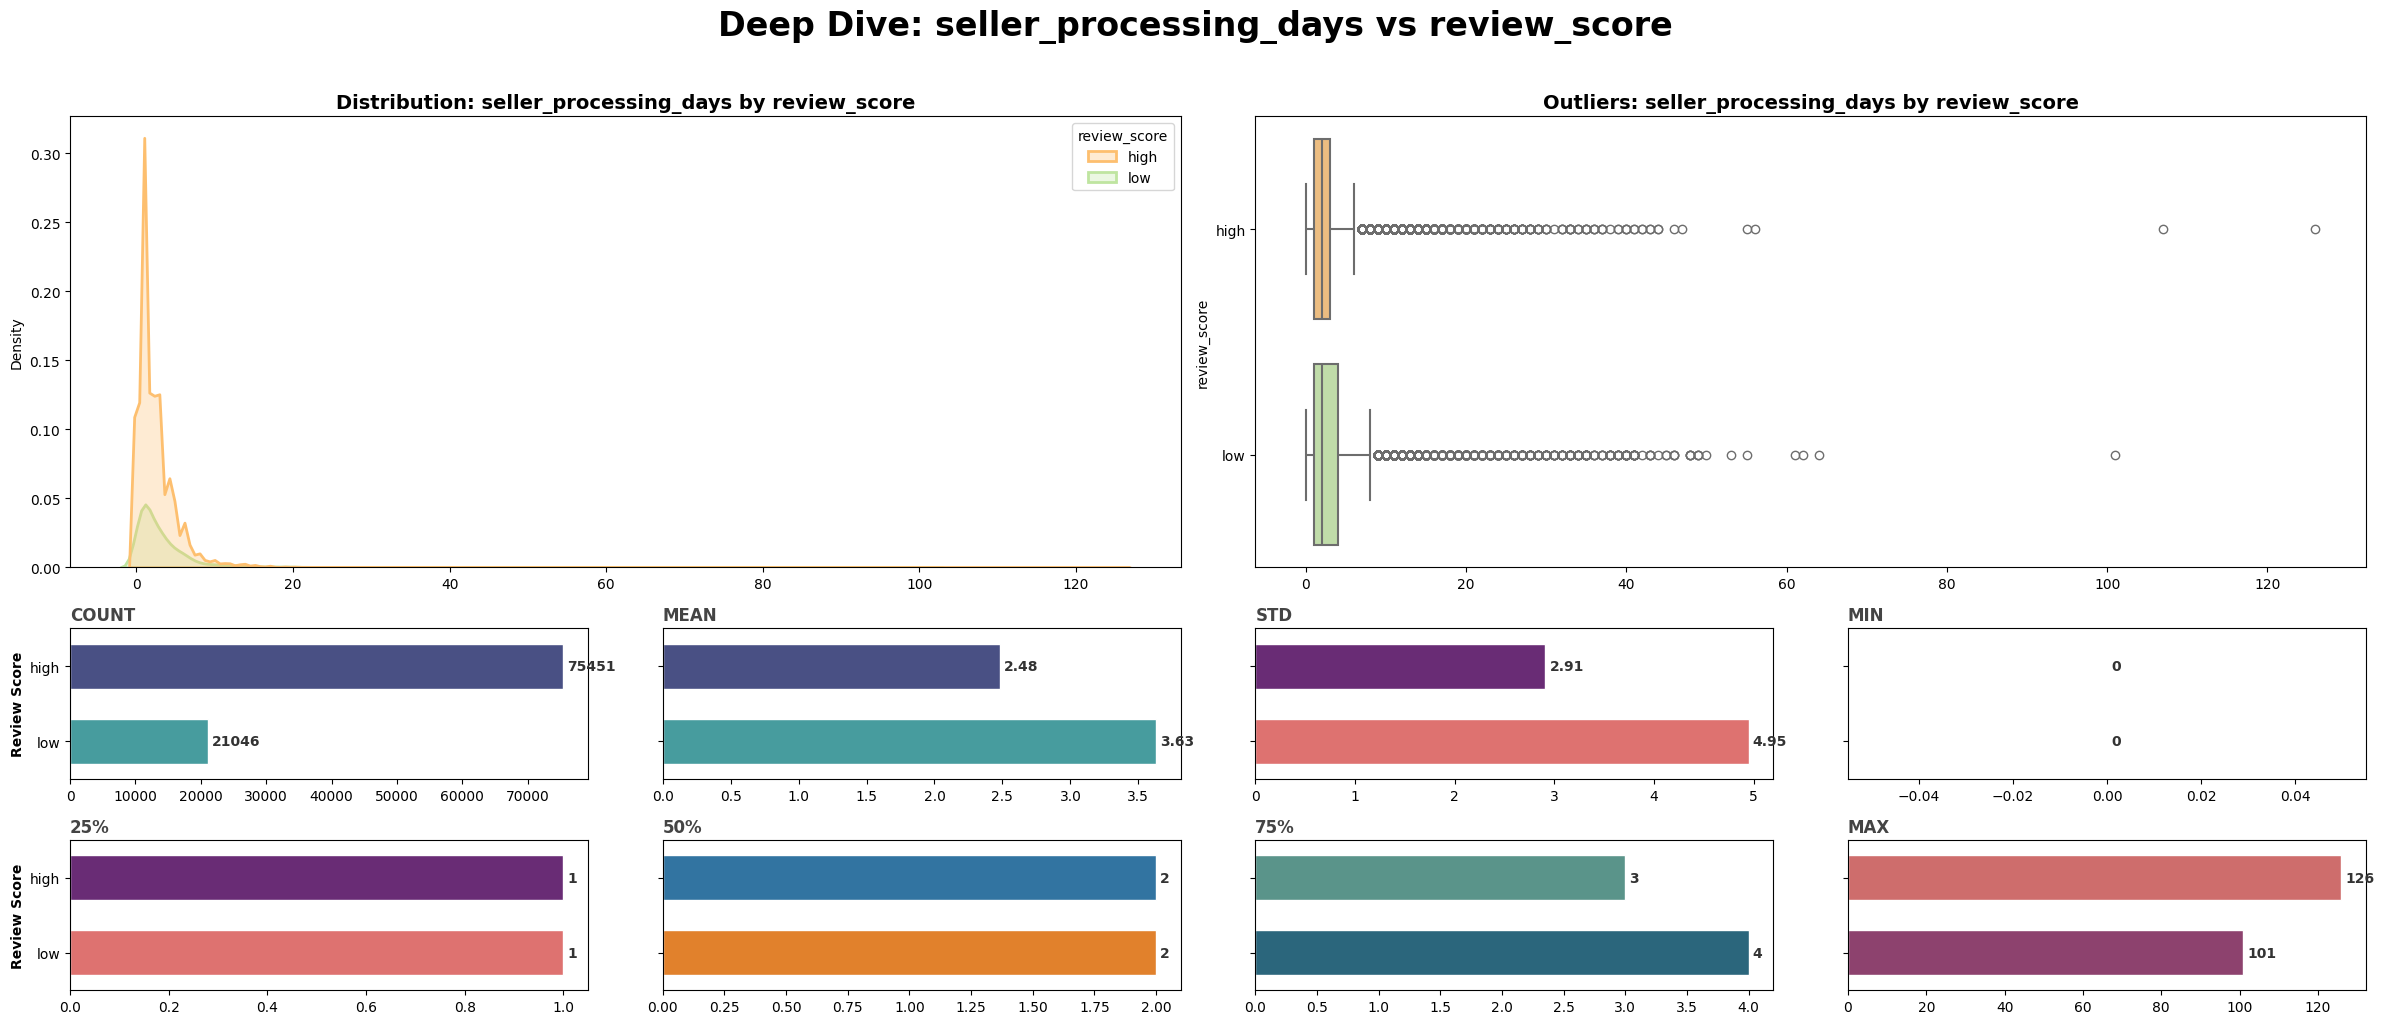

In [164]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'seller_processing_days','review_score')

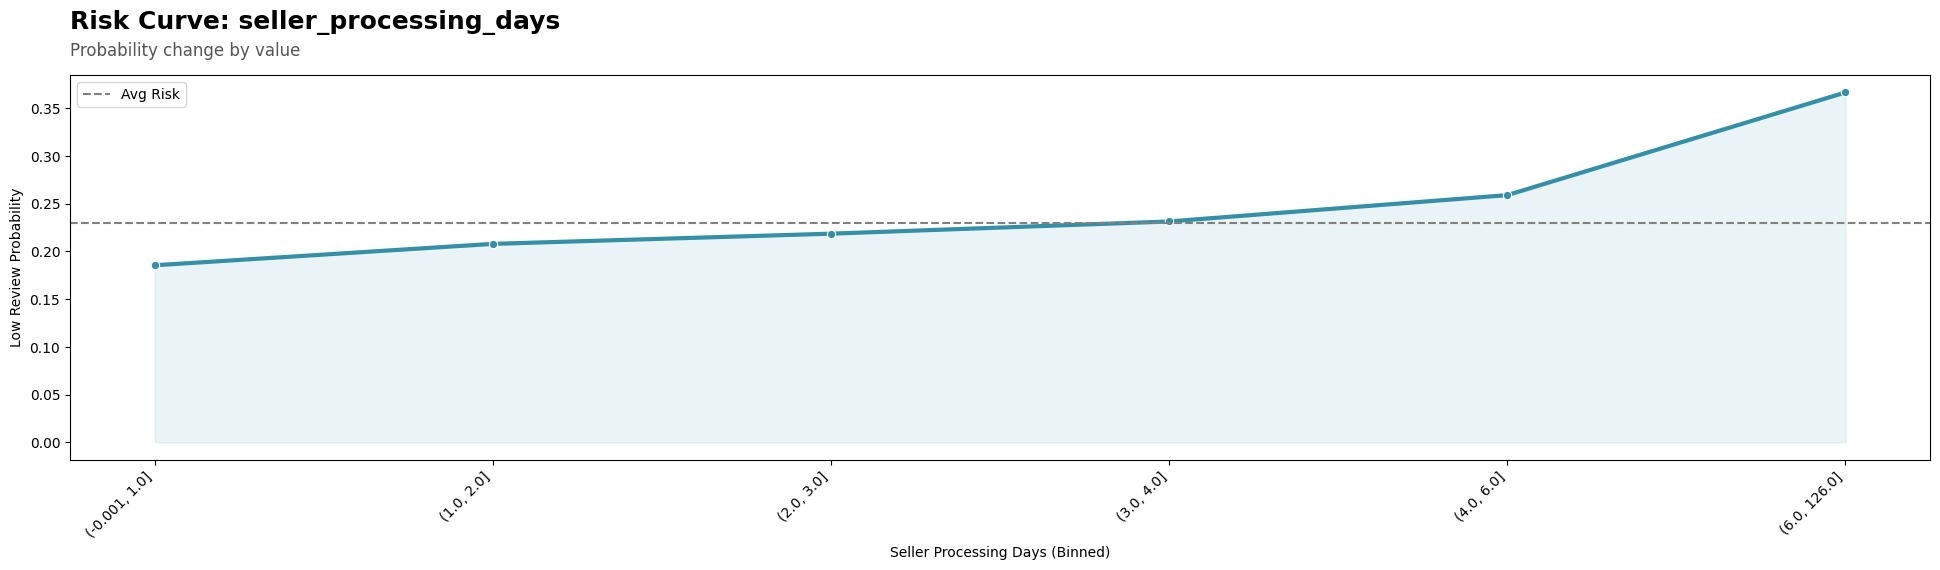

In [165]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'seller_processing_days','review_score')

In [166]:
seller_processing_days_groups = pd.cut(data['seller_processing_days'], 
                         bins=[-1,1, 3, float('inf')], 
                         labels=['1 Day','<= 3 days','>= 4 Days'])

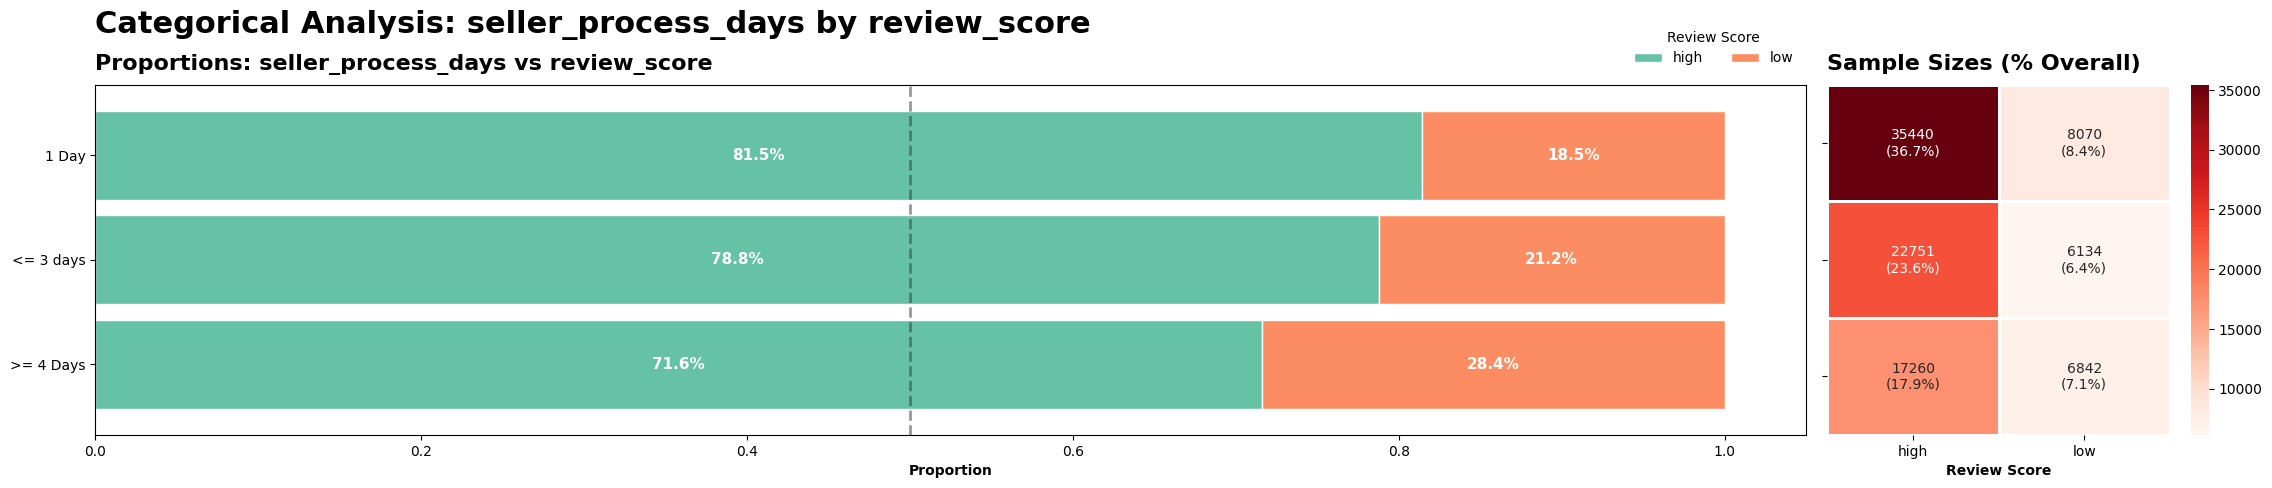

In [167]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(seller_process_days = seller_processing_days_groups),'seller_process_days','review_score')

In [168]:
S.compare_means(data,'review_score','seller_processing_days','low')


--- Comparing 'seller_processing_days' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.331)
3. Balance:    Robust (High N) (n=21046 vs n=75451)
------------------------------------------------------------


In [169]:
ct = pd.crosstab(seller_processing_days_groups,data['review_score'])
S.test_association(ct)


--- Association Test: seller_processing_days vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.096)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `seller processing days more than 4 days have more lower reviews than less than 4 days` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**transit_days**

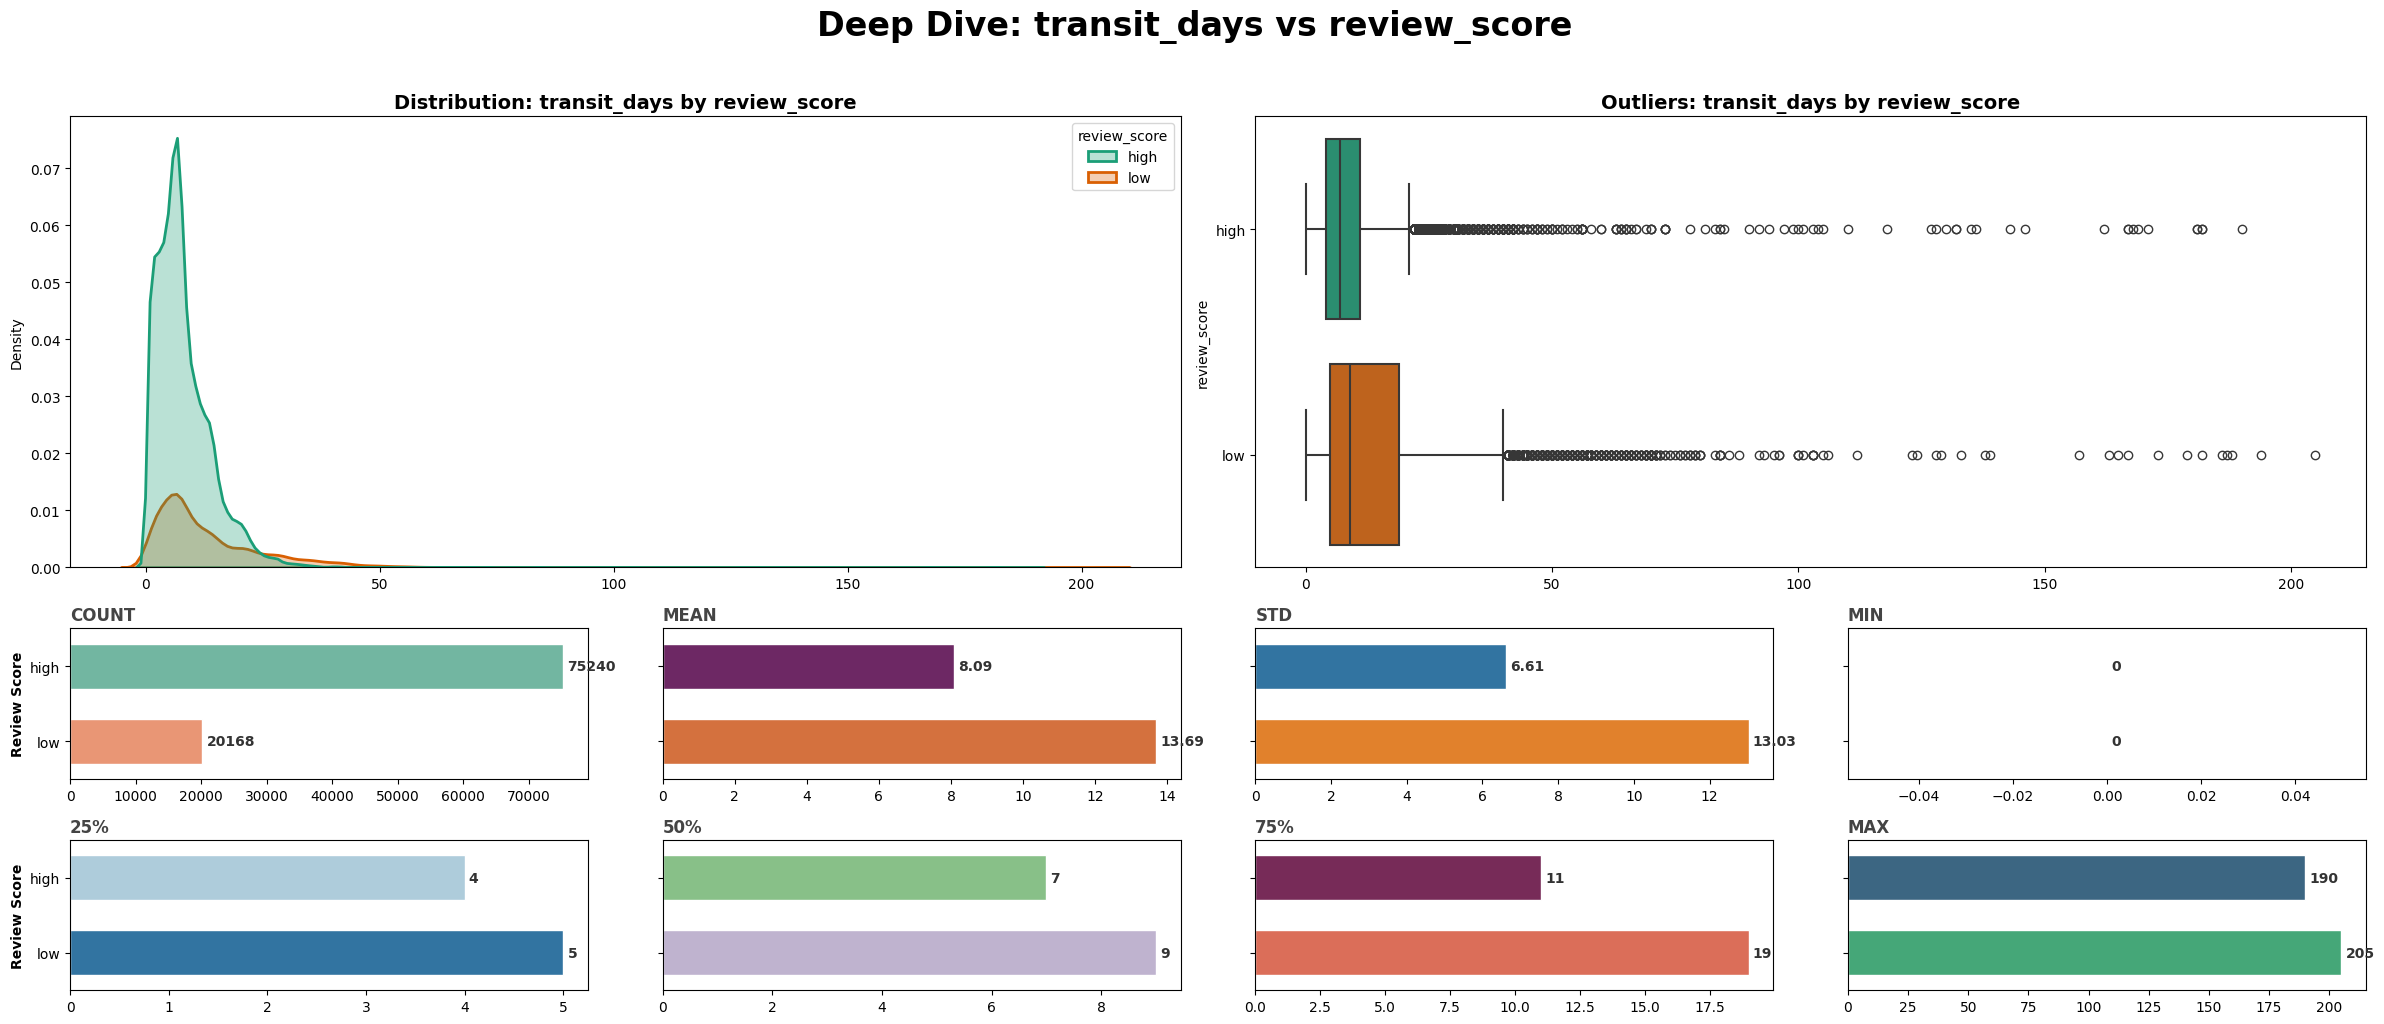

In [170]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'transit_days','review_score')

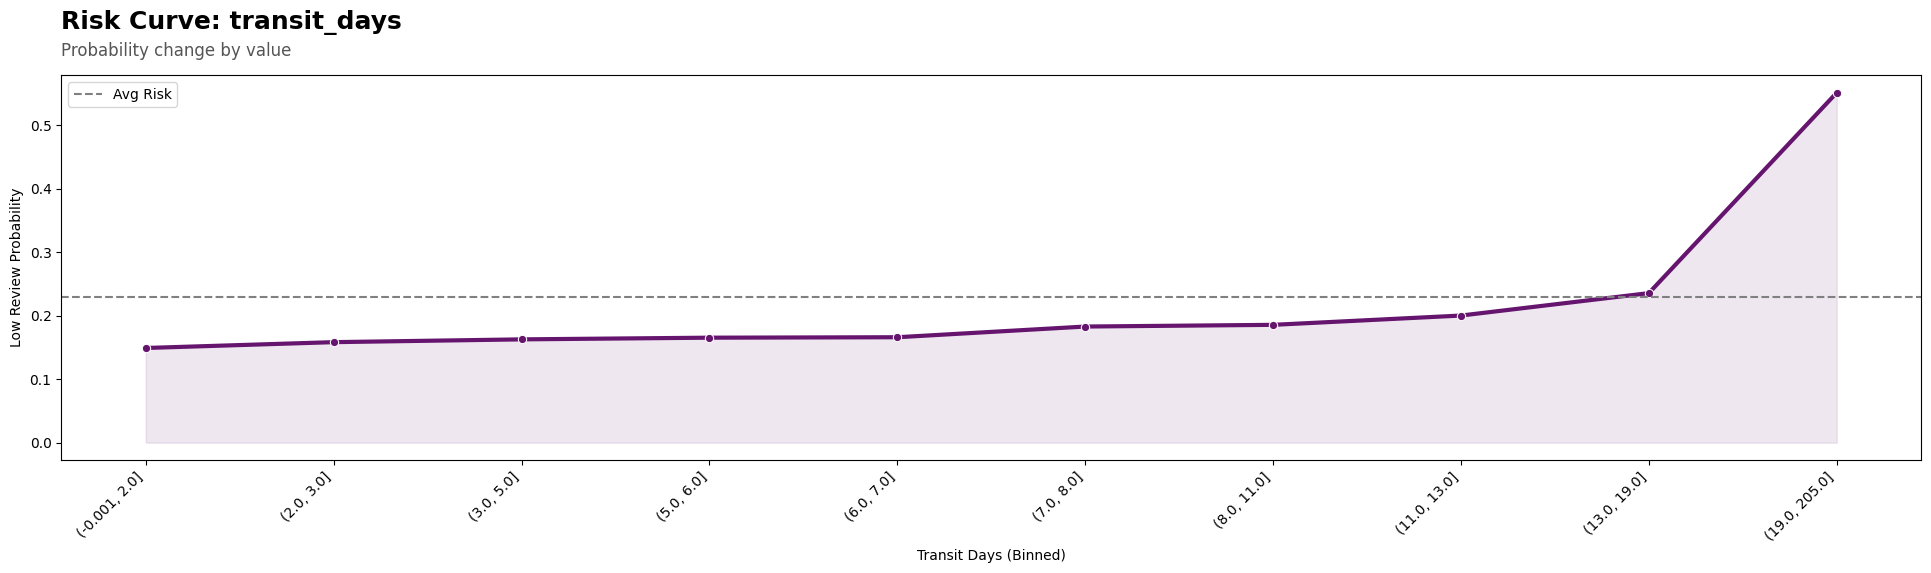

In [171]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'transit_days','review_score')

In [172]:
transit_days_groups = pd.cut(data['transit_days'], 
                         bins=[-1,18, float('inf')], 
                         labels=['<= 18 days','>= 18 Days'])

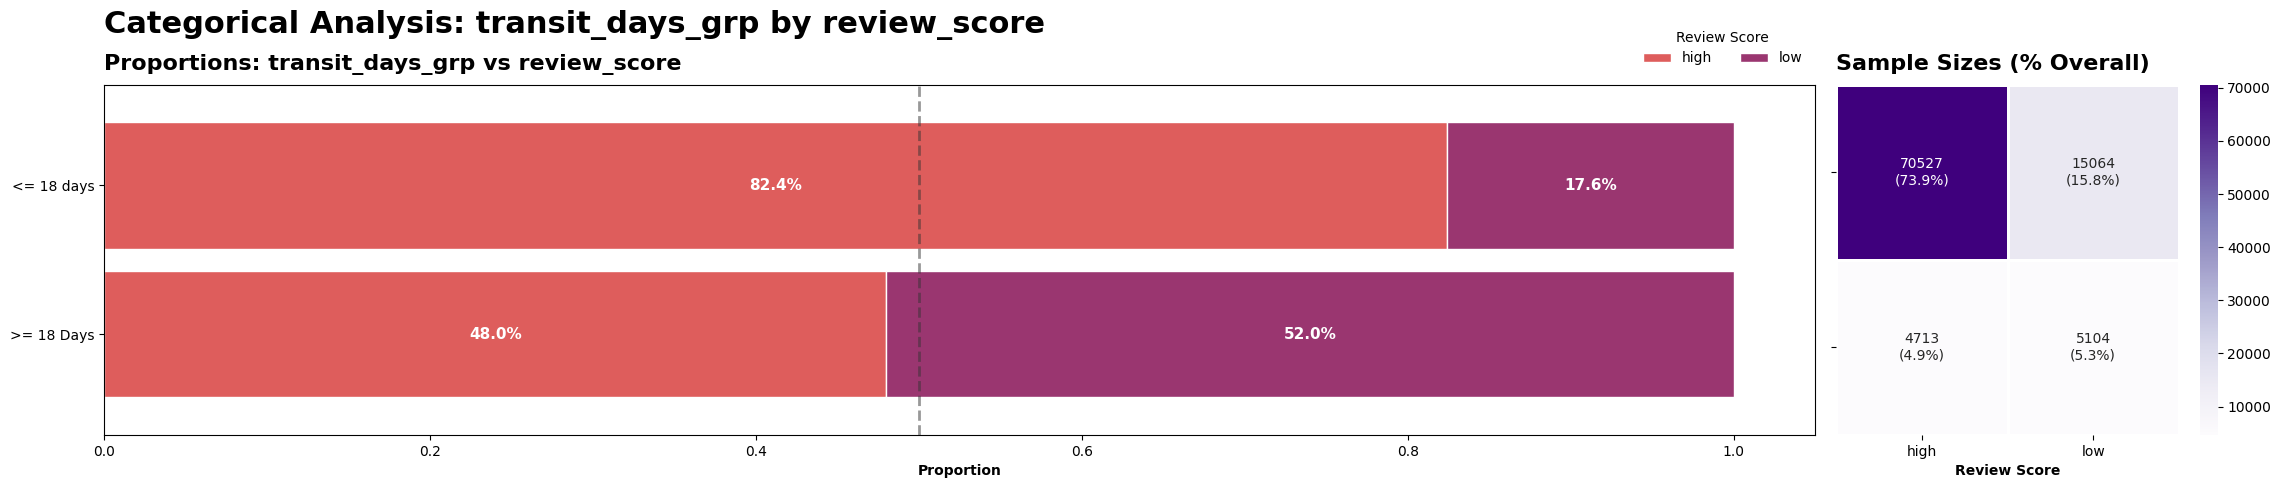

In [173]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(transit_days_grp = transit_days_groups),'transit_days_grp','review_score')

In [174]:
ct = pd.crosstab(transit_days_groups,data['review_score'])
S.test_association(ct)


--- Association Test: transit_days vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.256)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [175]:
ct = pd.crosstab(transit_days_groups,data['review_score'])
S.test_association(ct)


--- Association Test: transit_days vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.256)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `there is a high chance of low reviews after 18 days of transit, compared to transit days less than 18 days` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**delivery_diff_days**

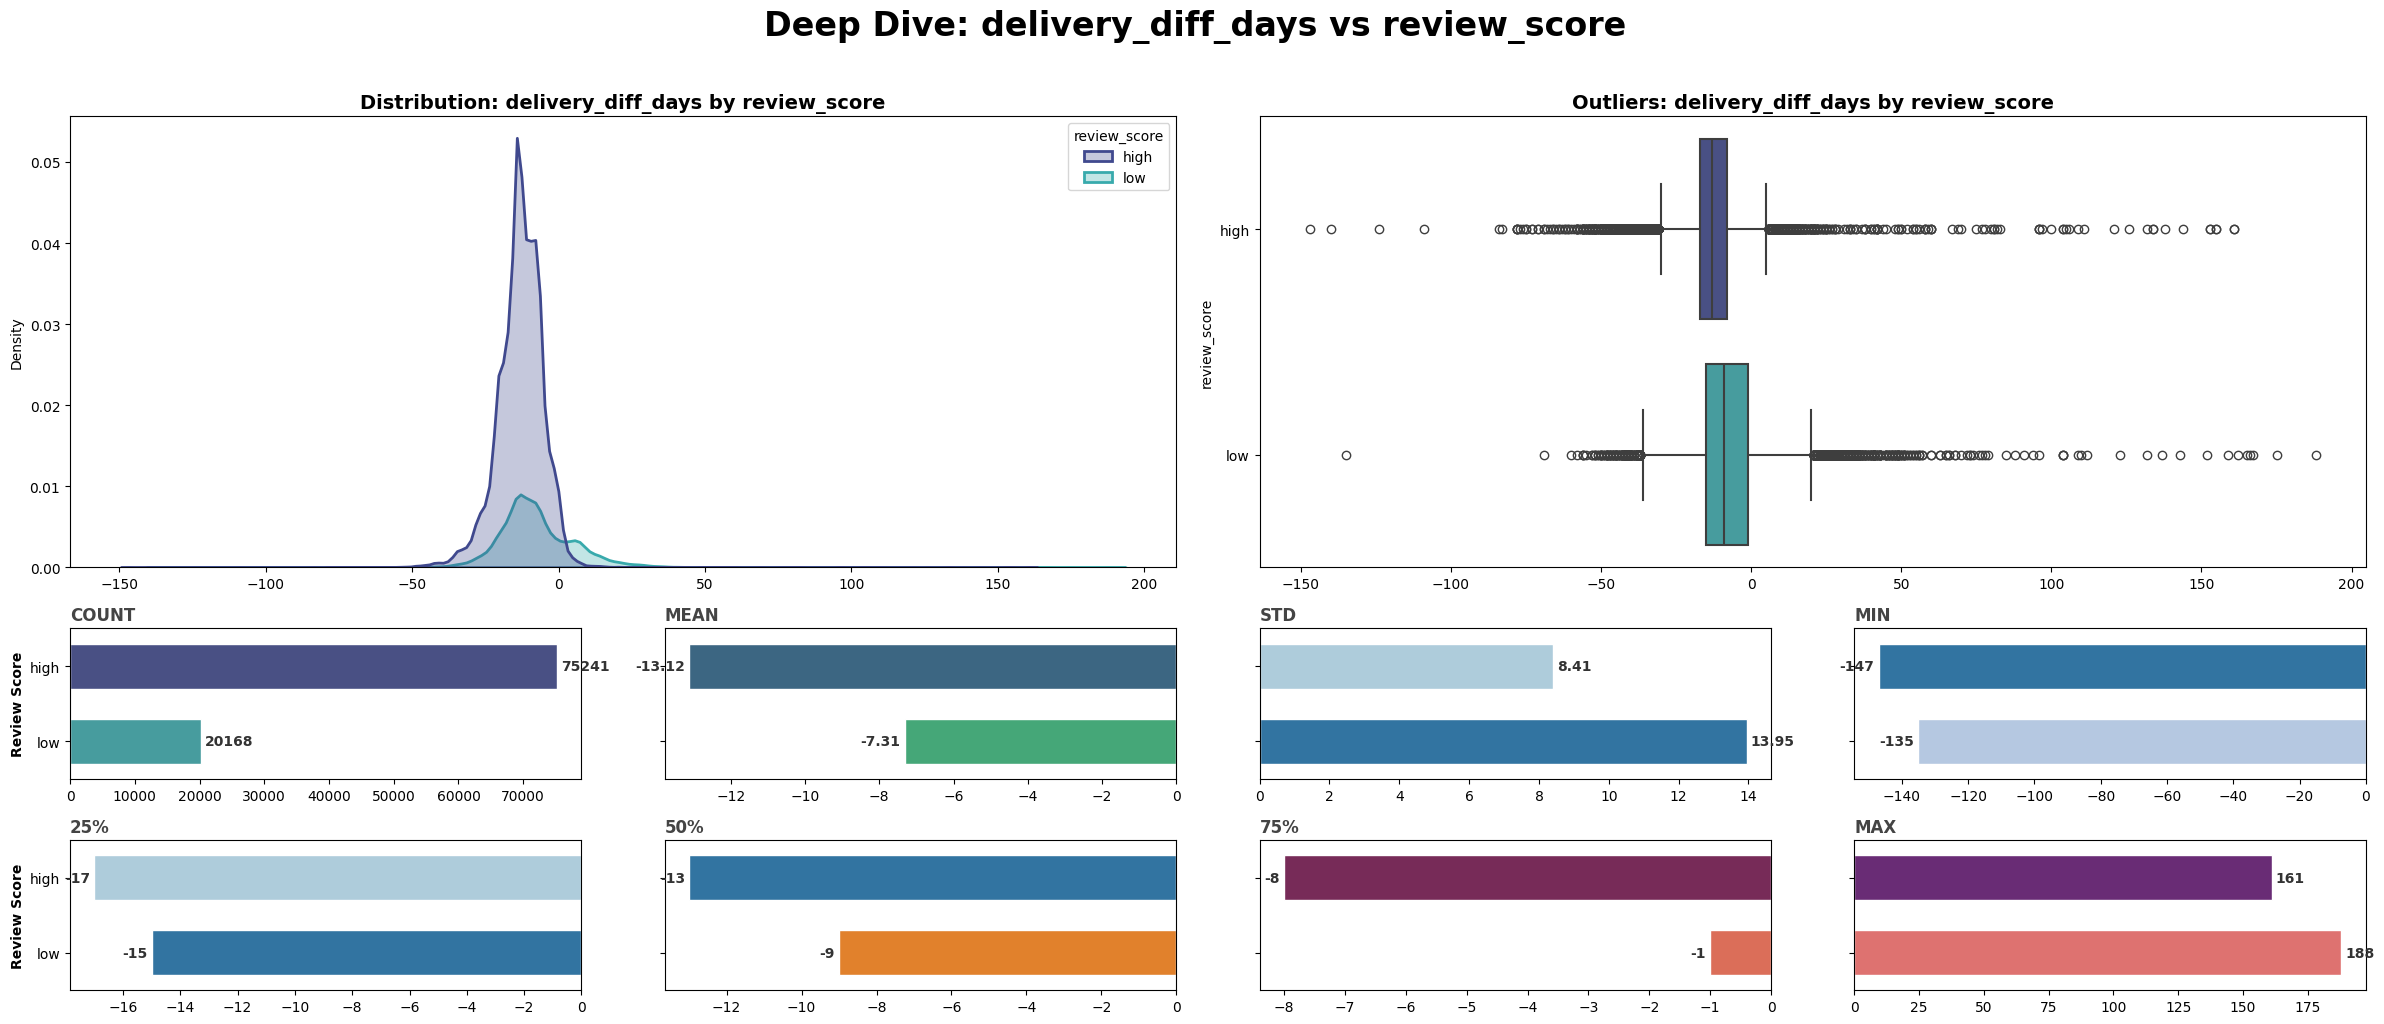

In [176]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'delivery_diff_days','review_score')

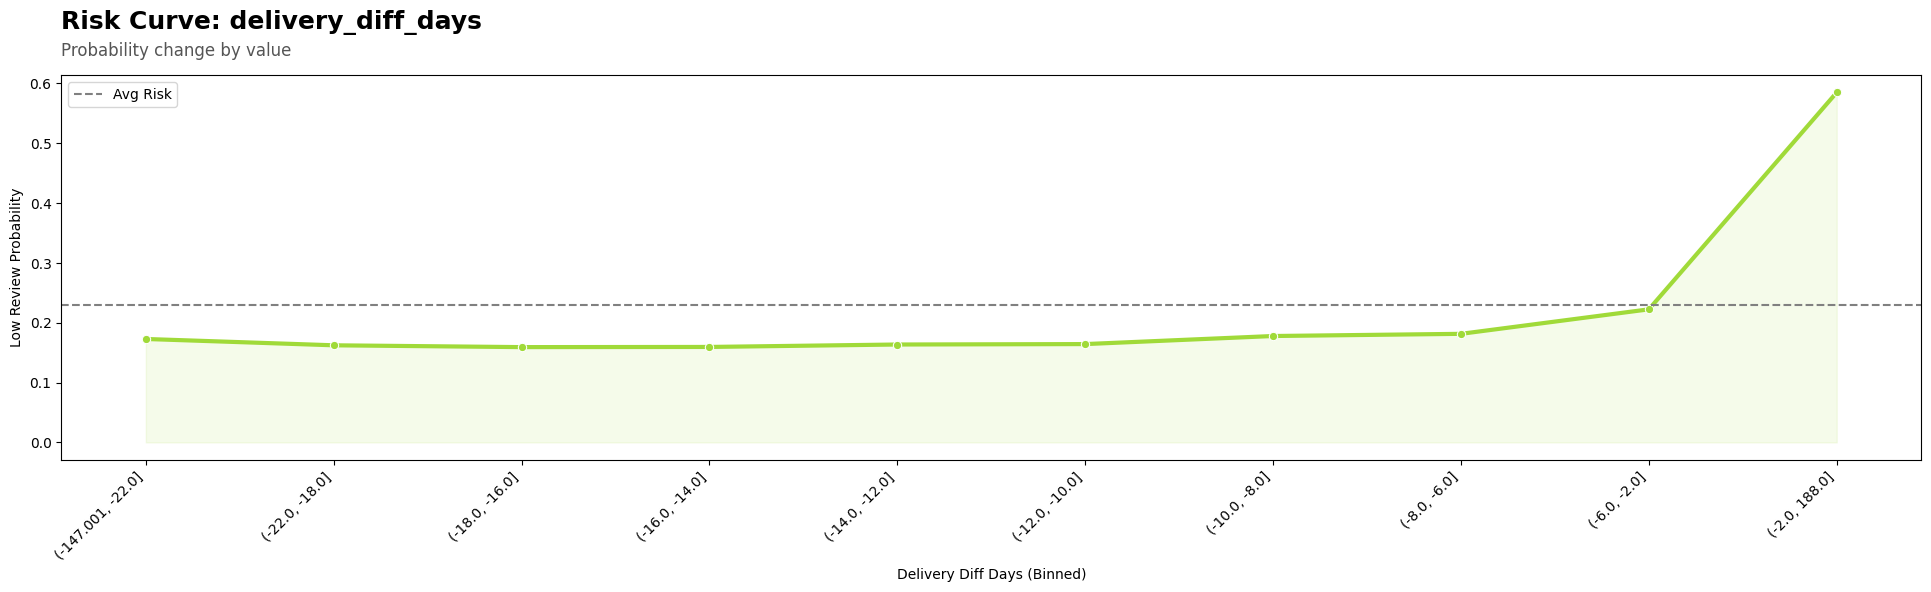

In [178]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'delivery_diff_days','review_score')

In [179]:
delivery_diff_days_groups = pd.cut(data['delivery_diff_days'], 
                         bins=[float('-inf'),-1, float('inf')], 
                         labels=['Before Estimate','After Estimate'])

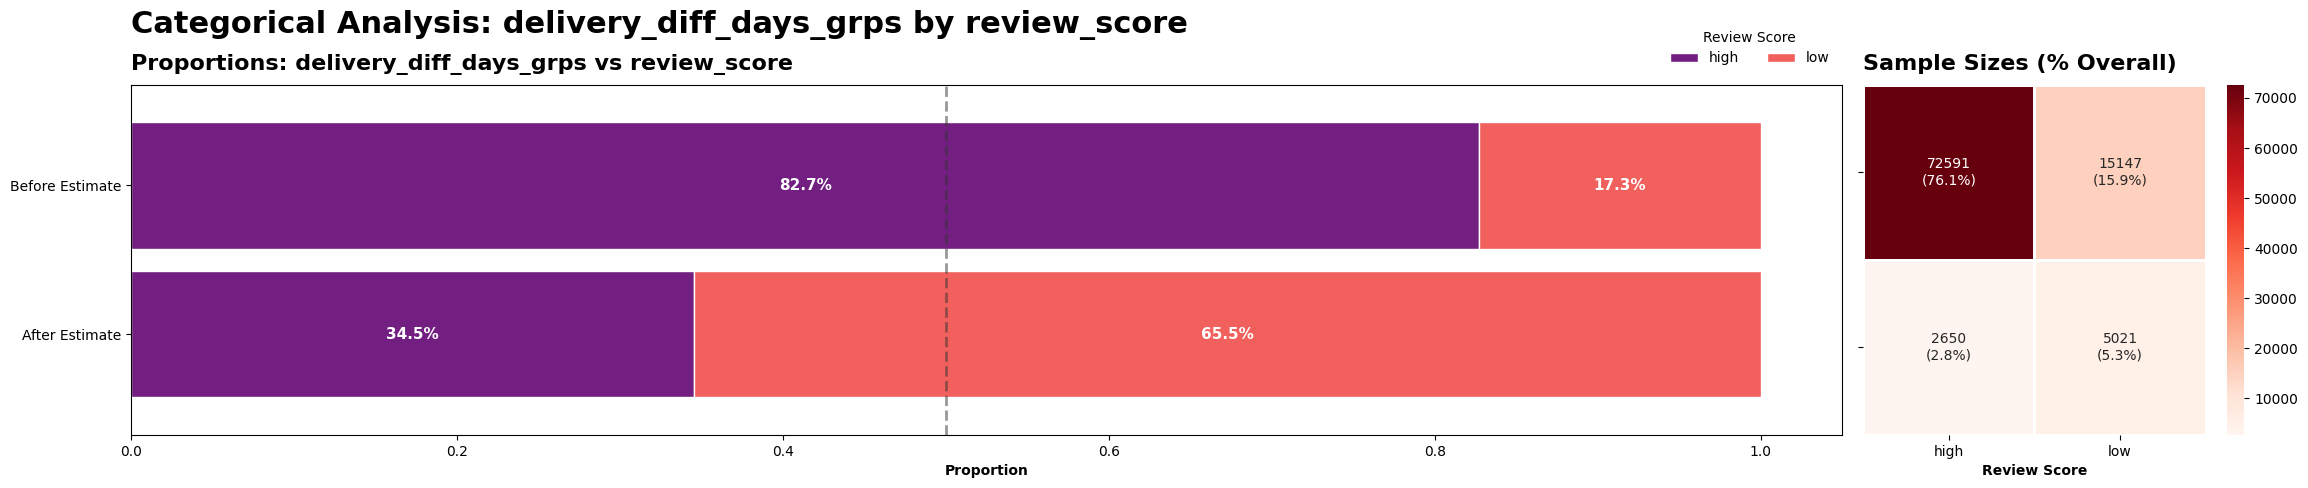

In [180]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(delivery_diff_days_grps = delivery_diff_days_groups),'delivery_diff_days_grps','review_score')

In [181]:
ct = pd.crosstab(delivery_diff_days_groups,data['review_score'])
S.test_association(ct)


--- Association Test: delivery_diff_days vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.321)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [182]:
S.compare_means(data,'review_score','delivery_diff_days','low')


--- Comparing 'delivery_diff_days' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Moderate (Cohen's d = 0.590)
3. Balance:    Robust (High N) (n=20168 vs n=75241)
------------------------------------------------------------


---
---
- ***By visuals we saw that `there are more lower ratings when the delivery is after before the estimate date, compared to delivery on estimate date or after ` - by statistical test we can support this observation with strong strength, but large sample size makes it a reliable find***
---
---

**dimensional_weight**

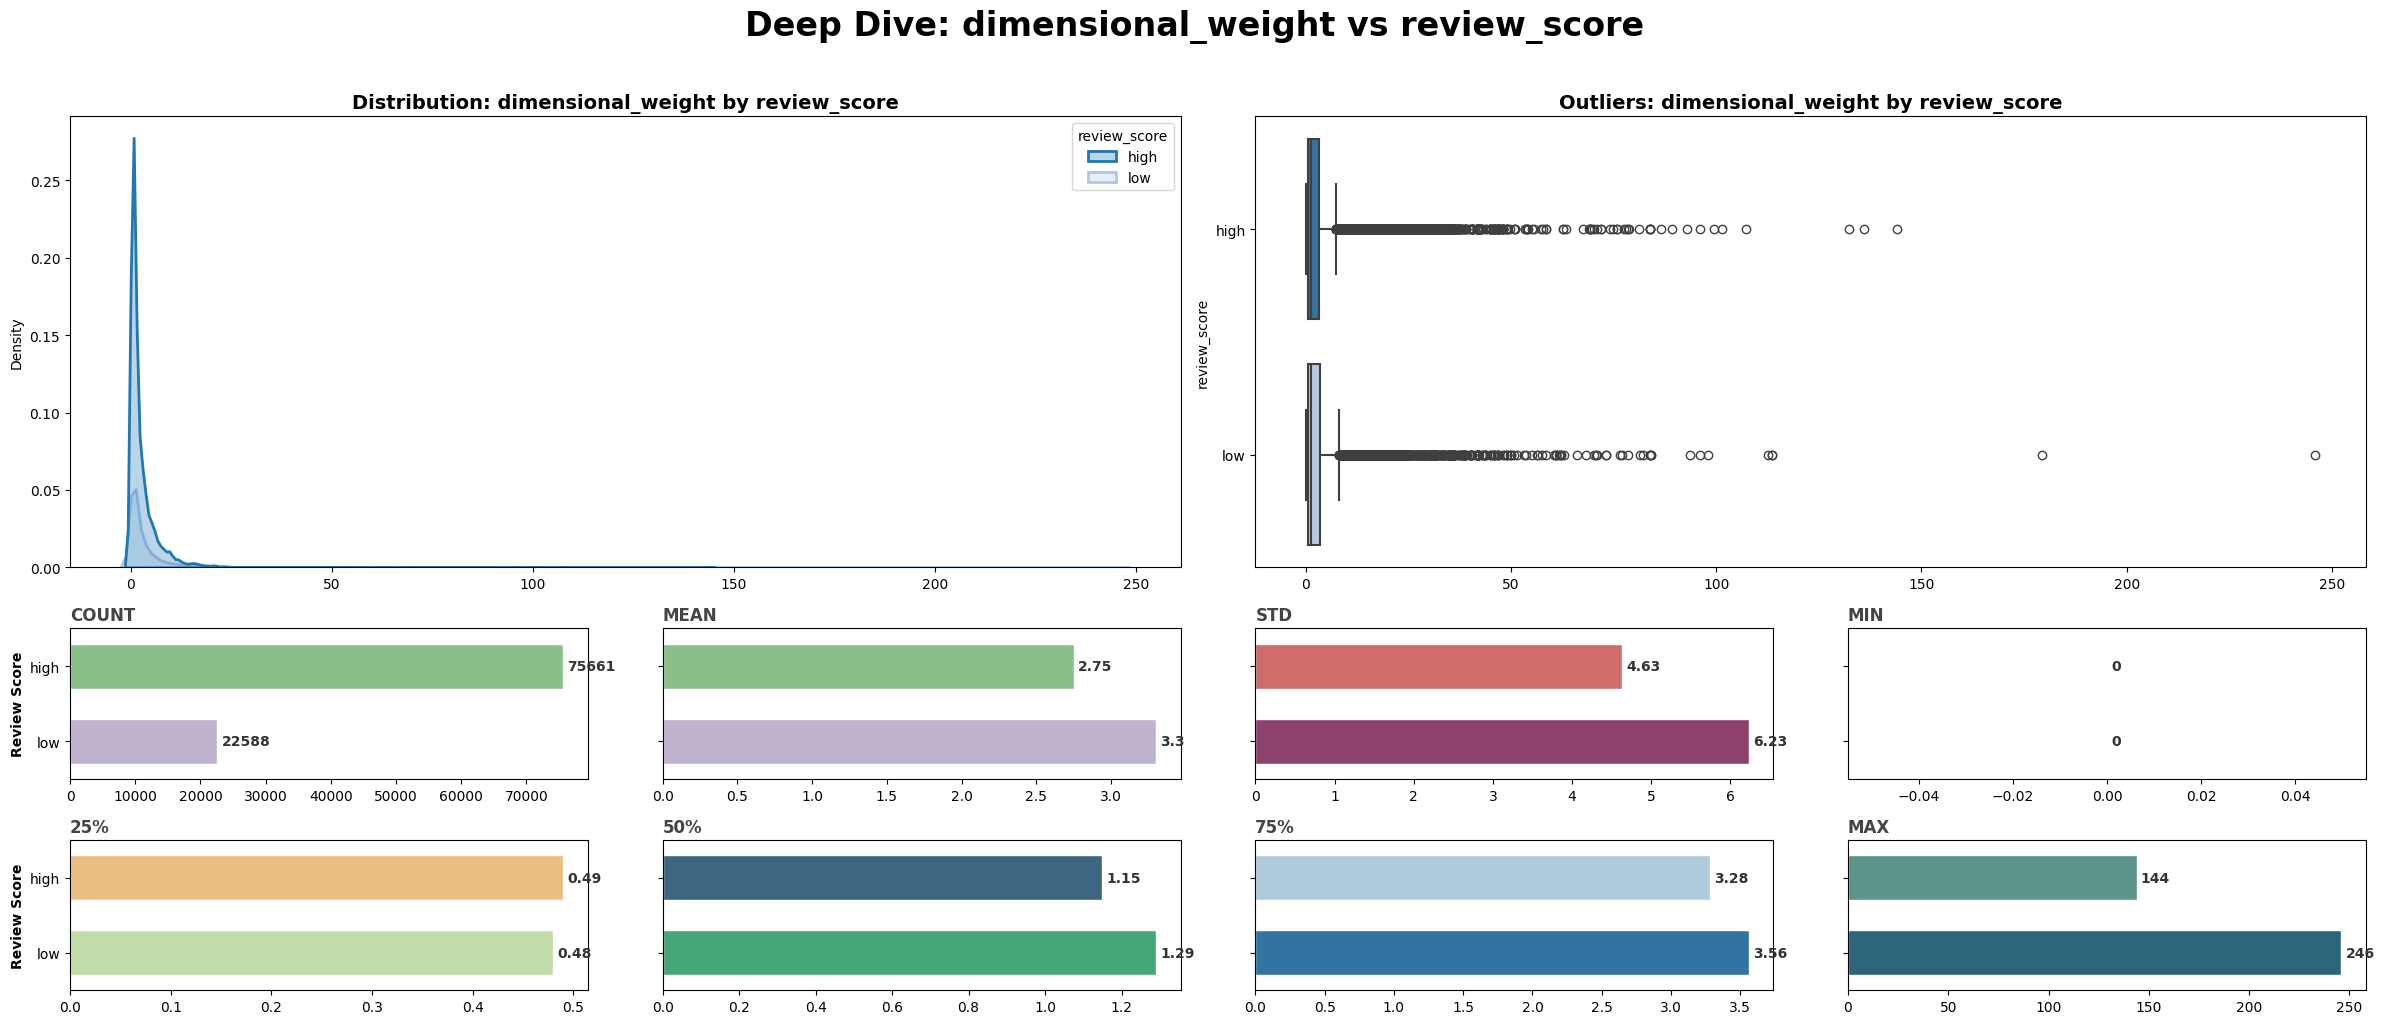

In [190]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'dimensional_weight','review_score')

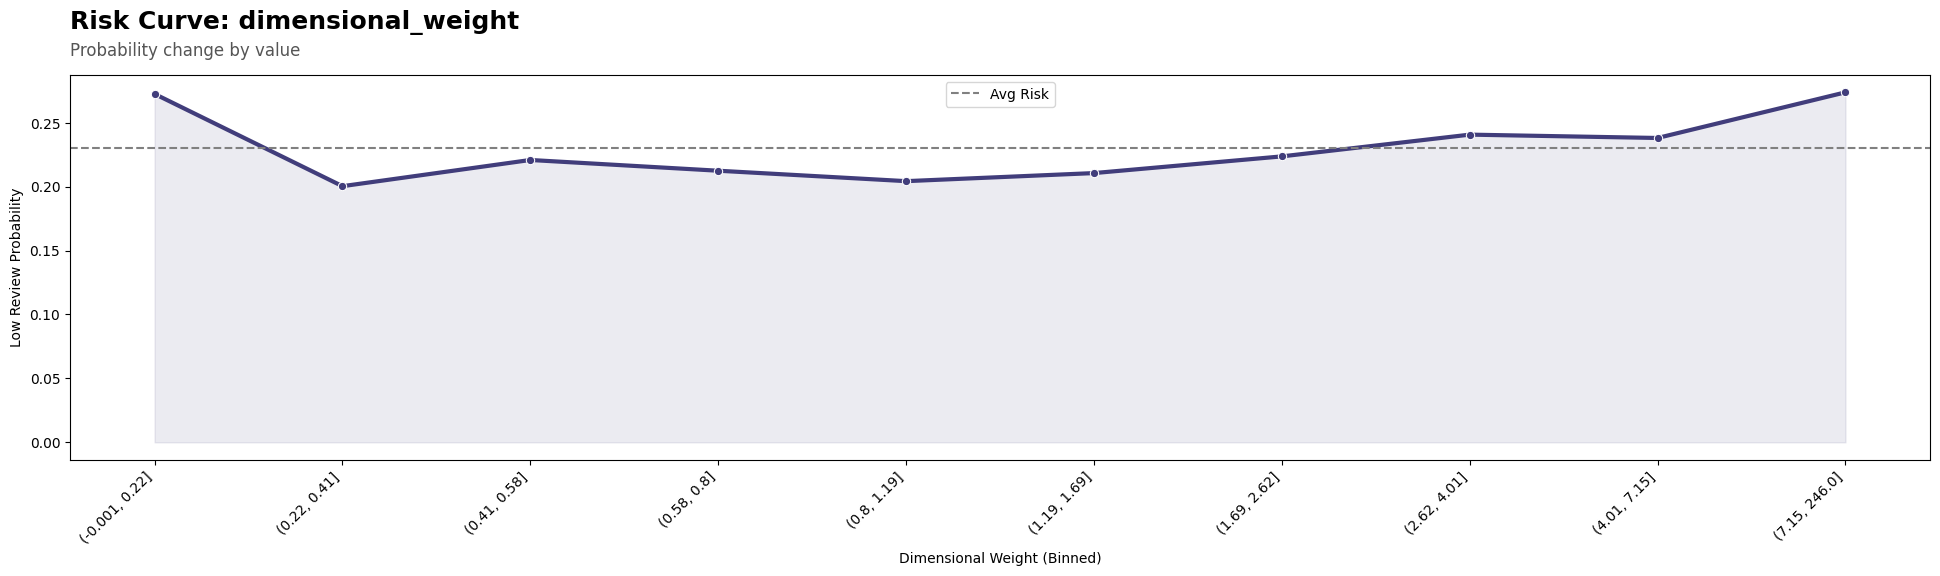

In [191]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'dimensional_weight','review_score')

In [204]:
dimensional_weight_groups = pd.cut(data['dimensional_weight'], 
                         bins=[-1,.23 ,2.62,float('inf')], 
                         labels=['Small','Normal','Crit Range'])

In [205]:
dimensional_weight_groups=dimensional_weight_groups.replace('Small','Crit Range')

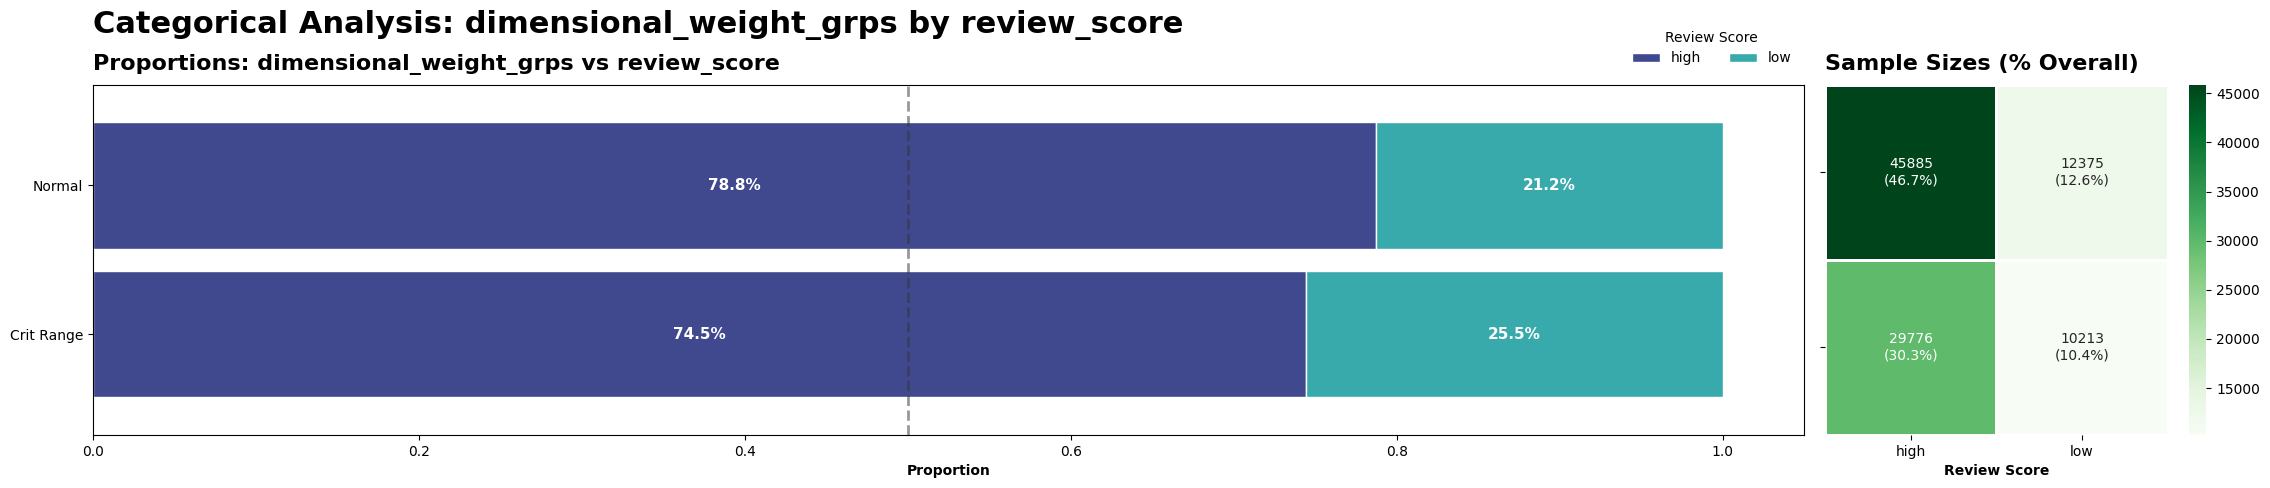

In [206]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(dimensional_weight_grps = dimensional_weight_groups),'dimensional_weight_grps','review_score')

In [207]:
ct = pd.crosstab(dimensional_weight_groups,data['review_score'])
S.test_association(ct)


--- Association Test: dimensional_weight vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.050)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [208]:
S.compare_means(data,'review_score','dimensional_weight','low')


--- Comparing 'dimensional_weight' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.109)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


---
---
- ***By visuals we saw that `There is a crit rate in dimensional weight at smaller side(0 - 0.23) and larger side (2.62 - ) where review_score is relatively lower` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**product_photos_qty**

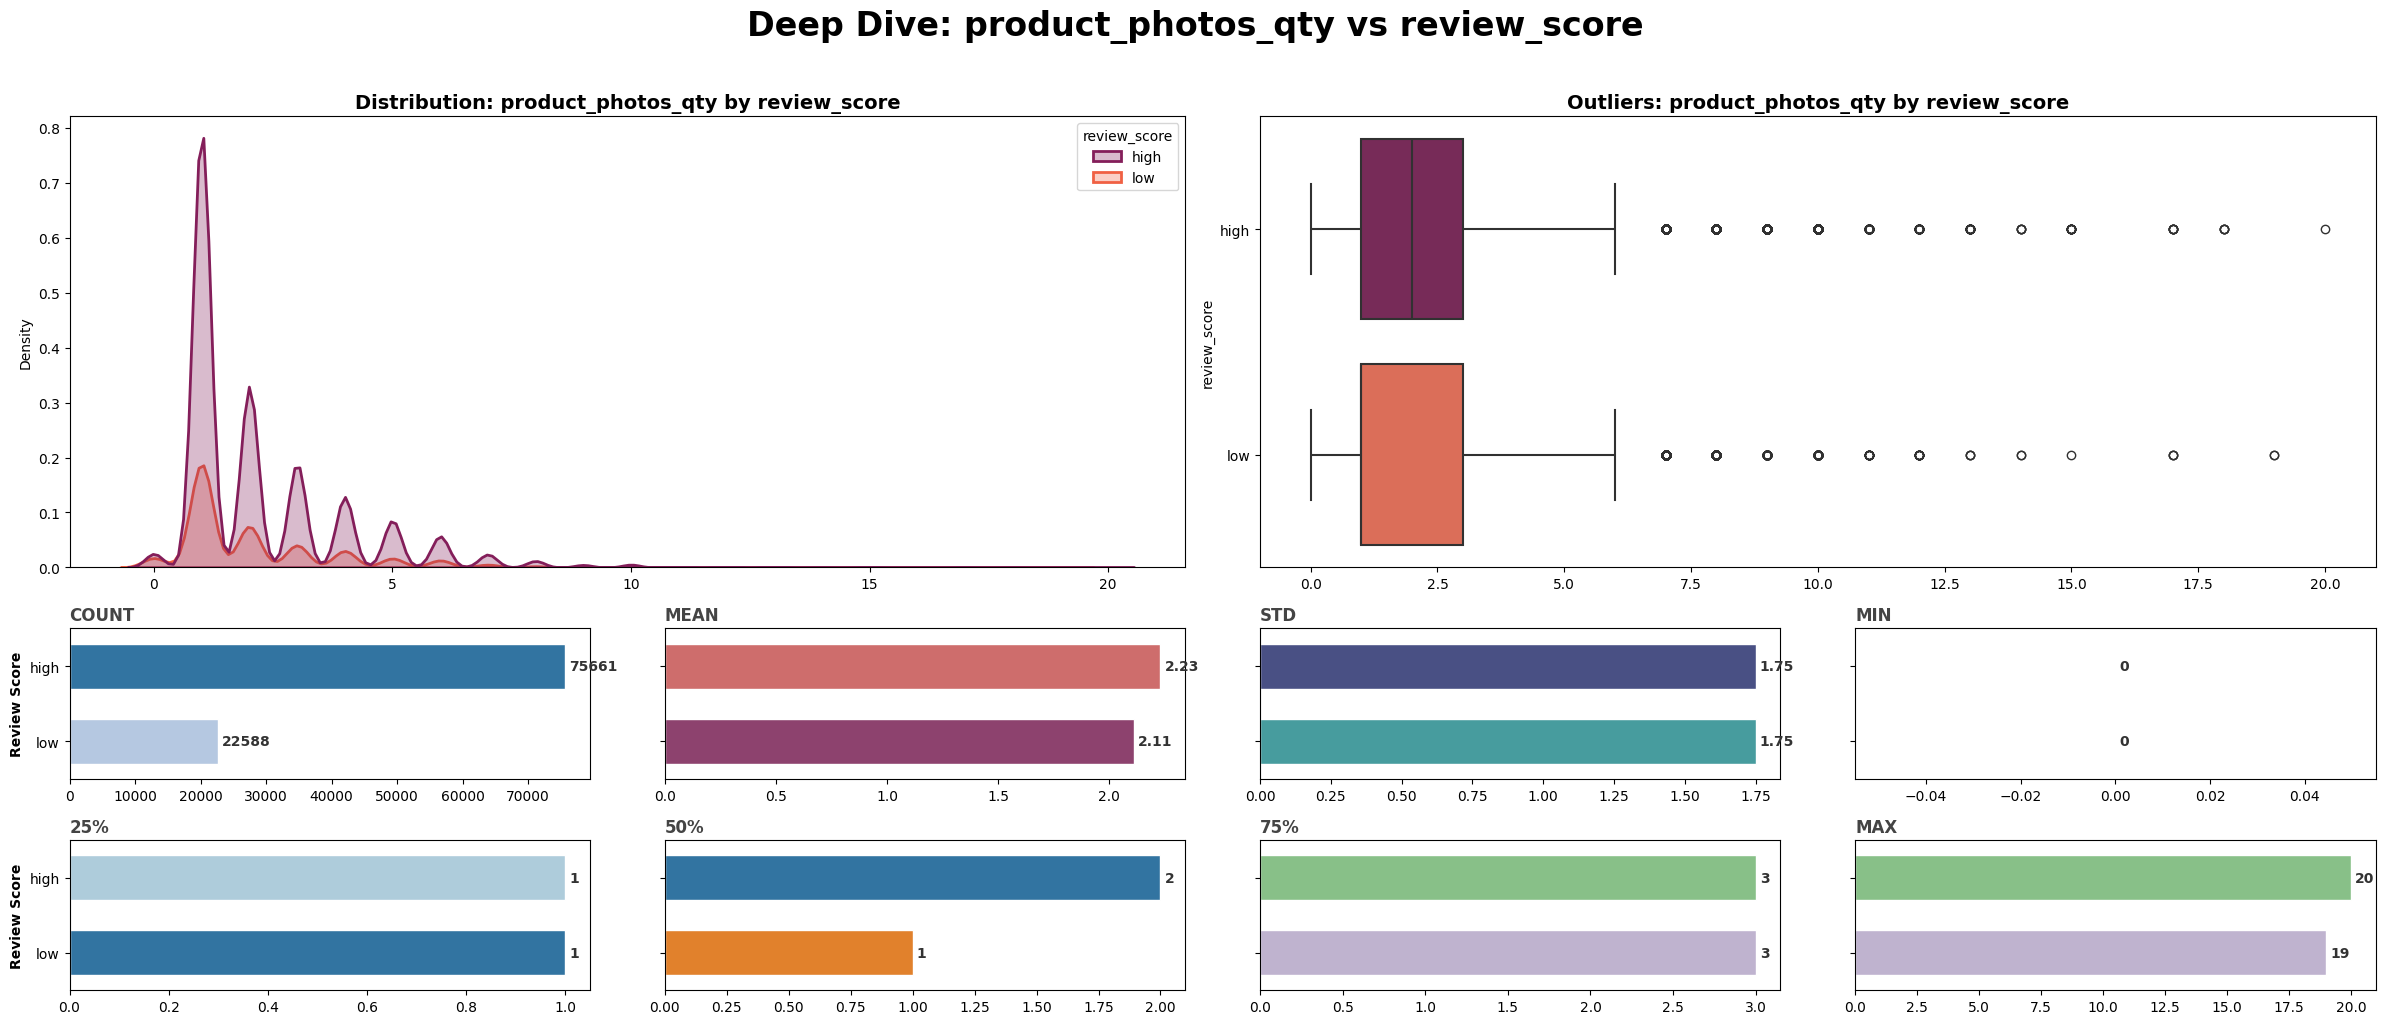

In [209]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'product_photos_qty','review_score')

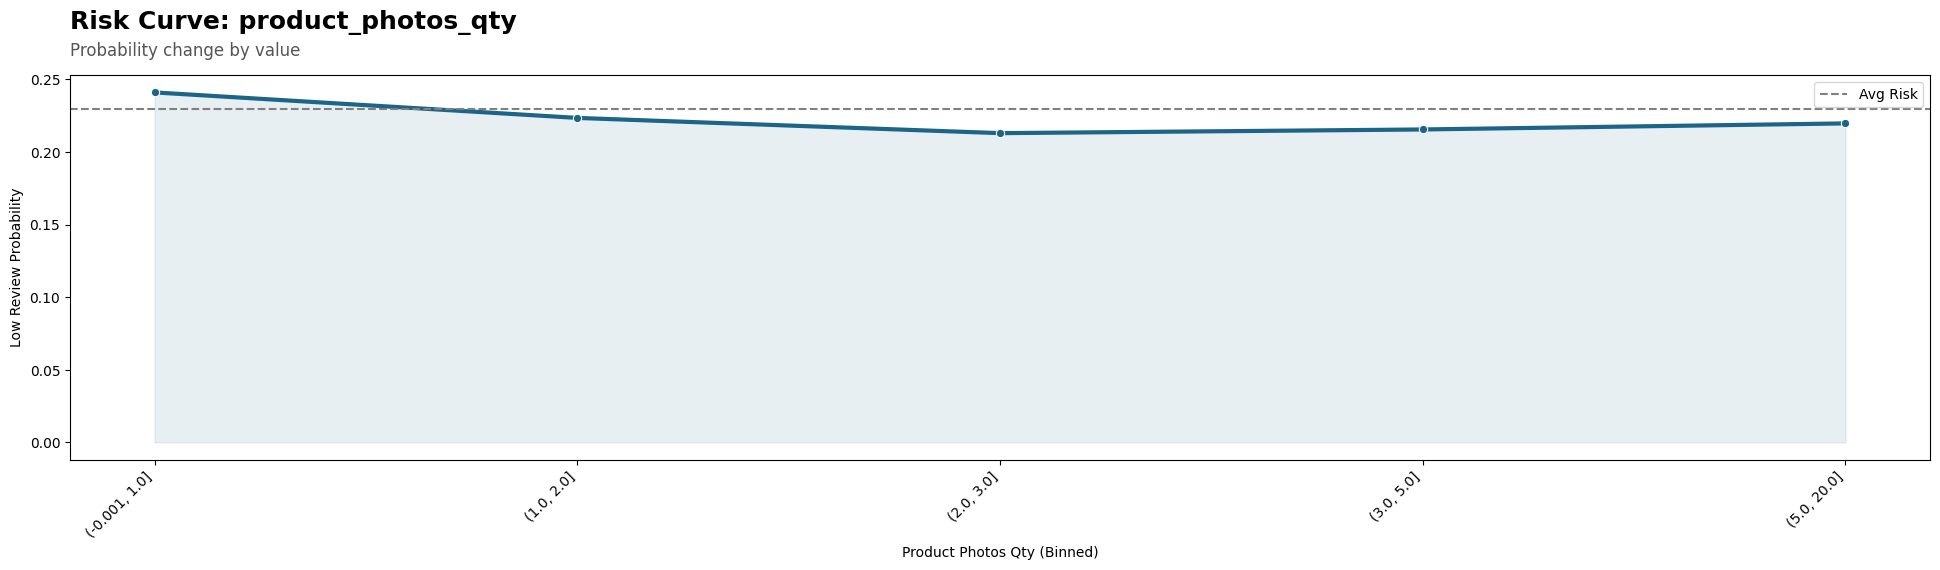

In [210]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'product_photos_qty','review_score')

In [211]:
product_photos_qty_groups = pd.cut(data['product_photos_qty'], 
                         bins=[-1,1,float('inf')], 
                         labels=['Single','Multiple'])

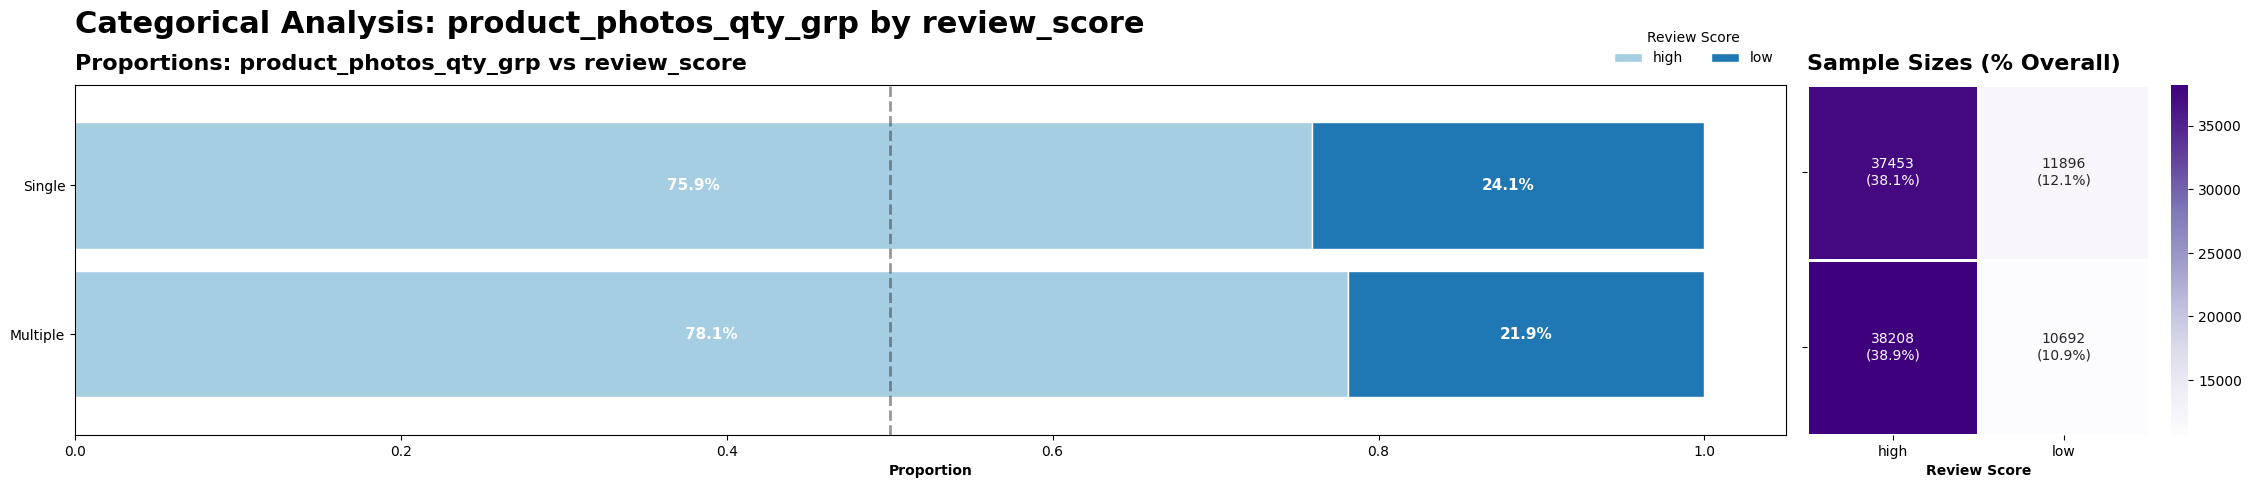

In [213]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(product_photos_qty_grp = product_photos_qty_groups),'product_photos_qty_grp','review_score')

In [216]:
S.compare_means(data,'review_score','product_photos_qty','low')


--- Comparing 'product_photos_qty' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Negligible (Cohen's d = -0.068)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


In [218]:
ct = pd.crosstab(product_photos_qty_groups,data['review_score'])
S.test_association(ct)


--- Association Test: product_photos_qty vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.027)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when there is single photo of the product is available then there is more lower review compared to higher photos ` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**extra_cost**

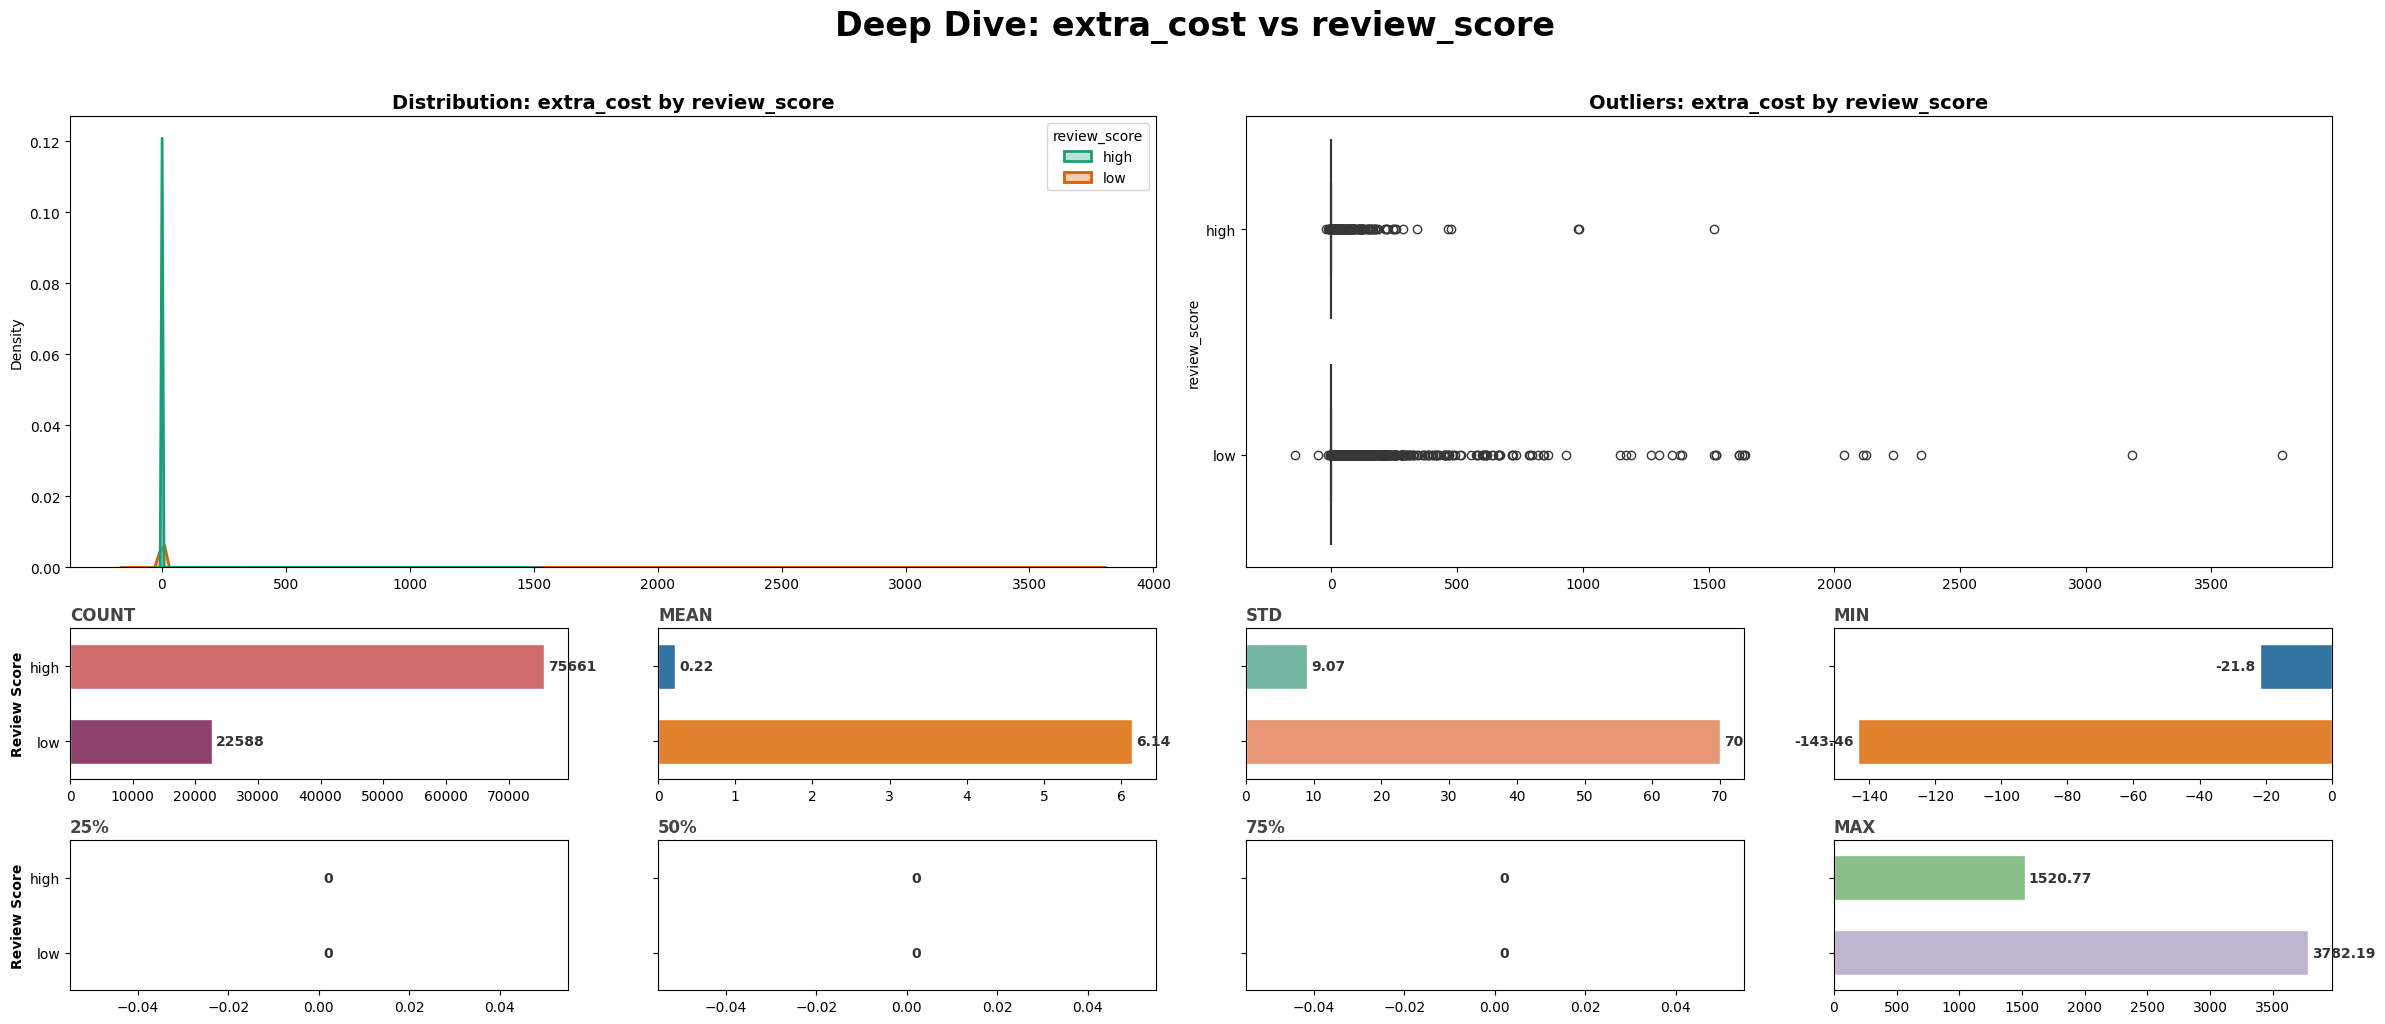

In [219]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'extra_cost','review_score')

In [220]:
S.compare_means(data,'review_score','extra_cost','low')


--- Comparing 'extra_cost' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.172)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


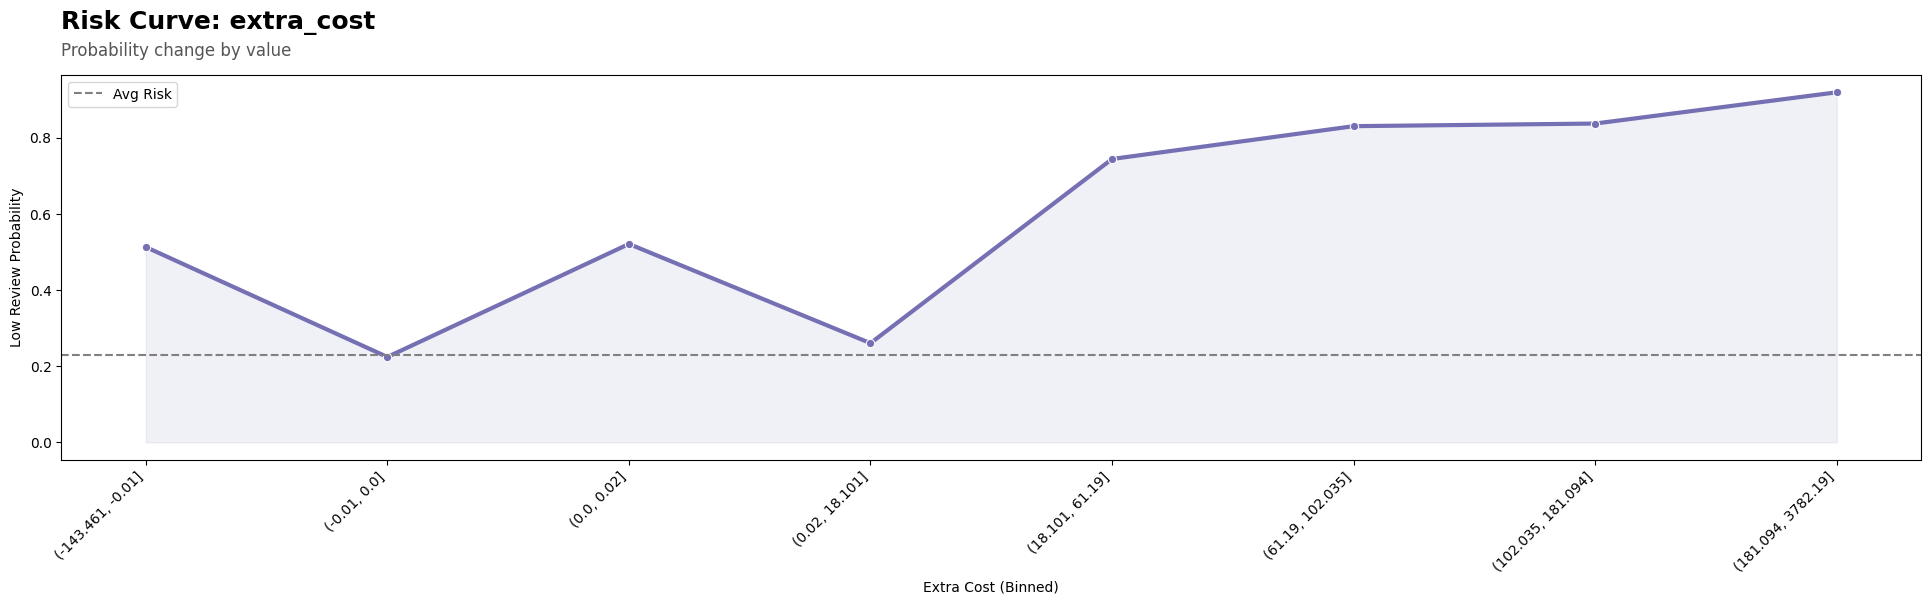

In [225]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'extra_cost','review_score',bins = 500)

In [232]:
extra_cost_groups = pd.cut(data['extra_cost'], 
                         bins=[float('-inf'),0,0.2,19,float('inf')], 
                         labels=['Got Money','Less','Moderate','Crit Zone'])

In [233]:
extra_cost_groups=extra_cost_groups.replace('Less','Crit Zone')

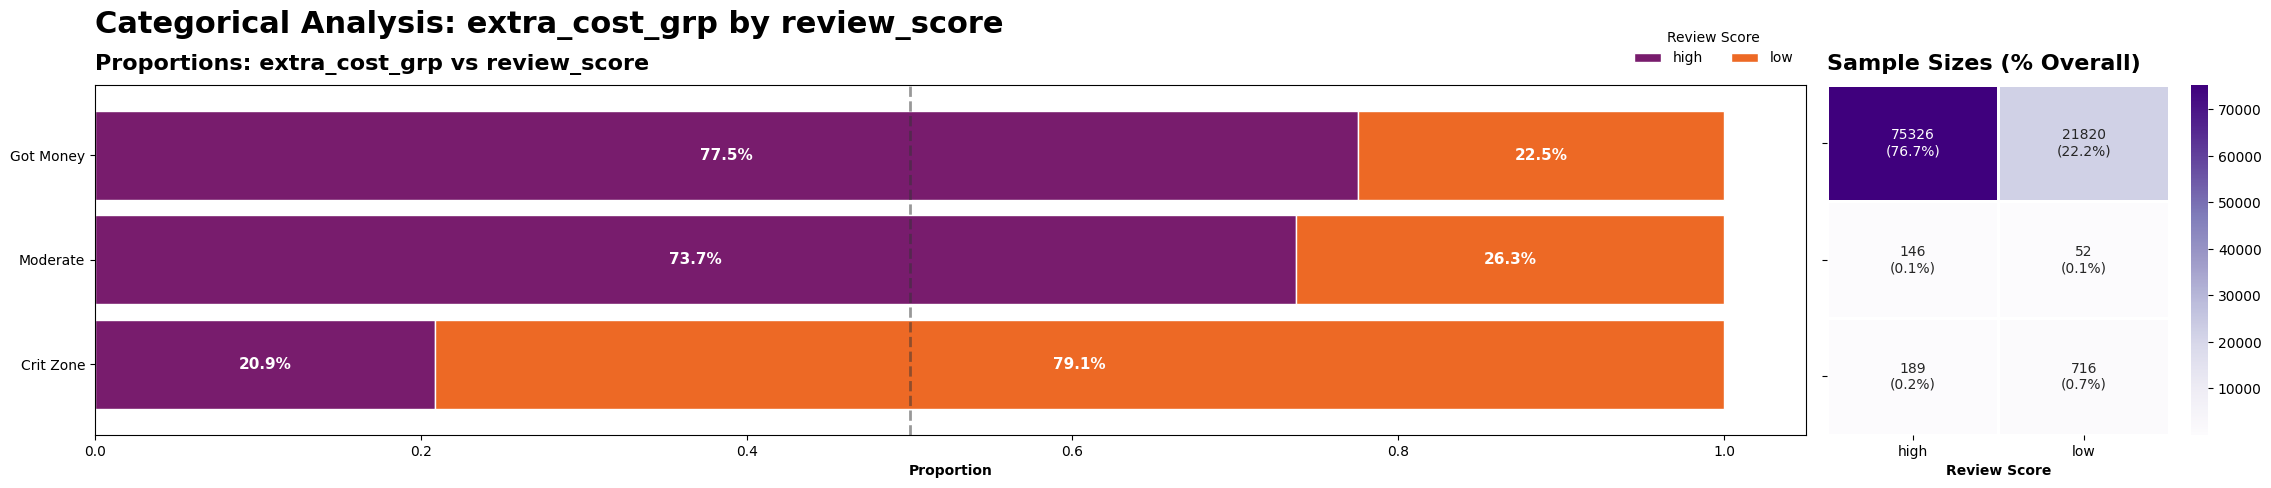

In [234]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(extra_cost_grp = extra_cost_groups),'extra_cost_grp','review_score')

In [235]:
S.compare_means(data,'review_score','extra_cost','low')


--- Comparing 'extra_cost' by 'review_score' (low vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.172)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


In [236]:
ct = pd.crosstab(extra_cost_groups,data['review_score'])
S.test_association(ct)


--- Association Test: extra_cost vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.129)
3. Balance:    High Imbalance (Caution)
------------------------------------------------------------


---
---
- ***By visuals we saw that `there is a crit zone, where very small amount (<0.2) and also bigger amount(>19) is extra charge, in this zone low ratings are the highest in numbers` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**days_to_review**

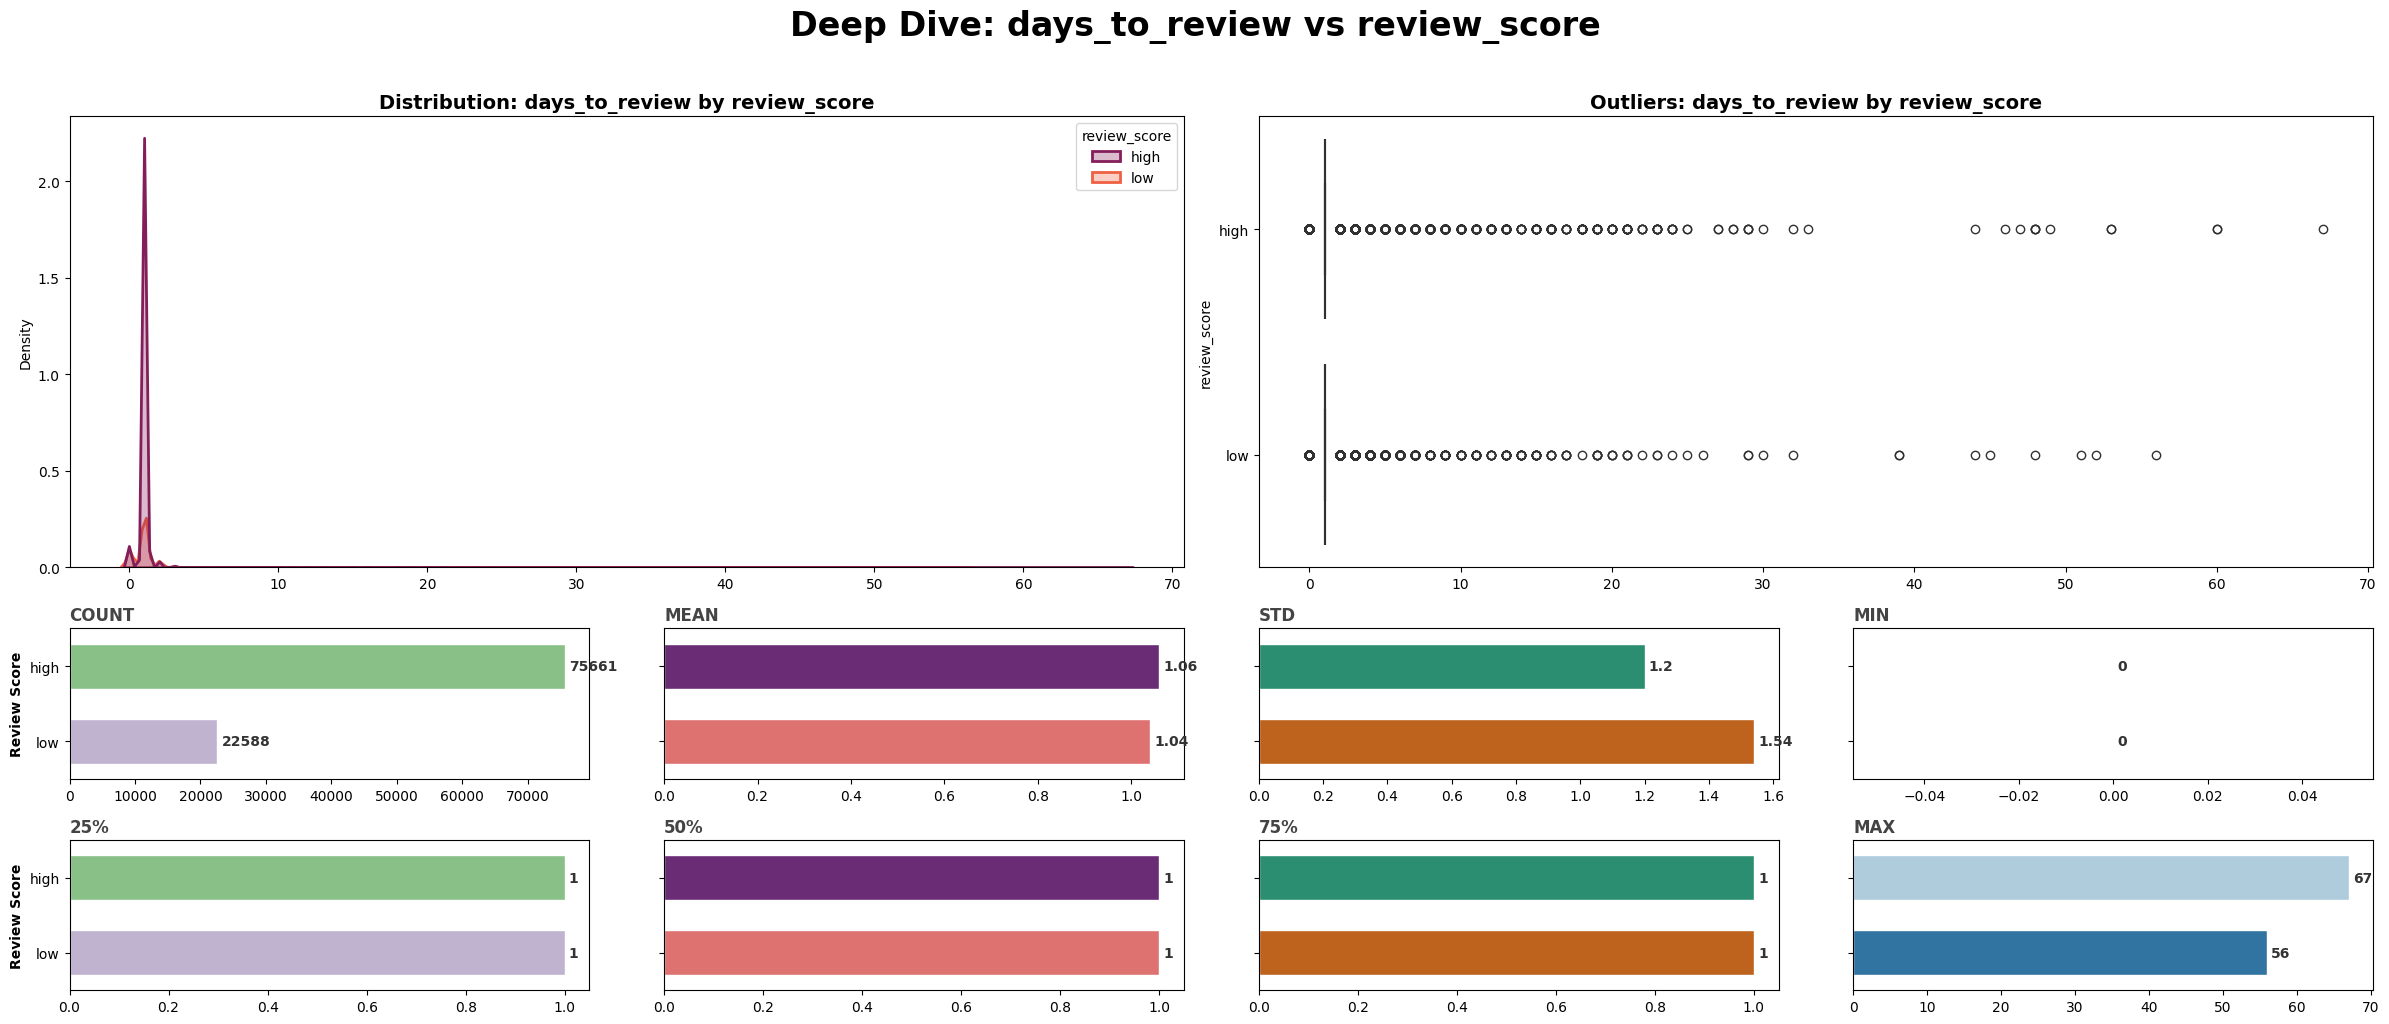

In [237]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'days_to_review','review_score')

In [238]:
S.compare_means(data,'review_score','days_to_review','low')


--- Comparing 'days_to_review' by 'review_score' (low vs Others) ---
1. Verdict:    ❌ NOT Significant (p=0.06097)
2. Strength:   Negligible (Cohen's d = -0.016)
3. Balance:    Robust (High N) (n=22588 vs n=75661)
------------------------------------------------------------


- **There is no significant difference**

**review_month**

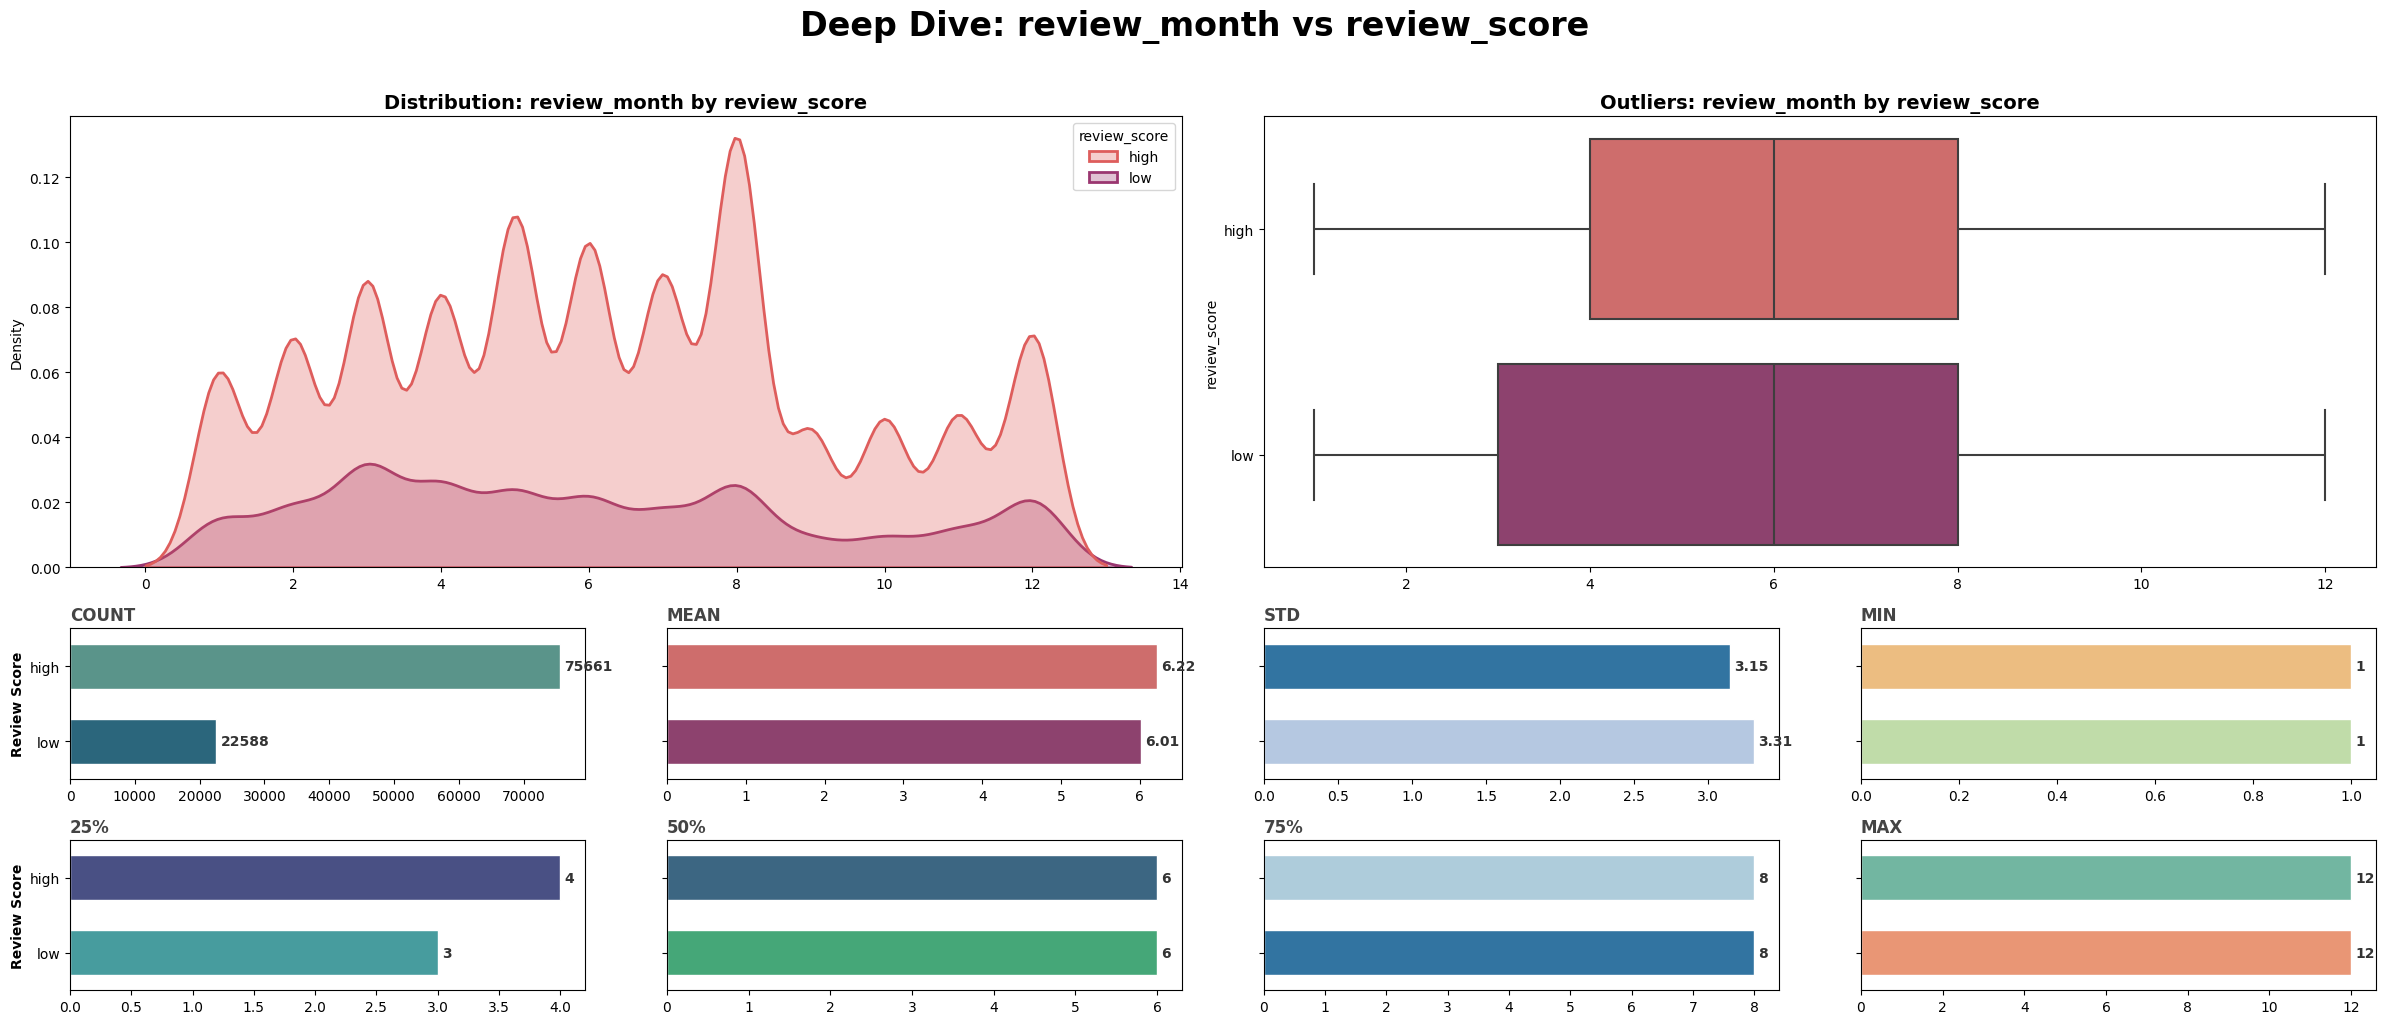

In [240]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'review_month','review_score')

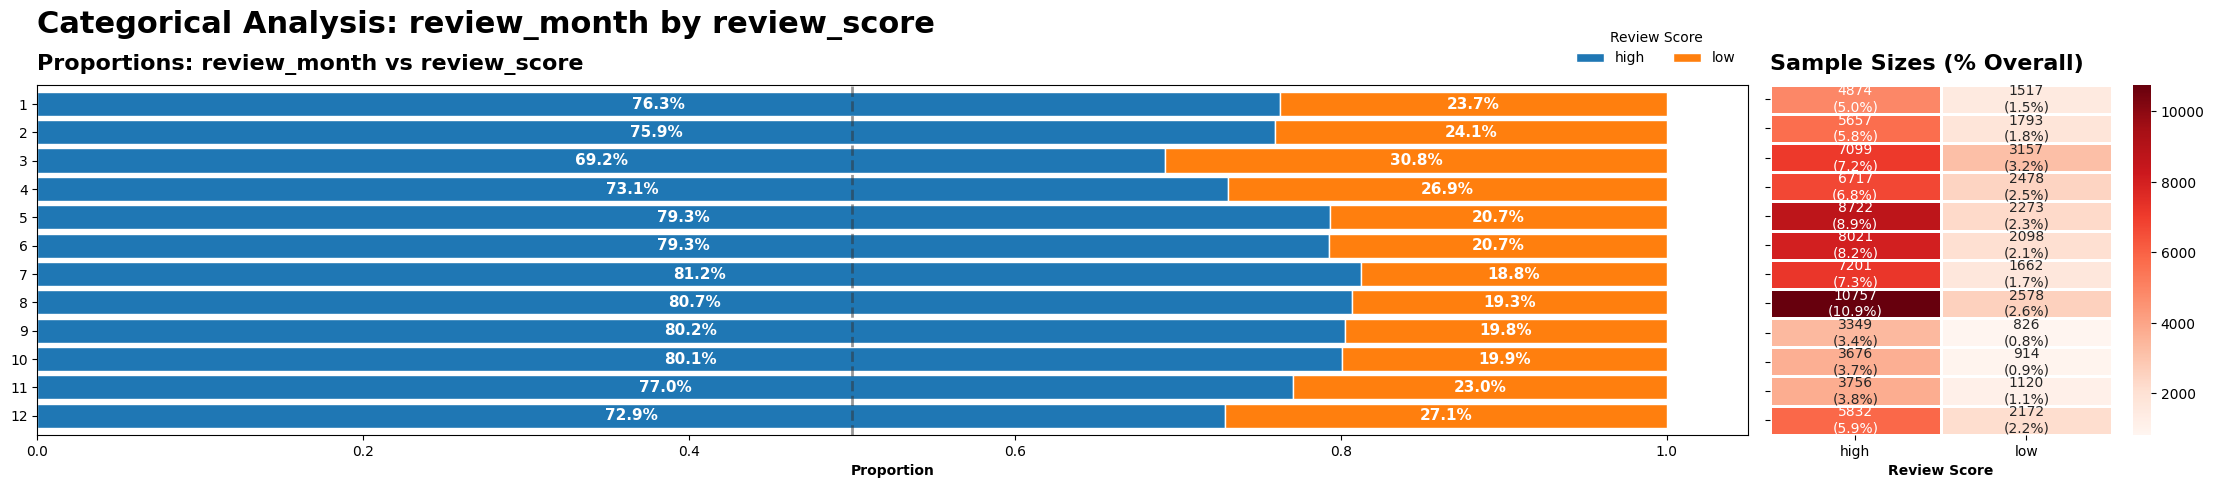

In [241]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'review_month','review_score')

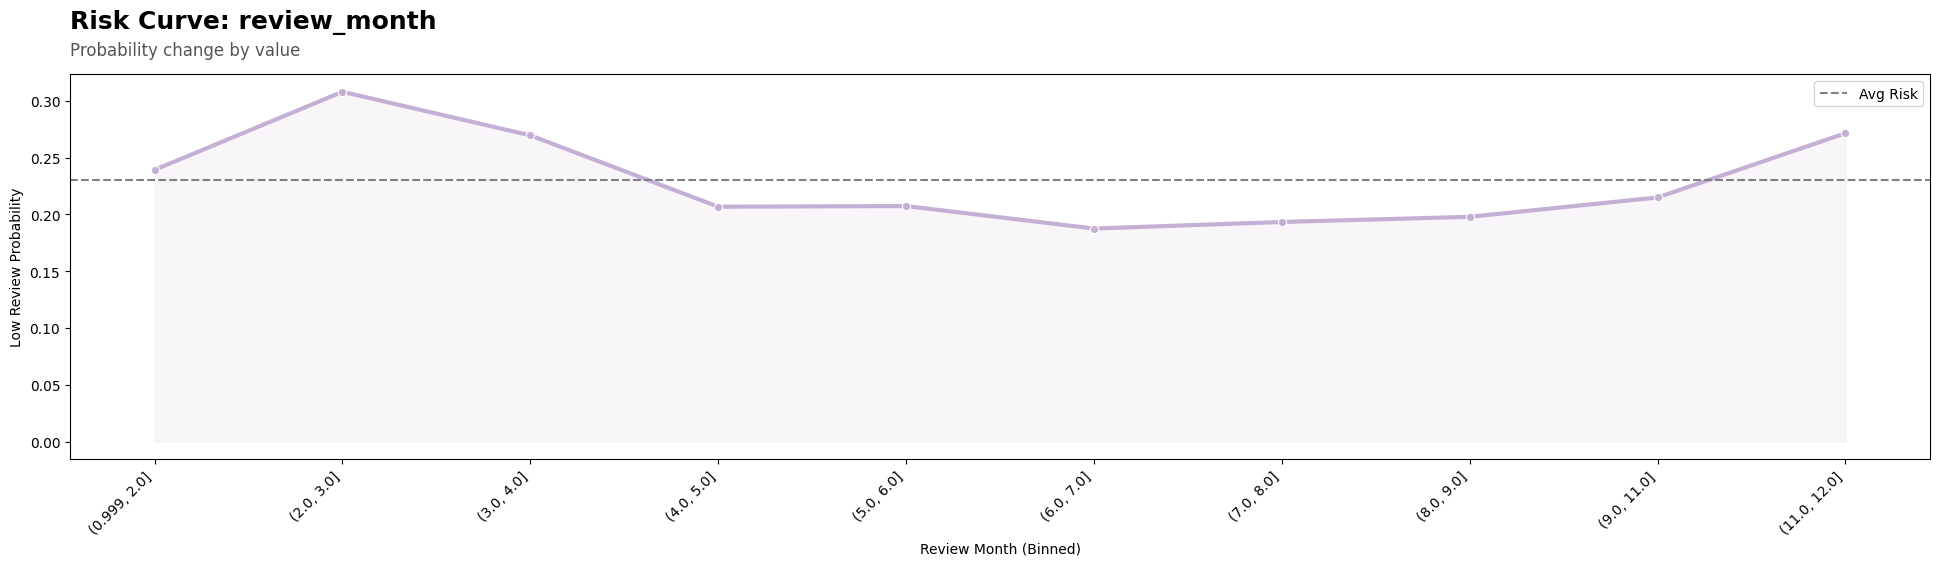

In [242]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'review_month','review_score',bins = 10)

In [264]:
review_month_groups = pd.cut(data['review_month'], 
                         bins=[-1,3,11,13], 
                         labels=['Early','Mid','End'])

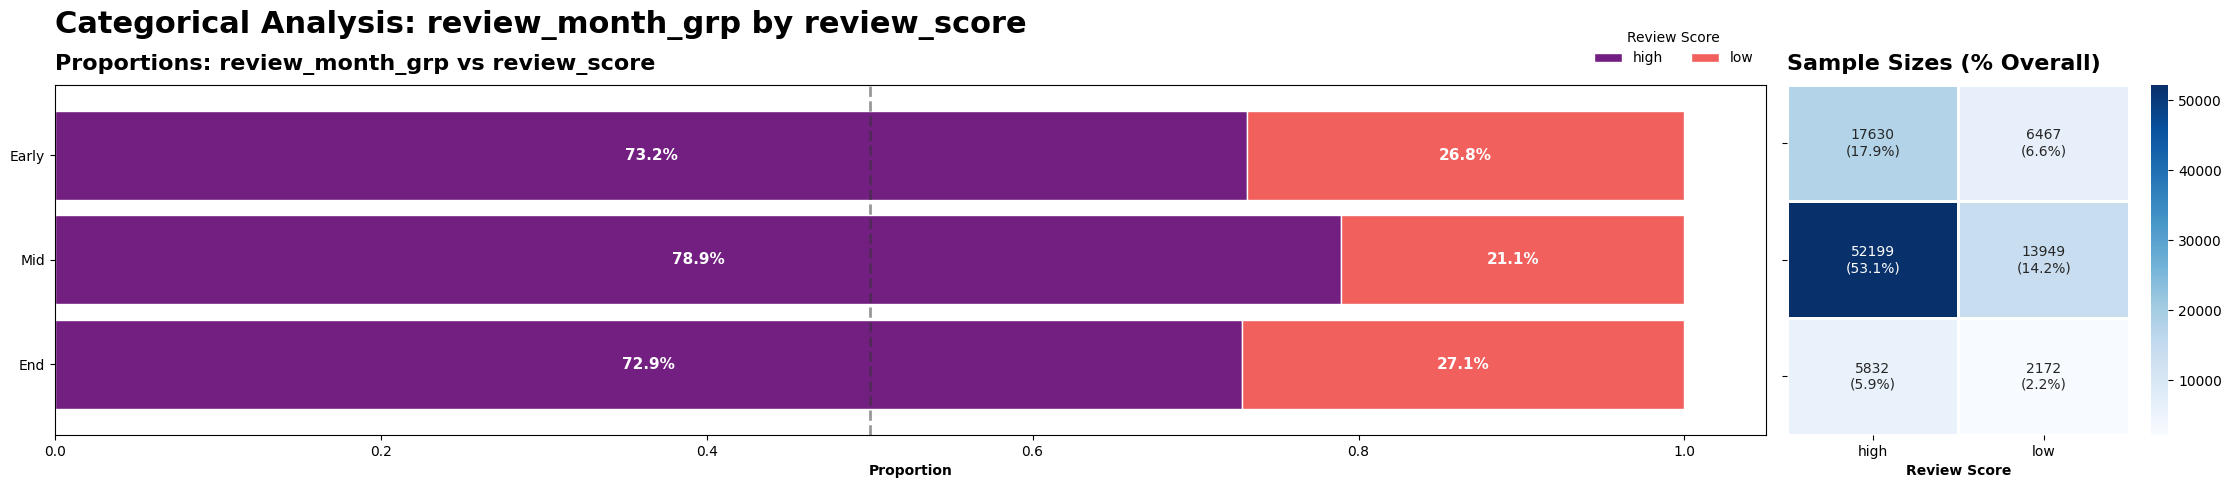

In [265]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(review_month_grp= review_month_groups),'review_month_grp','review_score')

In [266]:
ct = pd.crosstab(review_month_groups,data['review_score'])
S.test_association(ct)


--- Association Test: review_month vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.065)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `a pattern which indicated year into 3 sub groups early(1 -3) mid(4 - 11) and end(12) and the early and end of the year have more lower review score` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**review_year**

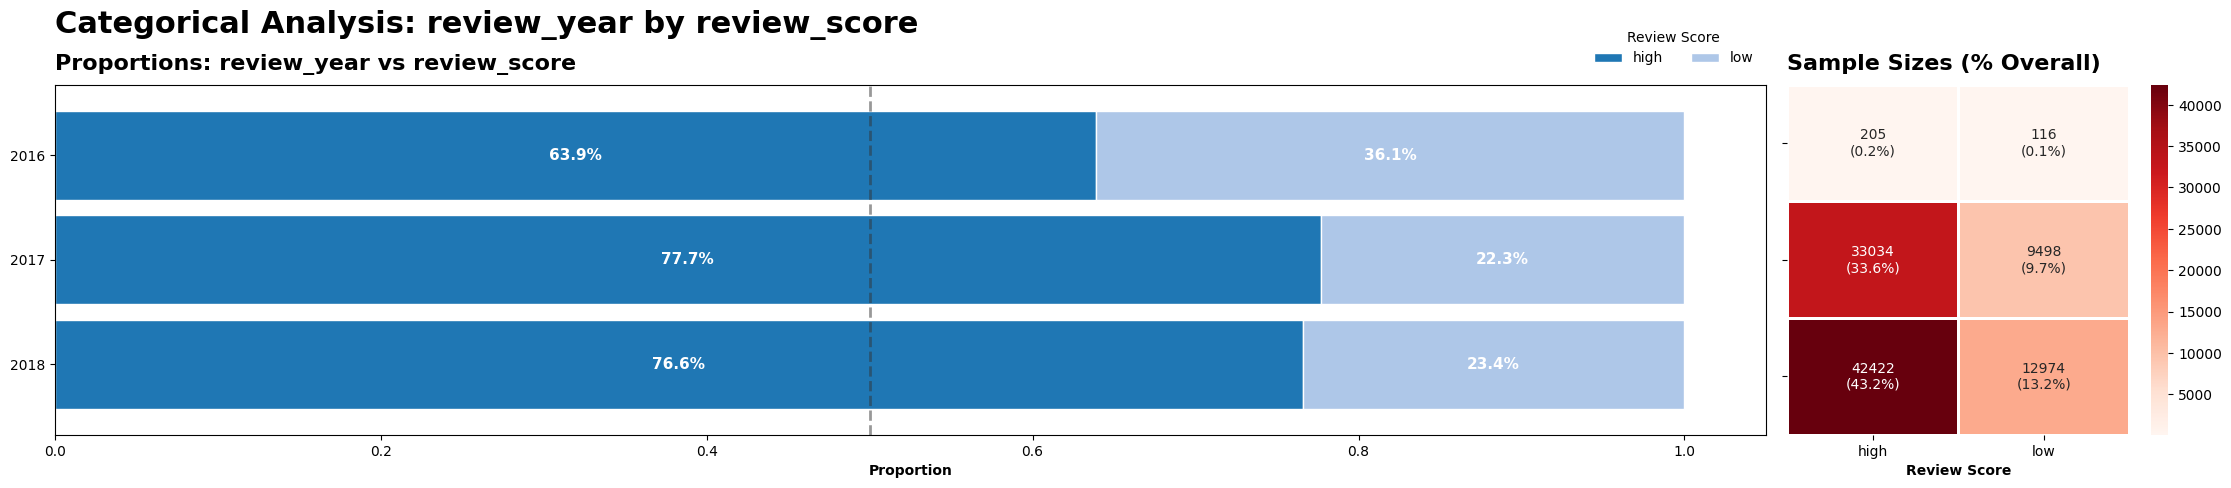

In [267]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'review_year','review_score')

In [268]:
ct = pd.crosstab(data['review_year'],data['review_score'])
S.test_association(ct)


--- Association Test: review_year vs review_score ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.022)
3. Balance:    High Imbalance (Caution)
------------------------------------------------------------


- **nothing specific found**